In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import TrainerVTS_V07D2 as TP
import DataSetting_v2 as DS
from tqdm.notebook import tqdm

### Loader

In [10]:
gpu = 7
date = '240607'
#run = ['30', '100', '300', '900']
run = '300'
exp = 'BBX'

In [11]:
datadir = f'../dataset/0509/make20_{run}-split/'
data = DS.ModalityLoader(data_dir=datadir, mmap_mode='r')
train_set = DS.MyDataset('tv', data.train_data)
test_set = DS.MyDataset('test', data.test_data)
train_loader, valid_loader = DS.DataSplitter(train_set).split_loader()
test_loader = DS.DataSplitter(test_set, 1).gen_loader()

Loading from ../dataset/0509/make20_300-split/


  0%|          | 0/20 [00:00<?, ?it/s]

Generating loaders...
 tv len 4181, distributed=False
 exported train loader of len 52, batch size 64
 exported valid loader of len 13, batch size 64

Generating loaders...
 test len 5299, distributed=False
 exported loader of len 5299, batch size 1


### Teacher

In [4]:
torch.cuda.set_device(gpu)
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)

T_trainer = TP.TeacherTrainer(beta=0.5, 
                              mask=True,
                              recon_lossfunc=nn.MSELoss(reduction='sum'),
                              name='Teacher', networks=[imgencoder, imgdecoder],
                              epochs=10, cuda=gpu,
                              loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                              notion=f"{date}_{run}_{exp}")

In [5]:
### Scheduler
%matplotlib inline
T_trainer.lr = 1e-4
T_trained = T_trainer.schedule(lr_decay=True)

Teacher train: epoch=1/999, batch=0/68, loss=4301.1064, current best valid loss=inf    
Teacher train: epoch=1/999, batch=5/68, loss=4215.6924, current best valid loss=inf    
Teacher train: epoch=1/999, batch=10/68, loss=3805.9316, current best valid loss=inf    
Teacher train: epoch=1/999, batch=15/68, loss=2524.9778, current best valid loss=inf    
Teacher train: epoch=1/999, batch=20/68, loss=2335.6296, current best valid loss=inf    
Teacher train: epoch=1/999, batch=25/68, loss=2484.6262, current best valid loss=inf    
Teacher train: epoch=1/999, batch=30/68, loss=2431.0427, current best valid loss=inf    
Teacher train: epoch=1/999, batch=35/68, loss=1783.0000, current best valid loss=inf    
Teacher train: epoch=1/999, batch=40/68, loss=1551.7913, current best valid loss=inf    
Teacher train: epoch=1/999, batch=45/68, loss=1244.5990, current best valid loss=inf    
Teacher train: epoch=1/999, batch=50/68, loss=1103.0485, current best valid loss=inf    
Teacher train: epoch=1/

### Student

In [12]:
torch.cuda.set_device(gpu)
csiencoder = TP.CSIEncoder(lstm_steps=75)
bbxdecoder = TP.BBXDecoder()
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)
imgencoder.load_state_dict(torch.load(f"../saved/240603_30_Prop_Teacher/Teacher_IMGENV08C1_best.pth"))
imgdecoder.load_state_dict(torch.load(f"../saved/240603_30_Prop_Teacher/Teacher_IMGDEV08C1_best.pth"))

S_trainer = TP.StudentTrainer(name='Student', mask=True, with_img_loss=True,
                              networks=[csiencoder, bbxdecoder, imgencoder, imgdecoder],
                              lr=1e-4, epochs=10, cuda=gpu,
                              loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                              notion=f"{date}_{run}_{exp}",
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader
                             )

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=1/999, batch=0/52, loss=107.6917, current best valid loss=inf    
Student train: epoch=1/999, batch=5/52, loss=73.1612, current best valid loss=inf    
Student train: epoch=1/999, batch=10/52, loss=72.6006, current best valid loss=inf    
Student train: epoch=1/999, batch=15/52, loss=72.1598, current best valid loss=inf    
Student train: epoch=1/999, batch=20/52, loss=72.9733, current best valid loss=inf    
Student train: epoch=1/999, batch=25/52, loss=72.4391, current best valid loss=inf    
Student train: epoch=1/999, batch=30/52, loss=69.9898, current best valid loss=inf    
Student train: epoch=1/999, batch=35/52, loss=67.8162, current best valid loss=inf    
Student train: epoch=1/999, batch=40/52, loss=65.4602, current best valid loss=inf    
Student train: epoch=1/999, batch=45/52, loss=67.1160, current best valid loss=inf    
Student train: epoch=1/999, batch=50/52, loss=62.8258, current best valid loss=inf    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=1/999, batch=0/13, loss=63.8831, current best valid loss=63.8831        
Student valid: epoch=1/999, batch=5/13, loss=66.0302, current best valid loss=63.8831        
Student valid: epoch=1/999, batch=10/13, loss=63.6854, current best valid loss=63.5280        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=2/999, batch=0/52, loss=63.9020, current best valid loss=63.5280    
Student train: epoch=2/999, batch=5/52, loss=59.8397, current best valid loss=63.5280    
Student train: epoch=2/999, batch=10/52, loss=61.8529, current best valid loss=63.5280    
Student train: epoch=2/999, batch=15/52, loss=62.1544, current best valid loss=63.5280    
Student train: epoch=2/999, batch=20/52, loss=58.8546, current best valid loss=63.5280    
Student train: epoch=2/999, batch=25/52, loss=59.9764, current best valid loss=63.5280    
Student train: epoch=2/999, batch=30/52, loss=57.9399, current best valid loss=63.5280    
Student train: epoch=2/999, batch=35/52, loss=57.8938, current best valid loss=63.5280    
Student train: epoch=2/999, batch=40/52, loss=58.7236, current best valid loss=63.5280    
Student train: epoch=2/999, batch=45/52, loss=57.6444, current best valid loss=63.5280    
Student train: epoch=2/999, batch=50/52, loss=57.9835, current best valid loss=63.5280    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=2/999, batch=0/13, loss=60.4443, current best valid loss=60.4443        
Student valid: epoch=2/999, batch=5/13, loss=59.8400, current best valid loss=58.1779        
Student valid: epoch=2/999, batch=10/13, loss=59.5742, current best valid loss=58.1779        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=3/999, batch=0/52, loss=59.4567, current best valid loss=58.1779    
Student train: epoch=3/999, batch=5/52, loss=58.6977, current best valid loss=58.1779    
Student train: epoch=3/999, batch=10/52, loss=59.5172, current best valid loss=58.1779    
Student train: epoch=3/999, batch=15/52, loss=59.2899, current best valid loss=58.1779    
Student train: epoch=3/999, batch=20/52, loss=58.9245, current best valid loss=58.1779    
Student train: epoch=3/999, batch=25/52, loss=59.0723, current best valid loss=58.1779    
Student train: epoch=3/999, batch=30/52, loss=57.2313, current best valid loss=58.1779    
Student train: epoch=3/999, batch=35/52, loss=57.1834, current best valid loss=58.1779    
Student train: epoch=3/999, batch=40/52, loss=55.7772, current best valid loss=58.1779    
Student train: epoch=3/999, batch=45/52, loss=58.4213, current best valid loss=58.1779    
Student train: epoch=3/999, batch=50/52, loss=58.0301, current best valid loss=58.1779    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=3/999, batch=0/13, loss=55.4894, current best valid loss=55.4894        
Student valid: epoch=3/999, batch=5/13, loss=58.7952, current best valid loss=55.4894        
Student valid: epoch=3/999, batch=10/13, loss=57.0055, current best valid loss=55.4894        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=4/999, batch=0/52, loss=56.6892, current best valid loss=55.4894    
Student train: epoch=4/999, batch=5/52, loss=58.5268, current best valid loss=55.4894    
Student train: epoch=4/999, batch=10/52, loss=57.4937, current best valid loss=55.4894    
Student train: epoch=4/999, batch=15/52, loss=57.7500, current best valid loss=55.4894    
Student train: epoch=4/999, batch=20/52, loss=56.0548, current best valid loss=55.4894    
Student train: epoch=4/999, batch=25/52, loss=54.5796, current best valid loss=55.4894    
Student train: epoch=4/999, batch=30/52, loss=52.9580, current best valid loss=55.4894    
Student train: epoch=4/999, batch=35/52, loss=55.7992, current best valid loss=55.4894    
Student train: epoch=4/999, batch=40/52, loss=55.4935, current best valid loss=55.4894    
Student train: epoch=4/999, batch=45/52, loss=51.7411, current best valid loss=55.4894    
Student train: epoch=4/999, batch=50/52, loss=54.2101, current best valid loss=55.4894    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=4/999, batch=0/13, loss=55.8206, current best valid loss=55.4894        
Student valid: epoch=4/999, batch=5/13, loss=55.5135, current best valid loss=55.4894        
Student valid: epoch=4/999, batch=10/13, loss=55.1156, current best valid loss=55.4894        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=5/999, batch=0/52, loss=55.5815, current best valid loss=55.4894    
Student train: epoch=5/999, batch=5/52, loss=54.3619, current best valid loss=55.4894    
Student train: epoch=5/999, batch=10/52, loss=53.9599, current best valid loss=55.4894    
Student train: epoch=5/999, batch=15/52, loss=56.1994, current best valid loss=55.4894    
Student train: epoch=5/999, batch=20/52, loss=54.5837, current best valid loss=55.4894    
Student train: epoch=5/999, batch=25/52, loss=54.9987, current best valid loss=55.4894    
Student train: epoch=5/999, batch=30/52, loss=53.2394, current best valid loss=55.4894    
Student train: epoch=5/999, batch=35/52, loss=54.8528, current best valid loss=55.4894    
Student train: epoch=5/999, batch=40/52, loss=55.4455, current best valid loss=55.4894    
Student train: epoch=5/999, batch=45/52, loss=53.5194, current best valid loss=55.4894    
Student train: epoch=5/999, batch=50/52, loss=53.4486, current best valid loss=55.4894    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=5/999, batch=0/13, loss=53.4284, current best valid loss=53.4284        
Student valid: epoch=5/999, batch=5/13, loss=54.8496, current best valid loss=53.1827        
Student valid: epoch=5/999, batch=10/13, loss=54.5301, current best valid loss=53.1827        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=6/999, batch=0/52, loss=56.0831, current best valid loss=53.1827    
Student train: epoch=6/999, batch=5/52, loss=55.1914, current best valid loss=53.1827    
Student train: epoch=6/999, batch=10/52, loss=54.5761, current best valid loss=53.1827    
Student train: epoch=6/999, batch=15/52, loss=52.9734, current best valid loss=53.1827    
Student train: epoch=6/999, batch=20/52, loss=52.6033, current best valid loss=53.1827    
Student train: epoch=6/999, batch=25/52, loss=54.4831, current best valid loss=53.1827    
Student train: epoch=6/999, batch=30/52, loss=52.6662, current best valid loss=53.1827    
Student train: epoch=6/999, batch=35/52, loss=49.2596, current best valid loss=53.1827    
Student train: epoch=6/999, batch=40/52, loss=47.5888, current best valid loss=53.1827    
Student train: epoch=6/999, batch=45/52, loss=48.2398, current best valid loss=53.1827    
Student train: epoch=6/999, batch=50/52, loss=49.8731, current best valid loss=53.1827    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=6/999, batch=0/13, loss=41.3127, current best valid loss=41.3127        
Student valid: epoch=6/999, batch=5/13, loss=47.4541, current best valid loss=41.3127        
Student valid: epoch=6/999, batch=10/13, loss=47.5281, current best valid loss=41.3127        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=7/999, batch=0/52, loss=45.8266, current best valid loss=41.3127    
Student train: epoch=7/999, batch=5/52, loss=49.5165, current best valid loss=41.3127    
Student train: epoch=7/999, batch=10/52, loss=42.6090, current best valid loss=41.3127    
Student train: epoch=7/999, batch=15/52, loss=43.8050, current best valid loss=41.3127    
Student train: epoch=7/999, batch=20/52, loss=46.9752, current best valid loss=41.3127    
Student train: epoch=7/999, batch=25/52, loss=43.0860, current best valid loss=41.3127    
Student train: epoch=7/999, batch=30/52, loss=40.9513, current best valid loss=41.3127    
Student train: epoch=7/999, batch=35/52, loss=44.4524, current best valid loss=41.3127    
Student train: epoch=7/999, batch=40/52, loss=44.0892, current best valid loss=41.3127    
Student train: epoch=7/999, batch=45/52, loss=44.9417, current best valid loss=41.3127    
Student train: epoch=7/999, batch=50/52, loss=37.6741, current best valid loss=41.3127    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=7/999, batch=0/13, loss=42.9276, current best valid loss=41.3127        
Student valid: epoch=7/999, batch=5/13, loss=41.3996, current best valid loss=39.8282        
Student valid: epoch=7/999, batch=10/13, loss=39.1281, current best valid loss=39.8282        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=8/999, batch=0/52, loss=40.7177, current best valid loss=39.8282    
Student train: epoch=8/999, batch=5/52, loss=38.1771, current best valid loss=39.8282    
Student train: epoch=8/999, batch=10/52, loss=39.8119, current best valid loss=39.8282    
Student train: epoch=8/999, batch=15/52, loss=41.0309, current best valid loss=39.8282    
Student train: epoch=8/999, batch=20/52, loss=39.5918, current best valid loss=39.8282    
Student train: epoch=8/999, batch=25/52, loss=38.0418, current best valid loss=39.8282    
Student train: epoch=8/999, batch=30/52, loss=39.6542, current best valid loss=39.8282    
Student train: epoch=8/999, batch=35/52, loss=37.3597, current best valid loss=39.8282    
Student train: epoch=8/999, batch=40/52, loss=36.6860, current best valid loss=39.8282    
Student train: epoch=8/999, batch=45/52, loss=38.3643, current best valid loss=39.8282    
Student train: epoch=8/999, batch=50/52, loss=37.5474, current best valid loss=39.8282    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=8/999, batch=0/13, loss=36.1474, current best valid loss=36.1474        
Student valid: epoch=8/999, batch=5/13, loss=33.6402, current best valid loss=36.1474        
Student valid: epoch=8/999, batch=10/13, loss=38.7703, current best valid loss=36.1474        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=9/999, batch=0/52, loss=37.4460, current best valid loss=36.1474    
Student train: epoch=9/999, batch=5/52, loss=36.0582, current best valid loss=36.1474    
Student train: epoch=9/999, batch=10/52, loss=35.3094, current best valid loss=36.1474    
Student train: epoch=9/999, batch=15/52, loss=36.8097, current best valid loss=36.1474    
Student train: epoch=9/999, batch=20/52, loss=34.4282, current best valid loss=36.1474    
Student train: epoch=9/999, batch=25/52, loss=36.4836, current best valid loss=36.1474    
Student train: epoch=9/999, batch=30/52, loss=36.7626, current best valid loss=36.1474    
Student train: epoch=9/999, batch=35/52, loss=38.6426, current best valid loss=36.1474    
Student train: epoch=9/999, batch=40/52, loss=36.2904, current best valid loss=36.1474    
Student train: epoch=9/999, batch=45/52, loss=35.9026, current best valid loss=36.1474    
Student train: epoch=9/999, batch=50/52, loss=32.3275, current best valid loss=36.1474    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=9/999, batch=0/13, loss=36.0295, current best valid loss=36.0295        
Student valid: epoch=9/999, batch=5/13, loss=34.5873, current best valid loss=35.5124        
Student valid: epoch=9/999, batch=10/13, loss=33.3947, current best valid loss=35.3751        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=10/999, batch=0/52, loss=34.3096, current best valid loss=35.3751    
Student train: epoch=10/999, batch=5/52, loss=38.1268, current best valid loss=35.3751    
Student train: epoch=10/999, batch=10/52, loss=35.7836, current best valid loss=35.3751    
Student train: epoch=10/999, batch=15/52, loss=33.5627, current best valid loss=35.3751    
Student train: epoch=10/999, batch=20/52, loss=36.4277, current best valid loss=35.3751    
Student train: epoch=10/999, batch=25/52, loss=36.4250, current best valid loss=35.3751    
Student train: epoch=10/999, batch=30/52, loss=35.5494, current best valid loss=35.3751    
Student train: epoch=10/999, batch=35/52, loss=35.9803, current best valid loss=35.3751    
Student train: epoch=10/999, batch=40/52, loss=34.5091, current best valid loss=35.3751    
Student train: epoch=10/999, batch=45/52, loss=30.3349, current best valid loss=35.3751    
Student train: epoch=10/999, batch=50/52, loss=33.4134, current best valid loss=35

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=10/999, batch=0/13, loss=31.8986, current best valid loss=31.8986        
Student valid: epoch=10/999, batch=5/13, loss=34.5858, current best valid loss=31.8986        
Student valid: epoch=10/999, batch=10/13, loss=35.5807, current best valid loss=31.8986        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=11/999, batch=0/52, loss=34.5632, current best valid loss=31.8986    
Student train: epoch=11/999, batch=5/52, loss=34.4925, current best valid loss=31.8986    
Student train: epoch=11/999, batch=10/52, loss=34.5543, current best valid loss=31.8986    
Student train: epoch=11/999, batch=15/52, loss=33.4571, current best valid loss=31.8986    
Student train: epoch=11/999, batch=20/52, loss=31.0119, current best valid loss=31.8986    
Student train: epoch=11/999, batch=25/52, loss=34.8098, current best valid loss=31.8986    
Student train: epoch=11/999, batch=30/52, loss=30.8608, current best valid loss=31.8986    
Student train: epoch=11/999, batch=35/52, loss=32.4265, current best valid loss=31.8986    
Student train: epoch=11/999, batch=40/52, loss=30.0199, current best valid loss=31.8986    
Student train: epoch=11/999, batch=45/52, loss=32.6467, current best valid loss=31.8986    
Student train: epoch=11/999, batch=50/52, loss=31.7451, current best valid loss=31

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=11/999, batch=0/13, loss=32.1946, current best valid loss=31.8986        
Student valid: epoch=11/999, batch=5/13, loss=30.9136, current best valid loss=31.6606        
Student valid: epoch=11/999, batch=10/13, loss=35.5864, current best valid loss=31.6606        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=12/999, batch=0/52, loss=32.9602, current best valid loss=31.6606    
Student train: epoch=12/999, batch=5/52, loss=31.5479, current best valid loss=31.6606    
Student train: epoch=12/999, batch=10/52, loss=31.3764, current best valid loss=31.6606    
Student train: epoch=12/999, batch=15/52, loss=33.6637, current best valid loss=31.6606    
Student train: epoch=12/999, batch=20/52, loss=29.6680, current best valid loss=31.6606    
Student train: epoch=12/999, batch=25/52, loss=30.1477, current best valid loss=31.6606    
Student train: epoch=12/999, batch=30/52, loss=32.2962, current best valid loss=31.6606    
Student train: epoch=12/999, batch=35/52, loss=29.4333, current best valid loss=31.6606    
Student train: epoch=12/999, batch=40/52, loss=29.9247, current best valid loss=31.6606    
Student train: epoch=12/999, batch=45/52, loss=29.4513, current best valid loss=31.6606    
Student train: epoch=12/999, batch=50/52, loss=29.2908, current best valid loss=31

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=12/999, batch=0/13, loss=26.2845, current best valid loss=26.2845        
Student valid: epoch=12/999, batch=5/13, loss=31.7639, current best valid loss=26.2845        
Student valid: epoch=12/999, batch=10/13, loss=29.2121, current best valid loss=26.2845        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=13/999, batch=0/52, loss=29.8656, current best valid loss=26.2845    
Student train: epoch=13/999, batch=5/52, loss=29.7052, current best valid loss=26.2845    
Student train: epoch=13/999, batch=10/52, loss=27.6985, current best valid loss=26.2845    
Student train: epoch=13/999, batch=15/52, loss=32.0291, current best valid loss=26.2845    
Student train: epoch=13/999, batch=20/52, loss=28.6624, current best valid loss=26.2845    
Student train: epoch=13/999, batch=25/52, loss=31.8674, current best valid loss=26.2845    
Student train: epoch=13/999, batch=30/52, loss=34.1437, current best valid loss=26.2845    
Student train: epoch=13/999, batch=35/52, loss=33.4891, current best valid loss=26.2845    
Student train: epoch=13/999, batch=40/52, loss=28.3261, current best valid loss=26.2845    
Student train: epoch=13/999, batch=45/52, loss=29.5443, current best valid loss=26.2845    
Student train: epoch=13/999, batch=50/52, loss=31.1666, current best valid loss=26

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=13/999, batch=0/13, loss=29.9727, current best valid loss=26.2845        
Student valid: epoch=13/999, batch=5/13, loss=29.9986, current best valid loss=26.2845        
Student valid: epoch=13/999, batch=10/13, loss=24.0437, current best valid loss=26.2845        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=14/999, batch=0/52, loss=28.3755, current best valid loss=26.2845    
Student train: epoch=14/999, batch=5/52, loss=28.4482, current best valid loss=26.2845    
Student train: epoch=14/999, batch=10/52, loss=27.8606, current best valid loss=26.2845    
Student train: epoch=14/999, batch=15/52, loss=27.7698, current best valid loss=26.2845    
Student train: epoch=14/999, batch=20/52, loss=28.7744, current best valid loss=26.2845    
Student train: epoch=14/999, batch=25/52, loss=27.4496, current best valid loss=26.2845    
Student train: epoch=14/999, batch=30/52, loss=25.1989, current best valid loss=26.2845    
Student train: epoch=14/999, batch=35/52, loss=30.1135, current best valid loss=26.2845    
Student train: epoch=14/999, batch=40/52, loss=26.5159, current best valid loss=26.2845    
Student train: epoch=14/999, batch=45/52, loss=31.8772, current best valid loss=26.2845    
Student train: epoch=14/999, batch=50/52, loss=26.8694, current best valid loss=26

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=14/999, batch=0/13, loss=26.0948, current best valid loss=26.0948        
Student valid: epoch=14/999, batch=5/13, loss=27.2313, current best valid loss=25.2474        
Student valid: epoch=14/999, batch=10/13, loss=27.2802, current best valid loss=25.2474        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=15/999, batch=0/52, loss=25.2356, current best valid loss=25.2474    
Student train: epoch=15/999, batch=5/52, loss=26.7874, current best valid loss=25.2474    
Student train: epoch=15/999, batch=10/52, loss=27.0838, current best valid loss=25.2474    
Student train: epoch=15/999, batch=15/52, loss=24.7187, current best valid loss=25.2474    
Student train: epoch=15/999, batch=20/52, loss=29.0476, current best valid loss=25.2474    
Student train: epoch=15/999, batch=25/52, loss=26.0856, current best valid loss=25.2474    
Student train: epoch=15/999, batch=30/52, loss=27.6685, current best valid loss=25.2474    
Student train: epoch=15/999, batch=35/52, loss=27.3531, current best valid loss=25.2474    
Student train: epoch=15/999, batch=40/52, loss=27.8582, current best valid loss=25.2474    
Student train: epoch=15/999, batch=45/52, loss=25.5537, current best valid loss=25.2474    
Student train: epoch=15/999, batch=50/52, loss=24.2660, current best valid loss=25

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=15/999, batch=0/13, loss=26.9792, current best valid loss=25.2474        
Student valid: epoch=15/999, batch=5/13, loss=27.3612, current best valid loss=25.2474        
Student valid: epoch=15/999, batch=10/13, loss=25.3821, current best valid loss=25.2474        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=16/999, batch=0/52, loss=28.1461, current best valid loss=25.2474    
Student train: epoch=16/999, batch=5/52, loss=26.2186, current best valid loss=25.2474    
Student train: epoch=16/999, batch=10/52, loss=24.6363, current best valid loss=25.2474    
Student train: epoch=16/999, batch=15/52, loss=26.5116, current best valid loss=25.2474    
Student train: epoch=16/999, batch=20/52, loss=32.4277, current best valid loss=25.2474    
Student train: epoch=16/999, batch=25/52, loss=24.6989, current best valid loss=25.2474    
Student train: epoch=16/999, batch=30/52, loss=24.6330, current best valid loss=25.2474    
Student train: epoch=16/999, batch=35/52, loss=24.7331, current best valid loss=25.2474    
Student train: epoch=16/999, batch=40/52, loss=24.9284, current best valid loss=25.2474    
Student train: epoch=16/999, batch=45/52, loss=25.6157, current best valid loss=25.2474    
Student train: epoch=16/999, batch=50/52, loss=30.6018, current best valid loss=25

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=16/999, batch=0/13, loss=24.3325, current best valid loss=24.3325        
Student valid: epoch=16/999, batch=5/13, loss=25.9110, current best valid loss=24.1282        
Student valid: epoch=16/999, batch=10/13, loss=24.6105, current best valid loss=24.1282        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=17/999, batch=0/52, loss=25.2394, current best valid loss=24.1282    
Student train: epoch=17/999, batch=5/52, loss=25.6110, current best valid loss=24.1282    
Student train: epoch=17/999, batch=10/52, loss=27.4799, current best valid loss=24.1282    
Student train: epoch=17/999, batch=15/52, loss=28.1410, current best valid loss=24.1282    
Student train: epoch=17/999, batch=20/52, loss=25.0853, current best valid loss=24.1282    
Student train: epoch=17/999, batch=25/52, loss=26.6946, current best valid loss=24.1282    
Student train: epoch=17/999, batch=30/52, loss=25.0622, current best valid loss=24.1282    
Student train: epoch=17/999, batch=35/52, loss=25.9106, current best valid loss=24.1282    
Student train: epoch=17/999, batch=40/52, loss=24.4431, current best valid loss=24.1282    
Student train: epoch=17/999, batch=45/52, loss=24.7708, current best valid loss=24.1282    
Student train: epoch=17/999, batch=50/52, loss=22.7648, current best valid loss=24

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=17/999, batch=0/13, loss=25.6618, current best valid loss=24.1282        
Student valid: epoch=17/999, batch=5/13, loss=24.3428, current best valid loss=24.1282        
Student valid: epoch=17/999, batch=10/13, loss=25.3978, current best valid loss=24.1282        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=18/999, batch=0/52, loss=23.7250, current best valid loss=24.1282    
Student train: epoch=18/999, batch=5/52, loss=23.3760, current best valid loss=24.1282    
Student train: epoch=18/999, batch=10/52, loss=25.8770, current best valid loss=24.1282    
Student train: epoch=18/999, batch=15/52, loss=25.3001, current best valid loss=24.1282    
Student train: epoch=18/999, batch=20/52, loss=23.7897, current best valid loss=24.1282    
Student train: epoch=18/999, batch=25/52, loss=21.5324, current best valid loss=24.1282    
Student train: epoch=18/999, batch=30/52, loss=23.6180, current best valid loss=24.1282    
Student train: epoch=18/999, batch=35/52, loss=22.9405, current best valid loss=24.1282    
Student train: epoch=18/999, batch=40/52, loss=24.3172, current best valid loss=24.1282    
Student train: epoch=18/999, batch=45/52, loss=22.8512, current best valid loss=24.1282    
Student train: epoch=18/999, batch=50/52, loss=21.5264, current best valid loss=24

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=18/999, batch=0/13, loss=24.6854, current best valid loss=24.1282        
Student valid: epoch=18/999, batch=5/13, loss=23.4499, current best valid loss=22.9228        
Student valid: epoch=18/999, batch=10/13, loss=20.3178, current best valid loss=22.8033        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=19/999, batch=0/52, loss=21.3201, current best valid loss=22.8033    
Student train: epoch=19/999, batch=5/52, loss=24.2396, current best valid loss=22.8033    
Student train: epoch=19/999, batch=10/52, loss=23.4817, current best valid loss=22.8033    
Student train: epoch=19/999, batch=15/52, loss=24.8262, current best valid loss=22.8033    
Student train: epoch=19/999, batch=20/52, loss=23.3964, current best valid loss=22.8033    
Student train: epoch=19/999, batch=25/52, loss=23.6942, current best valid loss=22.8033    
Student train: epoch=19/999, batch=30/52, loss=24.2644, current best valid loss=22.8033    
Student train: epoch=19/999, batch=35/52, loss=25.0464, current best valid loss=22.8033    
Student train: epoch=19/999, batch=40/52, loss=23.1826, current best valid loss=22.8033    
Student train: epoch=19/999, batch=45/52, loss=21.5760, current best valid loss=22.8033    
Student train: epoch=19/999, batch=50/52, loss=21.7102, current best valid loss=22

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=19/999, batch=0/13, loss=25.4711, current best valid loss=22.8033        
Student valid: epoch=19/999, batch=5/13, loss=23.9308, current best valid loss=22.1752        
Student valid: epoch=19/999, batch=10/13, loss=23.8282, current best valid loss=22.1752        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=20/999, batch=0/52, loss=21.9624, current best valid loss=22.1752    
Student train: epoch=20/999, batch=5/52, loss=24.7189, current best valid loss=22.1752    
Student train: epoch=20/999, batch=10/52, loss=23.3934, current best valid loss=22.1752    
Student train: epoch=20/999, batch=15/52, loss=22.3419, current best valid loss=22.1752    
Student train: epoch=20/999, batch=20/52, loss=23.9224, current best valid loss=22.1752    
Student train: epoch=20/999, batch=25/52, loss=20.7628, current best valid loss=22.1752    
Student train: epoch=20/999, batch=30/52, loss=21.9207, current best valid loss=22.1752    
Student train: epoch=20/999, batch=35/52, loss=24.9581, current best valid loss=22.1752    
Student train: epoch=20/999, batch=40/52, loss=23.3025, current best valid loss=22.1752    
Student train: epoch=20/999, batch=45/52, loss=21.9496, current best valid loss=22.1752    
Student train: epoch=20/999, batch=50/52, loss=24.1047, current best valid loss=22

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=20/999, batch=0/13, loss=22.6626, current best valid loss=22.1752        
Student valid: epoch=20/999, batch=5/13, loss=23.4759, current best valid loss=22.1752        
Student valid: epoch=20/999, batch=10/13, loss=24.2897, current best valid loss=22.1752        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=21/999, batch=0/52, loss=22.1593, current best valid loss=22.1752    
Student train: epoch=21/999, batch=5/52, loss=22.8959, current best valid loss=22.1752    
Student train: epoch=21/999, batch=10/52, loss=21.9555, current best valid loss=22.1752    
Student train: epoch=21/999, batch=15/52, loss=20.2616, current best valid loss=22.1752    
Student train: epoch=21/999, batch=20/52, loss=25.6354, current best valid loss=22.1752    
Student train: epoch=21/999, batch=25/52, loss=20.3012, current best valid loss=22.1752    
Student train: epoch=21/999, batch=30/52, loss=21.4317, current best valid loss=22.1752    
Student train: epoch=21/999, batch=35/52, loss=19.7327, current best valid loss=22.1752    
Student train: epoch=21/999, batch=40/52, loss=20.2645, current best valid loss=22.1752    
Student train: epoch=21/999, batch=45/52, loss=22.5059, current best valid loss=22.1752    
Student train: epoch=21/999, batch=50/52, loss=20.1222, current best valid loss=22

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=21/999, batch=0/13, loss=21.0611, current best valid loss=21.0611        
Student valid: epoch=21/999, batch=5/13, loss=20.6957, current best valid loss=20.3187        
Student valid: epoch=21/999, batch=10/13, loss=20.3760, current best valid loss=20.3187        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=22/999, batch=0/52, loss=21.7564, current best valid loss=20.3187    
Student train: epoch=22/999, batch=5/52, loss=20.0126, current best valid loss=20.3187    
Student train: epoch=22/999, batch=10/52, loss=21.7578, current best valid loss=20.3187    
Student train: epoch=22/999, batch=15/52, loss=20.0278, current best valid loss=20.3187    
Student train: epoch=22/999, batch=20/52, loss=23.8704, current best valid loss=20.3187    
Student train: epoch=22/999, batch=25/52, loss=20.7767, current best valid loss=20.3187    
Student train: epoch=22/999, batch=30/52, loss=21.7521, current best valid loss=20.3187    
Student train: epoch=22/999, batch=35/52, loss=21.3559, current best valid loss=20.3187    
Student train: epoch=22/999, batch=40/52, loss=24.8067, current best valid loss=20.3187    
Student train: epoch=22/999, batch=45/52, loss=20.3441, current best valid loss=20.3187    
Student train: epoch=22/999, batch=50/52, loss=21.4213, current best valid loss=20

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=22/999, batch=0/13, loss=20.9139, current best valid loss=20.3187        
Student valid: epoch=22/999, batch=5/13, loss=19.9568, current best valid loss=20.3187        
Student valid: epoch=22/999, batch=10/13, loss=21.8926, current best valid loss=20.3187        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=23/999, batch=0/52, loss=20.4796, current best valid loss=20.3187    
Student train: epoch=23/999, batch=5/52, loss=22.9738, current best valid loss=20.3187    
Student train: epoch=23/999, batch=10/52, loss=21.7847, current best valid loss=20.3187    
Student train: epoch=23/999, batch=15/52, loss=19.0655, current best valid loss=20.3187    
Student train: epoch=23/999, batch=20/52, loss=20.7029, current best valid loss=20.3187    
Student train: epoch=23/999, batch=25/52, loss=23.0138, current best valid loss=20.3187    
Student train: epoch=23/999, batch=30/52, loss=19.8276, current best valid loss=20.3187    
Student train: epoch=23/999, batch=35/52, loss=21.0304, current best valid loss=20.3187    
Student train: epoch=23/999, batch=40/52, loss=19.9237, current best valid loss=20.3187    
Student train: epoch=23/999, batch=45/52, loss=21.6243, current best valid loss=20.3187    
Student train: epoch=23/999, batch=50/52, loss=22.0191, current best valid loss=20

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=23/999, batch=0/13, loss=21.9745, current best valid loss=20.3187        
Student valid: epoch=23/999, batch=5/13, loss=21.9714, current best valid loss=20.3187        
Student valid: epoch=23/999, batch=10/13, loss=18.1098, current best valid loss=20.3187        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=24/999, batch=0/52, loss=23.7799, current best valid loss=20.3187    
Student train: epoch=24/999, batch=5/52, loss=19.7467, current best valid loss=20.3187    
Student train: epoch=24/999, batch=10/52, loss=20.4254, current best valid loss=20.3187    
Student train: epoch=24/999, batch=15/52, loss=21.0451, current best valid loss=20.3187    
Student train: epoch=24/999, batch=20/52, loss=21.0591, current best valid loss=20.3187    
Student train: epoch=24/999, batch=25/52, loss=21.2573, current best valid loss=20.3187    
Student train: epoch=24/999, batch=30/52, loss=22.3499, current best valid loss=20.3187    
Student train: epoch=24/999, batch=35/52, loss=23.9863, current best valid loss=20.3187    
Student train: epoch=24/999, batch=40/52, loss=22.7238, current best valid loss=20.3187    
Student train: epoch=24/999, batch=45/52, loss=17.6333, current best valid loss=20.3187    
Student train: epoch=24/999, batch=50/52, loss=18.2113, current best valid loss=20

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=24/999, batch=0/13, loss=20.4127, current best valid loss=20.3187        
Student valid: epoch=24/999, batch=5/13, loss=18.3810, current best valid loss=19.6135        
Student valid: epoch=24/999, batch=10/13, loss=19.1952, current best valid loss=19.6135        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=25/999, batch=0/52, loss=19.5360, current best valid loss=19.6135    
Student train: epoch=25/999, batch=5/52, loss=20.4196, current best valid loss=19.6135    
Student train: epoch=25/999, batch=10/52, loss=19.4878, current best valid loss=19.6135    
Student train: epoch=25/999, batch=15/52, loss=20.0597, current best valid loss=19.6135    
Student train: epoch=25/999, batch=20/52, loss=22.2390, current best valid loss=19.6135    
Student train: epoch=25/999, batch=25/52, loss=21.5072, current best valid loss=19.6135    
Student train: epoch=25/999, batch=30/52, loss=20.1251, current best valid loss=19.6135    
Student train: epoch=25/999, batch=35/52, loss=19.0356, current best valid loss=19.6135    
Student train: epoch=25/999, batch=40/52, loss=20.4759, current best valid loss=19.6135    
Student train: epoch=25/999, batch=45/52, loss=18.5377, current best valid loss=19.6135    
Student train: epoch=25/999, batch=50/52, loss=20.8557, current best valid loss=19

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=25/999, batch=0/13, loss=20.6270, current best valid loss=19.6135        
Student valid: epoch=25/999, batch=5/13, loss=21.6195, current best valid loss=19.6135        
Student valid: epoch=25/999, batch=10/13, loss=21.5669, current best valid loss=19.6135        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=26/999, batch=0/52, loss=23.0641, current best valid loss=19.6135    
Student train: epoch=26/999, batch=5/52, loss=18.2146, current best valid loss=19.6135    
Student train: epoch=26/999, batch=10/52, loss=21.3527, current best valid loss=19.6135    
Student train: epoch=26/999, batch=15/52, loss=21.0545, current best valid loss=19.6135    
Student train: epoch=26/999, batch=20/52, loss=20.5786, current best valid loss=19.6135    
Student train: epoch=26/999, batch=25/52, loss=18.7637, current best valid loss=19.6135    
Student train: epoch=26/999, batch=30/52, loss=18.3948, current best valid loss=19.6135    
Student train: epoch=26/999, batch=35/52, loss=19.0897, current best valid loss=19.6135    
Student train: epoch=26/999, batch=40/52, loss=17.7818, current best valid loss=19.6135    
Student train: epoch=26/999, batch=45/52, loss=20.2439, current best valid loss=19.6135    
Student train: epoch=26/999, batch=50/52, loss=18.6174, current best valid loss=19

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=26/999, batch=0/13, loss=18.2229, current best valid loss=18.2229        
Student valid: epoch=26/999, batch=5/13, loss=19.2045, current best valid loss=18.2229        
Student valid: epoch=26/999, batch=10/13, loss=19.1022, current best valid loss=18.2229        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=27/999, batch=0/52, loss=17.9077, current best valid loss=18.2229    
Student train: epoch=27/999, batch=5/52, loss=19.6799, current best valid loss=18.2229    
Student train: epoch=27/999, batch=10/52, loss=18.2025, current best valid loss=18.2229    
Student train: epoch=27/999, batch=15/52, loss=18.7949, current best valid loss=18.2229    
Student train: epoch=27/999, batch=20/52, loss=19.0599, current best valid loss=18.2229    
Student train: epoch=27/999, batch=25/52, loss=18.8181, current best valid loss=18.2229    
Student train: epoch=27/999, batch=30/52, loss=20.2480, current best valid loss=18.2229    
Student train: epoch=27/999, batch=35/52, loss=18.5797, current best valid loss=18.2229    
Student train: epoch=27/999, batch=40/52, loss=21.6013, current best valid loss=18.2229    
Student train: epoch=27/999, batch=45/52, loss=18.6448, current best valid loss=18.2229    
Student train: epoch=27/999, batch=50/52, loss=18.9766, current best valid loss=18

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=27/999, batch=0/13, loss=20.2624, current best valid loss=18.2229        
Student valid: epoch=27/999, batch=5/13, loss=17.7300, current best valid loss=18.2229        
Student valid: epoch=27/999, batch=10/13, loss=18.7208, current best valid loss=18.2229        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=28/999, batch=0/52, loss=18.8472, current best valid loss=18.2229    
Student train: epoch=28/999, batch=5/52, loss=17.7344, current best valid loss=18.2229    
Student train: epoch=28/999, batch=10/52, loss=16.8700, current best valid loss=18.2229    
Student train: epoch=28/999, batch=15/52, loss=18.0129, current best valid loss=18.2229    
Student train: epoch=28/999, batch=20/52, loss=19.9288, current best valid loss=18.2229    
Student train: epoch=28/999, batch=25/52, loss=19.0640, current best valid loss=18.2229    
Student train: epoch=28/999, batch=30/52, loss=16.2682, current best valid loss=18.2229    
Student train: epoch=28/999, batch=35/52, loss=20.4663, current best valid loss=18.2229    
Student train: epoch=28/999, batch=40/52, loss=17.9300, current best valid loss=18.2229    
Student train: epoch=28/999, batch=45/52, loss=19.6306, current best valid loss=18.2229    
Student train: epoch=28/999, batch=50/52, loss=20.9100, current best valid loss=18

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=28/999, batch=0/13, loss=18.2702, current best valid loss=18.2229        
Student valid: epoch=28/999, batch=5/13, loss=19.4377, current best valid loss=18.2229        
Student valid: epoch=28/999, batch=10/13, loss=20.0481, current best valid loss=18.2229        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=29/999, batch=0/52, loss=19.3412, current best valid loss=18.2229    
Student train: epoch=29/999, batch=5/52, loss=17.8095, current best valid loss=18.2229    
Student train: epoch=29/999, batch=10/52, loss=19.1401, current best valid loss=18.2229    
Student train: epoch=29/999, batch=15/52, loss=16.2850, current best valid loss=18.2229    
Student train: epoch=29/999, batch=20/52, loss=19.1389, current best valid loss=18.2229    
Student train: epoch=29/999, batch=25/52, loss=19.0432, current best valid loss=18.2229    
Student train: epoch=29/999, batch=30/52, loss=17.3942, current best valid loss=18.2229    
Student train: epoch=29/999, batch=35/52, loss=17.6297, current best valid loss=18.2229    
Student train: epoch=29/999, batch=40/52, loss=17.8617, current best valid loss=18.2229    
Student train: epoch=29/999, batch=45/52, loss=19.3269, current best valid loss=18.2229    
Student train: epoch=29/999, batch=50/52, loss=21.3814, current best valid loss=18

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=29/999, batch=0/13, loss=16.8074, current best valid loss=16.8074        
Student valid: epoch=29/999, batch=5/13, loss=19.1441, current best valid loss=16.8074        
Student valid: epoch=29/999, batch=10/13, loss=17.7578, current best valid loss=16.8074        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=30/999, batch=0/52, loss=17.8072, current best valid loss=16.8074    
Student train: epoch=30/999, batch=5/52, loss=16.2490, current best valid loss=16.8074    
Student train: epoch=30/999, batch=10/52, loss=19.1573, current best valid loss=16.8074    
Student train: epoch=30/999, batch=15/52, loss=17.8298, current best valid loss=16.8074    
Student train: epoch=30/999, batch=20/52, loss=17.4895, current best valid loss=16.8074    
Student train: epoch=30/999, batch=25/52, loss=19.3264, current best valid loss=16.8074    
Student train: epoch=30/999, batch=30/52, loss=17.3527, current best valid loss=16.8074    
Student train: epoch=30/999, batch=35/52, loss=18.2932, current best valid loss=16.8074    
Student train: epoch=30/999, batch=40/52, loss=18.8204, current best valid loss=16.8074    
Student train: epoch=30/999, batch=45/52, loss=18.5217, current best valid loss=16.8074    
Student train: epoch=30/999, batch=50/52, loss=19.4294, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=30/999, batch=0/13, loss=18.2685, current best valid loss=16.8074        
Student valid: epoch=30/999, batch=5/13, loss=18.1222, current best valid loss=16.8074        
Student valid: epoch=30/999, batch=10/13, loss=18.7996, current best valid loss=16.8074        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=31/999, batch=0/52, loss=18.1033, current best valid loss=16.8074    
Student train: epoch=31/999, batch=5/52, loss=17.6331, current best valid loss=16.8074    
Student train: epoch=31/999, batch=10/52, loss=18.0967, current best valid loss=16.8074    
Student train: epoch=31/999, batch=15/52, loss=16.5115, current best valid loss=16.8074    
Student train: epoch=31/999, batch=20/52, loss=17.2794, current best valid loss=16.8074    
Student train: epoch=31/999, batch=25/52, loss=18.8383, current best valid loss=16.8074    
Student train: epoch=31/999, batch=30/52, loss=17.9304, current best valid loss=16.8074    
Student train: epoch=31/999, batch=35/52, loss=17.6705, current best valid loss=16.8074    
Student train: epoch=31/999, batch=40/52, loss=16.0507, current best valid loss=16.8074    
Student train: epoch=31/999, batch=45/52, loss=17.6606, current best valid loss=16.8074    
Student train: epoch=31/999, batch=50/52, loss=17.2454, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=31/999, batch=0/13, loss=18.8857, current best valid loss=16.8074        
Student valid: epoch=31/999, batch=5/13, loss=18.7814, current best valid loss=16.8074        
Student valid: epoch=31/999, batch=10/13, loss=17.5711, current best valid loss=16.8074        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=32/999, batch=0/52, loss=17.5206, current best valid loss=16.8074    
Student train: epoch=32/999, batch=5/52, loss=19.1026, current best valid loss=16.8074    
Student train: epoch=32/999, batch=10/52, loss=16.3545, current best valid loss=16.8074    
Student train: epoch=32/999, batch=15/52, loss=17.1946, current best valid loss=16.8074    
Student train: epoch=32/999, batch=20/52, loss=17.7091, current best valid loss=16.8074    
Student train: epoch=32/999, batch=25/52, loss=18.2470, current best valid loss=16.8074    
Student train: epoch=32/999, batch=30/52, loss=18.7685, current best valid loss=16.8074    
Student train: epoch=32/999, batch=35/52, loss=17.9198, current best valid loss=16.8074    
Student train: epoch=32/999, batch=40/52, loss=18.4508, current best valid loss=16.8074    
Student train: epoch=32/999, batch=45/52, loss=17.8571, current best valid loss=16.8074    
Student train: epoch=32/999, batch=50/52, loss=17.0082, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=32/999, batch=0/13, loss=20.0002, current best valid loss=16.8074        
Student valid: epoch=32/999, batch=5/13, loss=18.9082, current best valid loss=16.8074        
Student valid: epoch=32/999, batch=10/13, loss=19.3535, current best valid loss=16.8074        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=33/999, batch=0/52, loss=18.5440, current best valid loss=16.8074    
Student train: epoch=33/999, batch=5/52, loss=16.9251, current best valid loss=16.8074    
Student train: epoch=33/999, batch=10/52, loss=16.4891, current best valid loss=16.8074    
Student train: epoch=33/999, batch=15/52, loss=14.9856, current best valid loss=16.8074    
Student train: epoch=33/999, batch=20/52, loss=16.8953, current best valid loss=16.8074    
Student train: epoch=33/999, batch=25/52, loss=17.9114, current best valid loss=16.8074    
Student train: epoch=33/999, batch=30/52, loss=15.6176, current best valid loss=16.8074    
Student train: epoch=33/999, batch=35/52, loss=17.0852, current best valid loss=16.8074    
Student train: epoch=33/999, batch=40/52, loss=18.1258, current best valid loss=16.8074    
Student train: epoch=33/999, batch=45/52, loss=18.2258, current best valid loss=16.8074    
Student train: epoch=33/999, batch=50/52, loss=17.5948, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=33/999, batch=0/13, loss=18.4786, current best valid loss=16.8074        
Student valid: epoch=33/999, batch=5/13, loss=16.4901, current best valid loss=16.8074        
Student valid: epoch=33/999, batch=10/13, loss=17.1534, current best valid loss=16.8074        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=34/999, batch=0/52, loss=14.8943, current best valid loss=16.8074    
Student train: epoch=34/999, batch=5/52, loss=16.1287, current best valid loss=16.8074    
Student train: epoch=34/999, batch=10/52, loss=17.7496, current best valid loss=16.8074    
Student train: epoch=34/999, batch=15/52, loss=16.1100, current best valid loss=16.8074    
Student train: epoch=34/999, batch=20/52, loss=16.2435, current best valid loss=16.8074    
Student train: epoch=34/999, batch=25/52, loss=16.0017, current best valid loss=16.8074    
Student train: epoch=34/999, batch=30/52, loss=15.1680, current best valid loss=16.8074    
Student train: epoch=34/999, batch=35/52, loss=15.5946, current best valid loss=16.8074    
Student train: epoch=34/999, batch=40/52, loss=16.6466, current best valid loss=16.8074    
Student train: epoch=34/999, batch=45/52, loss=17.3736, current best valid loss=16.8074    
Student train: epoch=34/999, batch=50/52, loss=16.3244, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=34/999, batch=0/13, loss=17.1599, current best valid loss=16.8074        
Student valid: epoch=34/999, batch=5/13, loss=17.4075, current best valid loss=16.8074        
Student valid: epoch=34/999, batch=10/13, loss=17.1644, current best valid loss=16.8074        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=35/999, batch=0/52, loss=16.2050, current best valid loss=16.8074    
Student train: epoch=35/999, batch=5/52, loss=17.4955, current best valid loss=16.8074    
Student train: epoch=35/999, batch=10/52, loss=16.0177, current best valid loss=16.8074    
Student train: epoch=35/999, batch=15/52, loss=19.0547, current best valid loss=16.8074    
Student train: epoch=35/999, batch=20/52, loss=15.1982, current best valid loss=16.8074    
Student train: epoch=35/999, batch=25/52, loss=15.9771, current best valid loss=16.8074    
Student train: epoch=35/999, batch=30/52, loss=17.4277, current best valid loss=16.8074    
Student train: epoch=35/999, batch=35/52, loss=15.0181, current best valid loss=16.8074    
Student train: epoch=35/999, batch=40/52, loss=15.6602, current best valid loss=16.8074    
Student train: epoch=35/999, batch=45/52, loss=15.7722, current best valid loss=16.8074    
Student train: epoch=35/999, batch=50/52, loss=14.8251, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=35/999, batch=0/13, loss=16.7652, current best valid loss=16.7652        
Student valid: epoch=35/999, batch=5/13, loss=17.9336, current best valid loss=16.4158        
Student valid: epoch=35/999, batch=10/13, loss=16.3136, current best valid loss=16.4158        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=36/999, batch=0/52, loss=16.1346, current best valid loss=16.4158    
Student train: epoch=36/999, batch=5/52, loss=17.4793, current best valid loss=16.4158    
Student train: epoch=36/999, batch=10/52, loss=16.5871, current best valid loss=16.4158    
Student train: epoch=36/999, batch=15/52, loss=13.8242, current best valid loss=16.4158    
Student train: epoch=36/999, batch=20/52, loss=17.0588, current best valid loss=16.4158    
Student train: epoch=36/999, batch=25/52, loss=15.7980, current best valid loss=16.4158    
Student train: epoch=36/999, batch=30/52, loss=18.0588, current best valid loss=16.4158    
Student train: epoch=36/999, batch=35/52, loss=15.7154, current best valid loss=16.4158    
Student train: epoch=36/999, batch=40/52, loss=15.3622, current best valid loss=16.4158    
Student train: epoch=36/999, batch=45/52, loss=16.2667, current best valid loss=16.4158    
Student train: epoch=36/999, batch=50/52, loss=14.6939, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=36/999, batch=0/13, loss=18.9067, current best valid loss=16.4158        
Student valid: epoch=36/999, batch=5/13, loss=15.2144, current best valid loss=16.4158        
Student valid: epoch=36/999, batch=10/13, loss=17.7540, current best valid loss=16.3792        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=37/999, batch=0/52, loss=14.5267, current best valid loss=16.3792    
Student train: epoch=37/999, batch=5/52, loss=15.3263, current best valid loss=16.3792    
Student train: epoch=37/999, batch=10/52, loss=13.8538, current best valid loss=16.3792    
Student train: epoch=37/999, batch=15/52, loss=17.3467, current best valid loss=16.3792    
Student train: epoch=37/999, batch=20/52, loss=15.7742, current best valid loss=16.3792    
Student train: epoch=37/999, batch=25/52, loss=16.1509, current best valid loss=16.3792    
Student train: epoch=37/999, batch=30/52, loss=14.9547, current best valid loss=16.3792    
Student train: epoch=37/999, batch=35/52, loss=15.1433, current best valid loss=16.3792    
Student train: epoch=37/999, batch=40/52, loss=16.0510, current best valid loss=16.3792    
Student train: epoch=37/999, batch=45/52, loss=17.4019, current best valid loss=16.3792    
Student train: epoch=37/999, batch=50/52, loss=16.9053, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=37/999, batch=0/13, loss=17.5480, current best valid loss=16.3792        
Student valid: epoch=37/999, batch=5/13, loss=16.9862, current best valid loss=16.3792        
Student valid: epoch=37/999, batch=10/13, loss=17.5162, current best valid loss=16.3792        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=38/999, batch=0/52, loss=15.8969, current best valid loss=16.3792    
Student train: epoch=38/999, batch=5/52, loss=15.2250, current best valid loss=16.3792    
Student train: epoch=38/999, batch=10/52, loss=16.3994, current best valid loss=16.3792    
Student train: epoch=38/999, batch=15/52, loss=14.5155, current best valid loss=16.3792    
Student train: epoch=38/999, batch=20/52, loss=16.4839, current best valid loss=16.3792    
Student train: epoch=38/999, batch=25/52, loss=14.6785, current best valid loss=16.3792    
Student train: epoch=38/999, batch=30/52, loss=14.7861, current best valid loss=16.3792    
Student train: epoch=38/999, batch=35/52, loss=16.4813, current best valid loss=16.3792    
Student train: epoch=38/999, batch=40/52, loss=16.4816, current best valid loss=16.3792    
Student train: epoch=38/999, batch=45/52, loss=16.3074, current best valid loss=16.3792    
Student train: epoch=38/999, batch=50/52, loss=14.9435, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=38/999, batch=0/13, loss=17.1796, current best valid loss=16.3792        
Student valid: epoch=38/999, batch=5/13, loss=16.9327, current best valid loss=16.3792        
Student valid: epoch=38/999, batch=10/13, loss=17.9262, current best valid loss=16.3792        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=39/999, batch=0/52, loss=16.7131, current best valid loss=16.3792    
Student train: epoch=39/999, batch=5/52, loss=14.5655, current best valid loss=16.3792    
Student train: epoch=39/999, batch=10/52, loss=14.6565, current best valid loss=16.3792    
Student train: epoch=39/999, batch=15/52, loss=15.3441, current best valid loss=16.3792    
Student train: epoch=39/999, batch=20/52, loss=16.5757, current best valid loss=16.3792    
Student train: epoch=39/999, batch=25/52, loss=16.1431, current best valid loss=16.3792    
Student train: epoch=39/999, batch=30/52, loss=14.4542, current best valid loss=16.3792    
Student train: epoch=39/999, batch=35/52, loss=18.6902, current best valid loss=16.3792    
Student train: epoch=39/999, batch=40/52, loss=17.4931, current best valid loss=16.3792    
Student train: epoch=39/999, batch=45/52, loss=16.5381, current best valid loss=16.3792    
Student train: epoch=39/999, batch=50/52, loss=16.1767, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=39/999, batch=0/13, loss=16.2981, current best valid loss=16.2981        
Student valid: epoch=39/999, batch=5/13, loss=16.9259, current best valid loss=16.2981        
Student valid: epoch=39/999, batch=10/13, loss=15.5894, current best valid loss=16.2981        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=40/999, batch=0/52, loss=16.1676, current best valid loss=16.2943    
Student train: epoch=40/999, batch=5/52, loss=13.7212, current best valid loss=16.2943    
Student train: epoch=40/999, batch=10/52, loss=14.2176, current best valid loss=16.2943    
Student train: epoch=40/999, batch=15/52, loss=15.0646, current best valid loss=16.2943    
Student train: epoch=40/999, batch=20/52, loss=16.8066, current best valid loss=16.2943    
Student train: epoch=40/999, batch=25/52, loss=16.2490, current best valid loss=16.2943    
Student train: epoch=40/999, batch=30/52, loss=14.7764, current best valid loss=16.2943    
Student train: epoch=40/999, batch=35/52, loss=14.3742, current best valid loss=16.2943    
Student train: epoch=40/999, batch=40/52, loss=15.3563, current best valid loss=16.2943    
Student train: epoch=40/999, batch=45/52, loss=18.7020, current best valid loss=16.2943    
Student train: epoch=40/999, batch=50/52, loss=16.7998, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=40/999, batch=0/13, loss=17.5121, current best valid loss=16.2943        
Student valid: epoch=40/999, batch=5/13, loss=16.0551, current best valid loss=16.2943        
Student valid: epoch=40/999, batch=10/13, loss=16.2765, current best valid loss=16.2943        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=41/999, batch=0/52, loss=15.4129, current best valid loss=16.2763    
Student train: epoch=41/999, batch=5/52, loss=16.6352, current best valid loss=16.2763    
Student train: epoch=41/999, batch=10/52, loss=15.8674, current best valid loss=16.2763    
Student train: epoch=41/999, batch=15/52, loss=15.0048, current best valid loss=16.2763    
Student train: epoch=41/999, batch=20/52, loss=13.8562, current best valid loss=16.2763    
Student train: epoch=41/999, batch=25/52, loss=13.1952, current best valid loss=16.2763    
Student train: epoch=41/999, batch=30/52, loss=14.8447, current best valid loss=16.2763    
Student train: epoch=41/999, batch=35/52, loss=15.7287, current best valid loss=16.2763    
Student train: epoch=41/999, batch=40/52, loss=15.3930, current best valid loss=16.2763    
Student train: epoch=41/999, batch=45/52, loss=14.8156, current best valid loss=16.2763    
Student train: epoch=41/999, batch=50/52, loss=14.7059, current best valid loss=16

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=41/999, batch=0/13, loss=15.7776, current best valid loss=15.7776        
Student valid: epoch=41/999, batch=5/13, loss=17.0817, current best valid loss=15.3005        
Student valid: epoch=41/999, batch=10/13, loss=16.7411, current best valid loss=15.3005        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=42/999, batch=0/52, loss=15.6165, current best valid loss=15.3005    
Student train: epoch=42/999, batch=5/52, loss=13.2071, current best valid loss=15.3005    
Student train: epoch=42/999, batch=10/52, loss=15.4804, current best valid loss=15.3005    
Student train: epoch=42/999, batch=15/52, loss=15.0005, current best valid loss=15.3005    
Student train: epoch=42/999, batch=20/52, loss=15.1620, current best valid loss=15.3005    
Student train: epoch=42/999, batch=25/52, loss=14.8095, current best valid loss=15.3005    
Student train: epoch=42/999, batch=30/52, loss=16.4380, current best valid loss=15.3005    
Student train: epoch=42/999, batch=35/52, loss=13.4479, current best valid loss=15.3005    
Student train: epoch=42/999, batch=40/52, loss=13.4867, current best valid loss=15.3005    
Student train: epoch=42/999, batch=45/52, loss=14.8943, current best valid loss=15.3005    
Student train: epoch=42/999, batch=50/52, loss=16.0912, current best valid loss=15

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=42/999, batch=0/13, loss=15.9840, current best valid loss=15.3005        
Student valid: epoch=42/999, batch=5/13, loss=15.4059, current best valid loss=15.3005        
Student valid: epoch=42/999, batch=10/13, loss=15.6969, current best valid loss=15.3005        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=43/999, batch=0/52, loss=13.9715, current best valid loss=15.3005    
Student train: epoch=43/999, batch=5/52, loss=13.1482, current best valid loss=15.3005    
Student train: epoch=43/999, batch=10/52, loss=14.3017, current best valid loss=15.3005    
Student train: epoch=43/999, batch=15/52, loss=13.9772, current best valid loss=15.3005    
Student train: epoch=43/999, batch=20/52, loss=14.9811, current best valid loss=15.3005    
Student train: epoch=43/999, batch=25/52, loss=13.6665, current best valid loss=15.3005    
Student train: epoch=43/999, batch=30/52, loss=15.7696, current best valid loss=15.3005    
Student train: epoch=43/999, batch=35/52, loss=15.6164, current best valid loss=15.3005    
Student train: epoch=43/999, batch=40/52, loss=14.9701, current best valid loss=15.3005    
Student train: epoch=43/999, batch=45/52, loss=14.9071, current best valid loss=15.3005    
Student train: epoch=43/999, batch=50/52, loss=14.8974, current best valid loss=15

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=43/999, batch=0/13, loss=13.8457, current best valid loss=13.8457        
Student valid: epoch=43/999, batch=5/13, loss=17.0809, current best valid loss=13.8457        
Student valid: epoch=43/999, batch=10/13, loss=14.6295, current best valid loss=13.8457        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=44/999, batch=0/52, loss=13.4292, current best valid loss=13.8457    
Student train: epoch=44/999, batch=5/52, loss=13.6640, current best valid loss=13.8457    
Student train: epoch=44/999, batch=10/52, loss=13.7025, current best valid loss=13.8457    
Student train: epoch=44/999, batch=15/52, loss=15.6411, current best valid loss=13.8457    
Student train: epoch=44/999, batch=20/52, loss=14.2728, current best valid loss=13.8457    
Student train: epoch=44/999, batch=25/52, loss=14.5488, current best valid loss=13.8457    
Student train: epoch=44/999, batch=30/52, loss=14.1221, current best valid loss=13.8457    
Student train: epoch=44/999, batch=35/52, loss=14.3888, current best valid loss=13.8457    
Student train: epoch=44/999, batch=40/52, loss=14.5818, current best valid loss=13.8457    
Student train: epoch=44/999, batch=45/52, loss=16.2896, current best valid loss=13.8457    
Student train: epoch=44/999, batch=50/52, loss=14.0508, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=44/999, batch=0/13, loss=14.9064, current best valid loss=13.8457        
Student valid: epoch=44/999, batch=5/13, loss=14.9288, current best valid loss=13.8457        
Student valid: epoch=44/999, batch=10/13, loss=14.4217, current best valid loss=13.8457        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=45/999, batch=0/52, loss=12.9711, current best valid loss=13.8457    
Student train: epoch=45/999, batch=5/52, loss=12.8321, current best valid loss=13.8457    
Student train: epoch=45/999, batch=10/52, loss=13.9817, current best valid loss=13.8457    
Student train: epoch=45/999, batch=15/52, loss=14.6520, current best valid loss=13.8457    
Student train: epoch=45/999, batch=20/52, loss=13.2520, current best valid loss=13.8457    
Student train: epoch=45/999, batch=25/52, loss=13.4932, current best valid loss=13.8457    
Student train: epoch=45/999, batch=30/52, loss=14.5588, current best valid loss=13.8457    
Student train: epoch=45/999, batch=35/52, loss=13.4252, current best valid loss=13.8457    
Student train: epoch=45/999, batch=40/52, loss=14.7748, current best valid loss=13.8457    
Student train: epoch=45/999, batch=45/52, loss=14.2037, current best valid loss=13.8457    
Student train: epoch=45/999, batch=50/52, loss=14.3262, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=45/999, batch=0/13, loss=15.3112, current best valid loss=13.8457        
Student valid: epoch=45/999, batch=5/13, loss=14.6935, current best valid loss=13.8457        
Student valid: epoch=45/999, batch=10/13, loss=15.5078, current best valid loss=13.8457        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=46/999, batch=0/52, loss=14.5532, current best valid loss=13.8457    
Student train: epoch=46/999, batch=5/52, loss=12.2003, current best valid loss=13.8457    
Student train: epoch=46/999, batch=10/52, loss=14.3887, current best valid loss=13.8457    
Student train: epoch=46/999, batch=15/52, loss=13.9901, current best valid loss=13.8457    
Student train: epoch=46/999, batch=20/52, loss=13.7681, current best valid loss=13.8457    
Student train: epoch=46/999, batch=25/52, loss=12.8092, current best valid loss=13.8457    
Student train: epoch=46/999, batch=30/52, loss=13.8013, current best valid loss=13.8457    
Student train: epoch=46/999, batch=35/52, loss=13.4374, current best valid loss=13.8457    
Student train: epoch=46/999, batch=40/52, loss=14.3326, current best valid loss=13.8457    
Student train: epoch=46/999, batch=45/52, loss=12.6764, current best valid loss=13.8457    
Student train: epoch=46/999, batch=50/52, loss=13.7898, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=46/999, batch=0/13, loss=15.1138, current best valid loss=13.8457        
Student valid: epoch=46/999, batch=5/13, loss=13.9786, current best valid loss=13.8457        
Student valid: epoch=46/999, batch=10/13, loss=14.4879, current best valid loss=13.8457        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=47/999, batch=0/52, loss=14.9639, current best valid loss=13.8457    
Student train: epoch=47/999, batch=5/52, loss=12.8811, current best valid loss=13.8457    
Student train: epoch=47/999, batch=10/52, loss=12.8328, current best valid loss=13.8457    
Student train: epoch=47/999, batch=15/52, loss=13.8411, current best valid loss=13.8457    
Student train: epoch=47/999, batch=20/52, loss=13.4720, current best valid loss=13.8457    
Student train: epoch=47/999, batch=25/52, loss=12.3048, current best valid loss=13.8457    
Student train: epoch=47/999, batch=30/52, loss=12.9348, current best valid loss=13.8457    
Student train: epoch=47/999, batch=35/52, loss=14.5424, current best valid loss=13.8457    
Student train: epoch=47/999, batch=40/52, loss=12.6029, current best valid loss=13.8457    
Student train: epoch=47/999, batch=45/52, loss=13.1026, current best valid loss=13.8457    
Student train: epoch=47/999, batch=50/52, loss=13.2817, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=47/999, batch=0/13, loss=14.7756, current best valid loss=13.8457        
Student valid: epoch=47/999, batch=5/13, loss=13.1307, current best valid loss=13.8457        
Student valid: epoch=47/999, batch=10/13, loss=15.1550, current best valid loss=13.8457        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=48/999, batch=0/52, loss=11.6861, current best valid loss=13.8457    
Student train: epoch=48/999, batch=5/52, loss=13.1035, current best valid loss=13.8457    
Student train: epoch=48/999, batch=10/52, loss=11.7654, current best valid loss=13.8457    
Student train: epoch=48/999, batch=15/52, loss=12.0534, current best valid loss=13.8457    
Student train: epoch=48/999, batch=20/52, loss=12.5929, current best valid loss=13.8457    
Student train: epoch=48/999, batch=25/52, loss=13.0539, current best valid loss=13.8457    
Student train: epoch=48/999, batch=30/52, loss=13.3597, current best valid loss=13.8457    
Student train: epoch=48/999, batch=35/52, loss=13.7079, current best valid loss=13.8457    
Student train: epoch=48/999, batch=40/52, loss=14.8100, current best valid loss=13.8457    
Student train: epoch=48/999, batch=45/52, loss=14.5399, current best valid loss=13.8457    
Student train: epoch=48/999, batch=50/52, loss=14.2864, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=48/999, batch=0/13, loss=13.3196, current best valid loss=13.3196        
Student valid: epoch=48/999, batch=5/13, loss=15.4558, current best valid loss=13.3196        
Student valid: epoch=48/999, batch=10/13, loss=15.6690, current best valid loss=13.3196        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=49/999, batch=0/52, loss=13.7669, current best valid loss=13.3196    
Student train: epoch=49/999, batch=5/52, loss=14.7168, current best valid loss=13.3196    
Student train: epoch=49/999, batch=10/52, loss=15.1172, current best valid loss=13.3196    
Student train: epoch=49/999, batch=15/52, loss=13.0581, current best valid loss=13.3196    
Student train: epoch=49/999, batch=20/52, loss=12.9304, current best valid loss=13.3196    
Student train: epoch=49/999, batch=25/52, loss=14.5519, current best valid loss=13.3196    
Student train: epoch=49/999, batch=30/52, loss=13.1719, current best valid loss=13.3196    
Student train: epoch=49/999, batch=35/52, loss=12.9730, current best valid loss=13.3196    
Student train: epoch=49/999, batch=40/52, loss=12.5137, current best valid loss=13.3196    
Student train: epoch=49/999, batch=45/52, loss=14.3440, current best valid loss=13.3196    
Student train: epoch=49/999, batch=50/52, loss=14.0020, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=49/999, batch=0/13, loss=14.5408, current best valid loss=13.3196        
Student valid: epoch=49/999, batch=5/13, loss=14.3178, current best valid loss=13.3196        
Student valid: epoch=49/999, batch=10/13, loss=14.3914, current best valid loss=13.3196        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=50/999, batch=0/52, loss=12.3462, current best valid loss=13.3196    
Student train: epoch=50/999, batch=5/52, loss=13.8640, current best valid loss=13.3196    
Student train: epoch=50/999, batch=10/52, loss=13.9019, current best valid loss=13.3196    
Student train: epoch=50/999, batch=15/52, loss=14.2349, current best valid loss=13.3196    
Student train: epoch=50/999, batch=20/52, loss=14.2348, current best valid loss=13.3196    
Student train: epoch=50/999, batch=25/52, loss=14.0606, current best valid loss=13.3196    
Student train: epoch=50/999, batch=30/52, loss=14.1241, current best valid loss=13.3196    
Student train: epoch=50/999, batch=35/52, loss=11.3639, current best valid loss=13.3196    
Student train: epoch=50/999, batch=40/52, loss=13.7316, current best valid loss=13.3196    
Student train: epoch=50/999, batch=45/52, loss=14.3803, current best valid loss=13.3196    
Student train: epoch=50/999, batch=50/52, loss=13.2775, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=50/999, batch=0/13, loss=13.2714, current best valid loss=13.2714        
Student valid: epoch=50/999, batch=5/13, loss=13.8640, current best valid loss=13.2714        
Student valid: epoch=50/999, batch=10/13, loss=14.9227, current best valid loss=13.2714        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=51/999, batch=0/52, loss=11.6695, current best valid loss=13.2714    
Student train: epoch=51/999, batch=5/52, loss=12.3425, current best valid loss=13.2714    
Student train: epoch=51/999, batch=10/52, loss=12.4860, current best valid loss=13.2714    
Student train: epoch=51/999, batch=15/52, loss=13.1950, current best valid loss=13.2714    
Student train: epoch=51/999, batch=20/52, loss=13.4323, current best valid loss=13.2714    
Student train: epoch=51/999, batch=25/52, loss=13.2358, current best valid loss=13.2714    
Student train: epoch=51/999, batch=30/52, loss=12.0347, current best valid loss=13.2714    
Student train: epoch=51/999, batch=35/52, loss=12.9333, current best valid loss=13.2714    
Student train: epoch=51/999, batch=40/52, loss=11.7797, current best valid loss=13.2714    
Student train: epoch=51/999, batch=45/52, loss=12.3892, current best valid loss=13.2714    
Student train: epoch=51/999, batch=50/52, loss=12.0356, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=51/999, batch=0/13, loss=15.1593, current best valid loss=13.2714        
Student valid: epoch=51/999, batch=5/13, loss=14.8121, current best valid loss=13.2714        
Student valid: epoch=51/999, batch=10/13, loss=14.2296, current best valid loss=13.2714        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=52/999, batch=0/52, loss=13.1192, current best valid loss=13.2714    
Student train: epoch=52/999, batch=5/52, loss=13.3006, current best valid loss=13.2714    
Student train: epoch=52/999, batch=10/52, loss=12.4101, current best valid loss=13.2714    
Student train: epoch=52/999, batch=15/52, loss=12.4306, current best valid loss=13.2714    
Student train: epoch=52/999, batch=20/52, loss=12.7220, current best valid loss=13.2714    
Student train: epoch=52/999, batch=25/52, loss=12.1674, current best valid loss=13.2714    
Student train: epoch=52/999, batch=30/52, loss=12.2737, current best valid loss=13.2714    
Student train: epoch=52/999, batch=35/52, loss=12.4539, current best valid loss=13.2714    
Student train: epoch=52/999, batch=40/52, loss=13.1167, current best valid loss=13.2714    
Student train: epoch=52/999, batch=45/52, loss=12.2116, current best valid loss=13.2714    
Student train: epoch=52/999, batch=50/52, loss=14.7424, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=52/999, batch=0/13, loss=13.0658, current best valid loss=13.0658        
Student valid: epoch=52/999, batch=5/13, loss=14.9401, current best valid loss=13.0658        
Student valid: epoch=52/999, batch=10/13, loss=15.0260, current best valid loss=13.0658        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=53/999, batch=0/52, loss=13.1306, current best valid loss=13.0658    
Student train: epoch=53/999, batch=5/52, loss=13.2954, current best valid loss=13.0658    
Student train: epoch=53/999, batch=10/52, loss=13.1979, current best valid loss=13.0658    
Student train: epoch=53/999, batch=15/52, loss=15.1324, current best valid loss=13.0658    
Student train: epoch=53/999, batch=20/52, loss=13.1363, current best valid loss=13.0658    
Student train: epoch=53/999, batch=25/52, loss=12.2034, current best valid loss=13.0658    
Student train: epoch=53/999, batch=30/52, loss=11.3699, current best valid loss=13.0658    
Student train: epoch=53/999, batch=35/52, loss=15.2522, current best valid loss=13.0658    
Student train: epoch=53/999, batch=40/52, loss=12.2304, current best valid loss=13.0658    
Student train: epoch=53/999, batch=45/52, loss=12.7206, current best valid loss=13.0658    
Student train: epoch=53/999, batch=50/52, loss=13.7446, current best valid loss=13

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=53/999, batch=0/13, loss=12.8792, current best valid loss=12.8792        
Student valid: epoch=53/999, batch=5/13, loss=13.6156, current best valid loss=12.8792        
Student valid: epoch=53/999, batch=10/13, loss=14.2798, current best valid loss=12.8792        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=54/999, batch=0/52, loss=11.7740, current best valid loss=12.8792    
Student train: epoch=54/999, batch=5/52, loss=12.1261, current best valid loss=12.8792    
Student train: epoch=54/999, batch=10/52, loss=11.3559, current best valid loss=12.8792    
Student train: epoch=54/999, batch=15/52, loss=12.7026, current best valid loss=12.8792    
Student train: epoch=54/999, batch=20/52, loss=12.1134, current best valid loss=12.8792    
Student train: epoch=54/999, batch=25/52, loss=13.4314, current best valid loss=12.8792    
Student train: epoch=54/999, batch=30/52, loss=11.5802, current best valid loss=12.8792    
Student train: epoch=54/999, batch=35/52, loss=12.7271, current best valid loss=12.8792    
Student train: epoch=54/999, batch=40/52, loss=13.8376, current best valid loss=12.8792    
Student train: epoch=54/999, batch=45/52, loss=12.7790, current best valid loss=12.8792    
Student train: epoch=54/999, batch=50/52, loss=13.5883, current best valid loss=12

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=54/999, batch=0/13, loss=15.0843, current best valid loss=12.8792        
Student valid: epoch=54/999, batch=5/13, loss=15.5399, current best valid loss=12.8792        
Student valid: epoch=54/999, batch=10/13, loss=13.0401, current best valid loss=12.8792        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=55/999, batch=0/52, loss=12.0833, current best valid loss=12.8792    
Student train: epoch=55/999, batch=5/52, loss=12.7630, current best valid loss=12.8792    
Student train: epoch=55/999, batch=10/52, loss=11.5055, current best valid loss=12.8792    
Student train: epoch=55/999, batch=15/52, loss=11.0905, current best valid loss=12.8792    
Student train: epoch=55/999, batch=20/52, loss=13.4224, current best valid loss=12.8792    
Student train: epoch=55/999, batch=25/52, loss=9.8099, current best valid loss=12.8792    
Student train: epoch=55/999, batch=30/52, loss=10.6189, current best valid loss=12.8792    
Student train: epoch=55/999, batch=35/52, loss=12.2864, current best valid loss=12.8792    
Student train: epoch=55/999, batch=40/52, loss=11.7938, current best valid loss=12.8792    
Student train: epoch=55/999, batch=45/52, loss=11.8399, current best valid loss=12.8792    
Student train: epoch=55/999, batch=50/52, loss=11.5692, current best valid loss=12.

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=55/999, batch=0/13, loss=12.1970, current best valid loss=12.1970        
Student valid: epoch=55/999, batch=5/13, loss=13.8780, current best valid loss=12.1970        
Student valid: epoch=55/999, batch=10/13, loss=14.2078, current best valid loss=12.1970        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=56/999, batch=0/52, loss=12.4717, current best valid loss=12.1970    
Student train: epoch=56/999, batch=5/52, loss=11.8856, current best valid loss=12.1970    
Student train: epoch=56/999, batch=10/52, loss=11.9776, current best valid loss=12.1970    
Student train: epoch=56/999, batch=15/52, loss=11.3147, current best valid loss=12.1970    
Student train: epoch=56/999, batch=20/52, loss=13.4911, current best valid loss=12.1970    
Student train: epoch=56/999, batch=25/52, loss=11.6131, current best valid loss=12.1970    
Student train: epoch=56/999, batch=30/52, loss=12.7515, current best valid loss=12.1970    
Student train: epoch=56/999, batch=35/52, loss=12.3146, current best valid loss=12.1970    
Student train: epoch=56/999, batch=40/52, loss=12.1406, current best valid loss=12.1970    
Student train: epoch=56/999, batch=45/52, loss=10.9940, current best valid loss=12.1970    
Student train: epoch=56/999, batch=50/52, loss=11.4730, current best valid loss=12

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=56/999, batch=0/13, loss=15.0526, current best valid loss=12.1970        
Student valid: epoch=56/999, batch=5/13, loss=13.8869, current best valid loss=12.1970        
Student valid: epoch=56/999, batch=10/13, loss=12.5976, current best valid loss=12.1970        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=57/999, batch=0/52, loss=11.1948, current best valid loss=12.1970    
Student train: epoch=57/999, batch=5/52, loss=12.3802, current best valid loss=12.1970    
Student train: epoch=57/999, batch=10/52, loss=12.0032, current best valid loss=12.1970    
Student train: epoch=57/999, batch=15/52, loss=11.8030, current best valid loss=12.1970    
Student train: epoch=57/999, batch=20/52, loss=13.1770, current best valid loss=12.1970    
Student train: epoch=57/999, batch=25/52, loss=13.2213, current best valid loss=12.1970    
Student train: epoch=57/999, batch=30/52, loss=11.3596, current best valid loss=12.1970    
Student train: epoch=57/999, batch=35/52, loss=11.1577, current best valid loss=12.1970    
Student train: epoch=57/999, batch=40/52, loss=11.6825, current best valid loss=12.1970    
Student train: epoch=57/999, batch=45/52, loss=12.2622, current best valid loss=12.1970    
Student train: epoch=57/999, batch=50/52, loss=12.7437, current best valid loss=12

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=57/999, batch=0/13, loss=14.1769, current best valid loss=12.1970        
Student valid: epoch=57/999, batch=5/13, loss=14.4761, current best valid loss=12.1970        
Student valid: epoch=57/999, batch=10/13, loss=13.9680, current best valid loss=12.1970        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=58/999, batch=0/52, loss=12.3880, current best valid loss=12.1970    
Student train: epoch=58/999, batch=5/52, loss=12.4705, current best valid loss=12.1970    
Student train: epoch=58/999, batch=10/52, loss=11.2067, current best valid loss=12.1970    
Student train: epoch=58/999, batch=15/52, loss=11.4818, current best valid loss=12.1970    
Student train: epoch=58/999, batch=20/52, loss=12.0303, current best valid loss=12.1970    
Student train: epoch=58/999, batch=25/52, loss=10.4964, current best valid loss=12.1970    
Student train: epoch=58/999, batch=30/52, loss=11.9441, current best valid loss=12.1970    
Student train: epoch=58/999, batch=35/52, loss=11.8367, current best valid loss=12.1970    
Student train: epoch=58/999, batch=40/52, loss=13.9135, current best valid loss=12.1970    
Student train: epoch=58/999, batch=45/52, loss=10.5034, current best valid loss=12.1970    
Student train: epoch=58/999, batch=50/52, loss=12.9482, current best valid loss=12

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=58/999, batch=0/13, loss=12.6848, current best valid loss=12.1970        
Student valid: epoch=58/999, batch=5/13, loss=13.5739, current best valid loss=12.1970        
Student valid: epoch=58/999, batch=10/13, loss=13.5463, current best valid loss=12.1970        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=59/999, batch=0/52, loss=11.0592, current best valid loss=12.1970    
Student train: epoch=59/999, batch=5/52, loss=12.0820, current best valid loss=12.1970    
Student train: epoch=59/999, batch=10/52, loss=11.3413, current best valid loss=12.1970    
Student train: epoch=59/999, batch=15/52, loss=12.3722, current best valid loss=12.1970    
Student train: epoch=59/999, batch=20/52, loss=10.5758, current best valid loss=12.1970    
Student train: epoch=59/999, batch=25/52, loss=10.8931, current best valid loss=12.1970    
Student train: epoch=59/999, batch=30/52, loss=12.8737, current best valid loss=12.1970    
Student train: epoch=59/999, batch=35/52, loss=11.7471, current best valid loss=12.1970    
Student train: epoch=59/999, batch=40/52, loss=13.2877, current best valid loss=12.1970    
Student train: epoch=59/999, batch=45/52, loss=12.0450, current best valid loss=12.1970    
Student train: epoch=59/999, batch=50/52, loss=12.1623, current best valid loss=12

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=59/999, batch=0/13, loss=11.8885, current best valid loss=11.8885        
Student valid: epoch=59/999, batch=5/13, loss=14.1155, current best valid loss=11.8885        
Student valid: epoch=59/999, batch=10/13, loss=13.8201, current best valid loss=11.8885        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=60/999, batch=0/52, loss=10.9659, current best valid loss=11.8885    
Student train: epoch=60/999, batch=5/52, loss=11.9466, current best valid loss=11.8885    
Student train: epoch=60/999, batch=10/52, loss=11.4402, current best valid loss=11.8885    
Student train: epoch=60/999, batch=15/52, loss=13.5309, current best valid loss=11.8885    
Student train: epoch=60/999, batch=20/52, loss=12.3240, current best valid loss=11.8885    
Student train: epoch=60/999, batch=25/52, loss=12.0778, current best valid loss=11.8885    
Student train: epoch=60/999, batch=30/52, loss=12.3244, current best valid loss=11.8885    
Student train: epoch=60/999, batch=35/52, loss=11.7869, current best valid loss=11.8885    
Student train: epoch=60/999, batch=40/52, loss=11.8243, current best valid loss=11.8885    
Student train: epoch=60/999, batch=45/52, loss=12.5561, current best valid loss=11.8885    
Student train: epoch=60/999, batch=50/52, loss=13.6902, current best valid loss=11

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=60/999, batch=0/13, loss=12.5530, current best valid loss=11.8885        
Student valid: epoch=60/999, batch=5/13, loss=15.3273, current best valid loss=11.8885        
Student valid: epoch=60/999, batch=10/13, loss=13.2146, current best valid loss=11.8885        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=61/999, batch=0/52, loss=12.1318, current best valid loss=11.8885    
Student train: epoch=61/999, batch=5/52, loss=10.3837, current best valid loss=11.8885    
Student train: epoch=61/999, batch=10/52, loss=10.9554, current best valid loss=11.8885    
Student train: epoch=61/999, batch=15/52, loss=10.4018, current best valid loss=11.8885    
Student train: epoch=61/999, batch=20/52, loss=11.6888, current best valid loss=11.8885    
Student train: epoch=61/999, batch=25/52, loss=12.1150, current best valid loss=11.8885    
Student train: epoch=61/999, batch=30/52, loss=12.6940, current best valid loss=11.8885    
Student train: epoch=61/999, batch=35/52, loss=12.1986, current best valid loss=11.8885    
Student train: epoch=61/999, batch=40/52, loss=11.9806, current best valid loss=11.8885    
Student train: epoch=61/999, batch=45/52, loss=12.0249, current best valid loss=11.8885    
Student train: epoch=61/999, batch=50/52, loss=12.0965, current best valid loss=11

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=61/999, batch=0/13, loss=13.4635, current best valid loss=11.8885        
Student valid: epoch=61/999, batch=5/13, loss=13.7468, current best valid loss=11.8885        
Student valid: epoch=61/999, batch=10/13, loss=14.1208, current best valid loss=11.8885        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=62/999, batch=0/52, loss=10.9137, current best valid loss=11.8885    
Student train: epoch=62/999, batch=5/52, loss=12.0357, current best valid loss=11.8885    
Student train: epoch=62/999, batch=10/52, loss=12.6244, current best valid loss=11.8885    
Student train: epoch=62/999, batch=15/52, loss=10.9071, current best valid loss=11.8885    
Student train: epoch=62/999, batch=20/52, loss=11.3154, current best valid loss=11.8885    
Student train: epoch=62/999, batch=25/52, loss=10.9094, current best valid loss=11.8885    
Student train: epoch=62/999, batch=30/52, loss=12.0187, current best valid loss=11.8885    
Student train: epoch=62/999, batch=35/52, loss=11.0394, current best valid loss=11.8885    
Student train: epoch=62/999, batch=40/52, loss=10.9584, current best valid loss=11.8885    
Student train: epoch=62/999, batch=45/52, loss=10.9835, current best valid loss=11.8885    
Student train: epoch=62/999, batch=50/52, loss=12.0577, current best valid loss=11

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=62/999, batch=0/13, loss=12.9318, current best valid loss=11.8885        
Student valid: epoch=62/999, batch=5/13, loss=14.2862, current best valid loss=11.8885        
Student valid: epoch=62/999, batch=10/13, loss=15.2012, current best valid loss=11.8885        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=63/999, batch=0/52, loss=11.3979, current best valid loss=11.8885    
Student train: epoch=63/999, batch=5/52, loss=11.3078, current best valid loss=11.8885    
Student train: epoch=63/999, batch=10/52, loss=11.2329, current best valid loss=11.8885    
Student train: epoch=63/999, batch=15/52, loss=10.7008, current best valid loss=11.8885    
Student train: epoch=63/999, batch=20/52, loss=11.2349, current best valid loss=11.8885    
Student train: epoch=63/999, batch=25/52, loss=10.8890, current best valid loss=11.8885    
Student train: epoch=63/999, batch=30/52, loss=11.5928, current best valid loss=11.8885    
Student train: epoch=63/999, batch=35/52, loss=13.7923, current best valid loss=11.8885    
Student train: epoch=63/999, batch=40/52, loss=11.1281, current best valid loss=11.8885    
Student train: epoch=63/999, batch=45/52, loss=12.5118, current best valid loss=11.8885    
Student train: epoch=63/999, batch=50/52, loss=11.9309, current best valid loss=11

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=63/999, batch=0/13, loss=14.0837, current best valid loss=11.8885        
Student valid: epoch=63/999, batch=5/13, loss=13.0678, current best valid loss=11.8885        
Student valid: epoch=63/999, batch=10/13, loss=14.0077, current best valid loss=11.8885        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=64/999, batch=0/52, loss=10.4591, current best valid loss=11.8885    
Student train: epoch=64/999, batch=5/52, loss=10.5981, current best valid loss=11.8885    
Student train: epoch=64/999, batch=10/52, loss=10.5489, current best valid loss=11.8885    
Student train: epoch=64/999, batch=15/52, loss=11.4434, current best valid loss=11.8885    
Student train: epoch=64/999, batch=20/52, loss=11.7694, current best valid loss=11.8885    
Student train: epoch=64/999, batch=25/52, loss=12.3307, current best valid loss=11.8885    
Student train: epoch=64/999, batch=30/52, loss=11.6497, current best valid loss=11.8885    
Student train: epoch=64/999, batch=35/52, loss=12.9259, current best valid loss=11.8885    
Student train: epoch=64/999, batch=40/52, loss=11.4697, current best valid loss=11.8885    
Student train: epoch=64/999, batch=45/52, loss=11.5075, current best valid loss=11.8885    
Student train: epoch=64/999, batch=50/52, loss=10.2804, current best valid loss=11

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=64/999, batch=0/13, loss=11.7776, current best valid loss=11.7776        
Student valid: epoch=64/999, batch=5/13, loss=13.2395, current best valid loss=11.7776        
Student valid: epoch=64/999, batch=10/13, loss=13.3627, current best valid loss=11.7776        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=65/999, batch=0/52, loss=11.9274, current best valid loss=11.7776    
Student train: epoch=65/999, batch=5/52, loss=10.9875, current best valid loss=11.7776    
Student train: epoch=65/999, batch=10/52, loss=10.9799, current best valid loss=11.7776    
Student train: epoch=65/999, batch=15/52, loss=11.1796, current best valid loss=11.7776    
Student train: epoch=65/999, batch=20/52, loss=11.0299, current best valid loss=11.7776    
Student train: epoch=65/999, batch=25/52, loss=10.5277, current best valid loss=11.7776    
Student train: epoch=65/999, batch=30/52, loss=12.1678, current best valid loss=11.7776    
Student train: epoch=65/999, batch=35/52, loss=11.1042, current best valid loss=11.7776    
Student train: epoch=65/999, batch=40/52, loss=12.5670, current best valid loss=11.7776    
Student train: epoch=65/999, batch=45/52, loss=11.8599, current best valid loss=11.7776    
Student train: epoch=65/999, batch=50/52, loss=11.7503, current best valid loss=11

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=65/999, batch=0/13, loss=14.5618, current best valid loss=11.7776        
Student valid: epoch=65/999, batch=5/13, loss=13.0471, current best valid loss=11.7776        
Student valid: epoch=65/999, batch=10/13, loss=13.0500, current best valid loss=11.7776        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=66/999, batch=0/52, loss=10.9835, current best valid loss=11.7776    
Student train: epoch=66/999, batch=5/52, loss=10.4972, current best valid loss=11.7776    
Student train: epoch=66/999, batch=10/52, loss=10.6012, current best valid loss=11.7776    
Student train: epoch=66/999, batch=15/52, loss=11.4443, current best valid loss=11.7776    
Student train: epoch=66/999, batch=20/52, loss=11.5333, current best valid loss=11.7776    
Student train: epoch=66/999, batch=25/52, loss=11.4202, current best valid loss=11.7776    
Student train: epoch=66/999, batch=30/52, loss=10.9197, current best valid loss=11.7776    
Student train: epoch=66/999, batch=35/52, loss=11.3372, current best valid loss=11.7776    
Student train: epoch=66/999, batch=40/52, loss=10.2372, current best valid loss=11.7776    
Student train: epoch=66/999, batch=45/52, loss=11.8386, current best valid loss=11.7776    
Student train: epoch=66/999, batch=50/52, loss=10.5024, current best valid loss=11

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=66/999, batch=0/13, loss=11.7814, current best valid loss=11.7776        
Student valid: epoch=66/999, batch=5/13, loss=13.9195, current best valid loss=11.4427        
Student valid: epoch=66/999, batch=10/13, loss=13.6135, current best valid loss=11.4427        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=67/999, batch=0/52, loss=9.9869, current best valid loss=11.4427    
Student train: epoch=67/999, batch=5/52, loss=10.2538, current best valid loss=11.4427    
Student train: epoch=67/999, batch=10/52, loss=11.6260, current best valid loss=11.4427    
Student train: epoch=67/999, batch=15/52, loss=11.9491, current best valid loss=11.4427    
Student train: epoch=67/999, batch=20/52, loss=11.4543, current best valid loss=11.4427    
Student train: epoch=67/999, batch=25/52, loss=11.3925, current best valid loss=11.4427    
Student train: epoch=67/999, batch=30/52, loss=11.5559, current best valid loss=11.4427    
Student train: epoch=67/999, batch=35/52, loss=12.0270, current best valid loss=11.4427    
Student train: epoch=67/999, batch=40/52, loss=10.0559, current best valid loss=11.4427    
Student train: epoch=67/999, batch=45/52, loss=10.8898, current best valid loss=11.4427    
Student train: epoch=67/999, batch=50/52, loss=10.2445, current best valid loss=11.

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=67/999, batch=0/13, loss=14.3610, current best valid loss=11.4427        
Student valid: epoch=67/999, batch=5/13, loss=12.7251, current best valid loss=11.4427        
Student valid: epoch=67/999, batch=10/13, loss=13.5225, current best valid loss=11.4427        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=68/999, batch=0/52, loss=10.7172, current best valid loss=11.4427    
Student train: epoch=68/999, batch=5/52, loss=10.4315, current best valid loss=11.4427    
Student train: epoch=68/999, batch=10/52, loss=10.2622, current best valid loss=11.4427    
Student train: epoch=68/999, batch=15/52, loss=9.9215, current best valid loss=11.4427    
Student train: epoch=68/999, batch=20/52, loss=10.6417, current best valid loss=11.4427    
Student train: epoch=68/999, batch=25/52, loss=11.5064, current best valid loss=11.4427    
Student train: epoch=68/999, batch=30/52, loss=10.8983, current best valid loss=11.4427    
Student train: epoch=68/999, batch=35/52, loss=12.1850, current best valid loss=11.4427    
Student train: epoch=68/999, batch=40/52, loss=10.7454, current best valid loss=11.4427    
Student train: epoch=68/999, batch=45/52, loss=11.3552, current best valid loss=11.4427    
Student train: epoch=68/999, batch=50/52, loss=11.1307, current best valid loss=11.

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=68/999, batch=0/13, loss=14.0547, current best valid loss=11.4427        
Student valid: epoch=68/999, batch=5/13, loss=12.9063, current best valid loss=11.4427        
Student valid: epoch=68/999, batch=10/13, loss=14.7163, current best valid loss=11.4427        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=69/999, batch=0/52, loss=11.7717, current best valid loss=11.4427    
Student train: epoch=69/999, batch=5/52, loss=11.2288, current best valid loss=11.4427    
Student train: epoch=69/999, batch=10/52, loss=10.8582, current best valid loss=11.4427    
Student train: epoch=69/999, batch=15/52, loss=10.0487, current best valid loss=11.4427    
Student train: epoch=69/999, batch=20/52, loss=11.0998, current best valid loss=11.4427    
Student train: epoch=69/999, batch=25/52, loss=11.1627, current best valid loss=11.4427    
Student train: epoch=69/999, batch=30/52, loss=11.1362, current best valid loss=11.4427    
Student train: epoch=69/999, batch=35/52, loss=10.0301, current best valid loss=11.4427    
Student train: epoch=69/999, batch=40/52, loss=9.3320, current best valid loss=11.4427    
Student train: epoch=69/999, batch=45/52, loss=10.3301, current best valid loss=11.4427    
Student train: epoch=69/999, batch=50/52, loss=10.6417, current best valid loss=11.

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=69/999, batch=0/13, loss=13.1084, current best valid loss=11.4427        
Student valid: epoch=69/999, batch=5/13, loss=12.7613, current best valid loss=11.4427        
Student valid: epoch=69/999, batch=10/13, loss=14.0470, current best valid loss=11.4427        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=70/999, batch=0/52, loss=12.2285, current best valid loss=11.4427    
Student train: epoch=70/999, batch=5/52, loss=10.4154, current best valid loss=11.4427    
Student train: epoch=70/999, batch=10/52, loss=11.3803, current best valid loss=11.4427    
Student train: epoch=70/999, batch=15/52, loss=10.2233, current best valid loss=11.4427    
Student train: epoch=70/999, batch=20/52, loss=10.5988, current best valid loss=11.4427    
Student train: epoch=70/999, batch=25/52, loss=11.5354, current best valid loss=11.4427    
Student train: epoch=70/999, batch=30/52, loss=11.6168, current best valid loss=11.4427    
Student train: epoch=70/999, batch=35/52, loss=10.5287, current best valid loss=11.4427    
Student train: epoch=70/999, batch=40/52, loss=10.8301, current best valid loss=11.4427    
Student train: epoch=70/999, batch=45/52, loss=9.7138, current best valid loss=11.4427    
Student train: epoch=70/999, batch=50/52, loss=9.9044, current best valid loss=11.4

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=70/999, batch=0/13, loss=12.7098, current best valid loss=11.4427        
Student valid: epoch=70/999, batch=5/13, loss=13.6349, current best valid loss=11.4427        
Student valid: epoch=70/999, batch=10/13, loss=12.3693, current best valid loss=11.4427        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=71/999, batch=0/52, loss=11.7774, current best valid loss=11.4427    
Student train: epoch=71/999, batch=5/52, loss=10.5813, current best valid loss=11.4427    
Student train: epoch=71/999, batch=10/52, loss=12.1827, current best valid loss=11.4427    
Student train: epoch=71/999, batch=15/52, loss=9.8670, current best valid loss=11.4427    
Student train: epoch=71/999, batch=20/52, loss=10.1001, current best valid loss=11.4427    
Student train: epoch=71/999, batch=25/52, loss=9.5691, current best valid loss=11.4427    
Student train: epoch=71/999, batch=30/52, loss=9.3787, current best valid loss=11.4427    
Student train: epoch=71/999, batch=35/52, loss=9.8969, current best valid loss=11.4427    
Student train: epoch=71/999, batch=40/52, loss=9.7101, current best valid loss=11.4427    
Student train: epoch=71/999, batch=45/52, loss=9.5596, current best valid loss=11.4427    
Student train: epoch=71/999, batch=50/52, loss=9.1689, current best valid loss=11.4427  

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=71/999, batch=0/13, loss=11.5812, current best valid loss=11.4427        
Student valid: epoch=71/999, batch=5/13, loss=12.0096, current best valid loss=11.4427        
Student valid: epoch=71/999, batch=10/13, loss=11.9345, current best valid loss=11.4427        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=72/999, batch=0/52, loss=9.3696, current best valid loss=11.4427    
Student train: epoch=72/999, batch=5/52, loss=11.5054, current best valid loss=11.4427    
Student train: epoch=72/999, batch=10/52, loss=10.9034, current best valid loss=11.4427    
Student train: epoch=72/999, batch=15/52, loss=10.9609, current best valid loss=11.4427    
Student train: epoch=72/999, batch=20/52, loss=9.8613, current best valid loss=11.4427    
Student train: epoch=72/999, batch=25/52, loss=11.3959, current best valid loss=11.4427    
Student train: epoch=72/999, batch=30/52, loss=10.5956, current best valid loss=11.4427    
Student train: epoch=72/999, batch=35/52, loss=10.8845, current best valid loss=11.4427    
Student train: epoch=72/999, batch=40/52, loss=9.9725, current best valid loss=11.4427    
Student train: epoch=72/999, batch=45/52, loss=9.8935, current best valid loss=11.4427    
Student train: epoch=72/999, batch=50/52, loss=10.5897, current best valid loss=11.442

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=72/999, batch=0/13, loss=12.0590, current best valid loss=11.4427        
Student valid: epoch=72/999, batch=5/13, loss=13.2397, current best valid loss=11.4427        
Student valid: epoch=72/999, batch=10/13, loss=11.9346, current best valid loss=11.4427        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=73/999, batch=0/52, loss=10.2491, current best valid loss=11.4427    
Student train: epoch=73/999, batch=5/52, loss=8.6755, current best valid loss=11.4427    
Student train: epoch=73/999, batch=10/52, loss=9.9373, current best valid loss=11.4427    
Student train: epoch=73/999, batch=15/52, loss=9.5011, current best valid loss=11.4427    
Student train: epoch=73/999, batch=20/52, loss=10.2625, current best valid loss=11.4427    
Student train: epoch=73/999, batch=25/52, loss=10.5076, current best valid loss=11.4427    
Student train: epoch=73/999, batch=30/52, loss=10.0543, current best valid loss=11.4427    
Student train: epoch=73/999, batch=35/52, loss=10.5058, current best valid loss=11.4427    
Student train: epoch=73/999, batch=40/52, loss=11.2519, current best valid loss=11.4427    
Student train: epoch=73/999, batch=45/52, loss=9.4465, current best valid loss=11.4427    
Student train: epoch=73/999, batch=50/52, loss=10.4329, current best valid loss=11.442

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=73/999, batch=0/13, loss=11.2679, current best valid loss=11.2679        
Student valid: epoch=73/999, batch=5/13, loss=13.5549, current best valid loss=11.2679        
Student valid: epoch=73/999, batch=10/13, loss=12.3575, current best valid loss=11.2679        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=74/999, batch=0/52, loss=10.0674, current best valid loss=11.2679    
Student train: epoch=74/999, batch=5/52, loss=9.3192, current best valid loss=11.2679    
Student train: epoch=74/999, batch=10/52, loss=10.6037, current best valid loss=11.2679    
Student train: epoch=74/999, batch=15/52, loss=11.2201, current best valid loss=11.2679    
Student train: epoch=74/999, batch=20/52, loss=9.8042, current best valid loss=11.2679    
Student train: epoch=74/999, batch=25/52, loss=10.8334, current best valid loss=11.2679    
Student train: epoch=74/999, batch=30/52, loss=12.0106, current best valid loss=11.2679    
Student train: epoch=74/999, batch=35/52, loss=10.2010, current best valid loss=11.2679    
Student train: epoch=74/999, batch=40/52, loss=10.4689, current best valid loss=11.2679    
Student train: epoch=74/999, batch=45/52, loss=10.8587, current best valid loss=11.2679    
Student train: epoch=74/999, batch=50/52, loss=11.0596, current best valid loss=11.2

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=74/999, batch=0/13, loss=12.9288, current best valid loss=11.2679        
Student valid: epoch=74/999, batch=5/13, loss=11.4942, current best valid loss=11.2679        
Student valid: epoch=74/999, batch=10/13, loss=12.1347, current best valid loss=11.2679        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=75/999, batch=0/52, loss=10.2118, current best valid loss=11.2679    
Student train: epoch=75/999, batch=5/52, loss=9.9882, current best valid loss=11.2679    
Student train: epoch=75/999, batch=10/52, loss=9.9437, current best valid loss=11.2679    
Student train: epoch=75/999, batch=15/52, loss=10.0715, current best valid loss=11.2679    
Student train: epoch=75/999, batch=20/52, loss=10.7323, current best valid loss=11.2679    
Student train: epoch=75/999, batch=25/52, loss=10.1550, current best valid loss=11.2679    
Student train: epoch=75/999, batch=30/52, loss=10.8218, current best valid loss=11.2679    
Student train: epoch=75/999, batch=35/52, loss=9.6407, current best valid loss=11.2679    
Student train: epoch=75/999, batch=40/52, loss=9.6450, current best valid loss=11.2679    
Student train: epoch=75/999, batch=45/52, loss=9.6729, current best valid loss=11.2679    
Student train: epoch=75/999, batch=50/52, loss=9.5548, current best valid loss=11.2679 

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=75/999, batch=0/13, loss=13.3792, current best valid loss=11.2679        
Student valid: epoch=75/999, batch=5/13, loss=12.6783, current best valid loss=11.2679        
Student valid: epoch=75/999, batch=10/13, loss=12.2408, current best valid loss=11.2679        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=76/999, batch=0/52, loss=9.6286, current best valid loss=11.2679    
Student train: epoch=76/999, batch=5/52, loss=10.4508, current best valid loss=11.2679    
Student train: epoch=76/999, batch=10/52, loss=10.4250, current best valid loss=11.2679    
Student train: epoch=76/999, batch=15/52, loss=9.9533, current best valid loss=11.2679    
Student train: epoch=76/999, batch=20/52, loss=10.1869, current best valid loss=11.2679    
Student train: epoch=76/999, batch=25/52, loss=9.9913, current best valid loss=11.2679    
Student train: epoch=76/999, batch=30/52, loss=9.5188, current best valid loss=11.2679    
Student train: epoch=76/999, batch=35/52, loss=10.2765, current best valid loss=11.2679    
Student train: epoch=76/999, batch=40/52, loss=9.5806, current best valid loss=11.2679    
Student train: epoch=76/999, batch=45/52, loss=8.8491, current best valid loss=11.2679    
Student train: epoch=76/999, batch=50/52, loss=9.7610, current best valid loss=11.2679  

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=76/999, batch=0/13, loss=11.1862, current best valid loss=11.1862        
Student valid: epoch=76/999, batch=5/13, loss=12.7567, current best valid loss=11.1862        
Student valid: epoch=76/999, batch=10/13, loss=13.3577, current best valid loss=11.1862        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=77/999, batch=0/52, loss=8.9690, current best valid loss=11.1862    
Student train: epoch=77/999, batch=5/52, loss=11.1996, current best valid loss=11.1862    
Student train: epoch=77/999, batch=10/52, loss=10.1925, current best valid loss=11.1862    
Student train: epoch=77/999, batch=15/52, loss=10.8165, current best valid loss=11.1862    
Student train: epoch=77/999, batch=20/52, loss=10.2853, current best valid loss=11.1862    
Student train: epoch=77/999, batch=25/52, loss=9.7763, current best valid loss=11.1862    
Student train: epoch=77/999, batch=30/52, loss=10.5452, current best valid loss=11.1862    
Student train: epoch=77/999, batch=35/52, loss=9.8115, current best valid loss=11.1862    
Student train: epoch=77/999, batch=40/52, loss=10.4232, current best valid loss=11.1862    
Student train: epoch=77/999, batch=45/52, loss=9.2196, current best valid loss=11.1862    
Student train: epoch=77/999, batch=50/52, loss=9.1346, current best valid loss=11.1862

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=77/999, batch=0/13, loss=12.4813, current best valid loss=11.1862        
Student valid: epoch=77/999, batch=5/13, loss=12.1246, current best valid loss=11.1862        
Student valid: epoch=77/999, batch=10/13, loss=13.2093, current best valid loss=11.1862        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=78/999, batch=0/52, loss=9.6961, current best valid loss=11.1862    
Student train: epoch=78/999, batch=5/52, loss=9.6509, current best valid loss=11.1862    
Student train: epoch=78/999, batch=10/52, loss=9.3040, current best valid loss=11.1862    
Student train: epoch=78/999, batch=15/52, loss=9.9450, current best valid loss=11.1862    
Student train: epoch=78/999, batch=20/52, loss=9.0304, current best valid loss=11.1862    
Student train: epoch=78/999, batch=25/52, loss=9.3764, current best valid loss=11.1862    
Student train: epoch=78/999, batch=30/52, loss=9.8507, current best valid loss=11.1862    
Student train: epoch=78/999, batch=35/52, loss=10.8682, current best valid loss=11.1862    
Student train: epoch=78/999, batch=40/52, loss=10.6285, current best valid loss=11.1862    
Student train: epoch=78/999, batch=45/52, loss=10.0656, current best valid loss=11.1862    
Student train: epoch=78/999, batch=50/52, loss=10.6409, current best valid loss=11.1862  

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=78/999, batch=0/13, loss=11.5525, current best valid loss=11.1862        
Student valid: epoch=78/999, batch=5/13, loss=11.7633, current best valid loss=11.1862        
Student valid: epoch=78/999, batch=10/13, loss=11.0122, current best valid loss=11.1862        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=79/999, batch=0/52, loss=8.7085, current best valid loss=11.1862    
Student train: epoch=79/999, batch=5/52, loss=9.3184, current best valid loss=11.1862    
Student train: epoch=79/999, batch=10/52, loss=9.7657, current best valid loss=11.1862    
Student train: epoch=79/999, batch=15/52, loss=9.0538, current best valid loss=11.1862    
Student train: epoch=79/999, batch=20/52, loss=10.6327, current best valid loss=11.1862    
Student train: epoch=79/999, batch=25/52, loss=8.9263, current best valid loss=11.1862    
Student train: epoch=79/999, batch=30/52, loss=9.1900, current best valid loss=11.1862    
Student train: epoch=79/999, batch=35/52, loss=9.3946, current best valid loss=11.1862    
Student train: epoch=79/999, batch=40/52, loss=9.5717, current best valid loss=11.1862    
Student train: epoch=79/999, batch=45/52, loss=8.9058, current best valid loss=11.1862    
Student train: epoch=79/999, batch=50/52, loss=9.6275, current best valid loss=11.1862    


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=79/999, batch=0/13, loss=11.9254, current best valid loss=11.1862        
Student valid: epoch=79/999, batch=5/13, loss=11.7393, current best valid loss=11.1862        
Student valid: epoch=79/999, batch=10/13, loss=11.8046, current best valid loss=11.1862        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=80/999, batch=0/52, loss=8.5157, current best valid loss=11.1862    
Student train: epoch=80/999, batch=5/52, loss=9.3202, current best valid loss=11.1862    
Student train: epoch=80/999, batch=10/52, loss=9.5265, current best valid loss=11.1862    
Student train: epoch=80/999, batch=15/52, loss=9.6788, current best valid loss=11.1862    
Student train: epoch=80/999, batch=20/52, loss=10.4999, current best valid loss=11.1862    
Student train: epoch=80/999, batch=25/52, loss=11.0552, current best valid loss=11.1862    
Student train: epoch=80/999, batch=30/52, loss=9.7833, current best valid loss=11.1862    
Student train: epoch=80/999, batch=35/52, loss=10.8458, current best valid loss=11.1862    
Student train: epoch=80/999, batch=40/52, loss=9.9803, current best valid loss=11.1862    
Student train: epoch=80/999, batch=45/52, loss=10.2541, current best valid loss=11.1862    
Student train: epoch=80/999, batch=50/52, loss=10.5990, current best valid loss=11.1862 

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=80/999, batch=0/13, loss=14.0291, current best valid loss=11.1862        
Student valid: epoch=80/999, batch=5/13, loss=12.5603, current best valid loss=11.1862        
Student valid: epoch=80/999, batch=10/13, loss=12.3801, current best valid loss=11.1862        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=81/999, batch=0/52, loss=9.8266, current best valid loss=11.1862    
Student train: epoch=81/999, batch=5/52, loss=10.2729, current best valid loss=11.1862    
Student train: epoch=81/999, batch=10/52, loss=9.7609, current best valid loss=11.1862    
Student train: epoch=81/999, batch=15/52, loss=9.1157, current best valid loss=11.1862    
Student train: epoch=81/999, batch=20/52, loss=9.5188, current best valid loss=11.1862    
Student train: epoch=81/999, batch=25/52, loss=9.9159, current best valid loss=11.1862    
Student train: epoch=81/999, batch=30/52, loss=9.1964, current best valid loss=11.1862    
Student train: epoch=81/999, batch=35/52, loss=10.1586, current best valid loss=11.1862    
Student train: epoch=81/999, batch=40/52, loss=9.3002, current best valid loss=11.1862    
Student train: epoch=81/999, batch=45/52, loss=9.5566, current best valid loss=11.1862    
Student train: epoch=81/999, batch=50/52, loss=10.2884, current best valid loss=11.1862   

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=81/999, batch=0/13, loss=11.9151, current best valid loss=11.1862        
Student valid: epoch=81/999, batch=5/13, loss=11.0328, current best valid loss=11.1862        
Student valid: epoch=81/999, batch=10/13, loss=12.3577, current best valid loss=11.1862        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=82/999, batch=0/52, loss=9.6806, current best valid loss=11.1862    
Student train: epoch=82/999, batch=5/52, loss=9.6894, current best valid loss=11.1862    
Student train: epoch=82/999, batch=10/52, loss=9.8617, current best valid loss=11.1862    
Student train: epoch=82/999, batch=15/52, loss=9.9942, current best valid loss=11.1862    
Student train: epoch=82/999, batch=20/52, loss=9.3942, current best valid loss=11.1862    
Student train: epoch=82/999, batch=25/52, loss=9.8781, current best valid loss=11.1862    
Student train: epoch=82/999, batch=30/52, loss=9.4681, current best valid loss=11.1862    
Student train: epoch=82/999, batch=35/52, loss=10.5826, current best valid loss=11.1862    
Student train: epoch=82/999, batch=40/52, loss=9.9760, current best valid loss=11.1862    
Student train: epoch=82/999, batch=45/52, loss=8.9646, current best valid loss=11.1862    
Student train: epoch=82/999, batch=50/52, loss=9.8292, current best valid loss=11.1862    


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=82/999, batch=0/13, loss=11.6409, current best valid loss=11.1862        
Student valid: epoch=82/999, batch=5/13, loss=12.2109, current best valid loss=11.1862        
Student valid: epoch=82/999, batch=10/13, loss=11.9529, current best valid loss=11.1862        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=83/999, batch=0/52, loss=9.6349, current best valid loss=11.1862    
Student train: epoch=83/999, batch=5/52, loss=10.0746, current best valid loss=11.1862    
Student train: epoch=83/999, batch=10/52, loss=8.7861, current best valid loss=11.1862    
Student train: epoch=83/999, batch=15/52, loss=9.6947, current best valid loss=11.1862    
Student train: epoch=83/999, batch=20/52, loss=9.2420, current best valid loss=11.1862    
Student train: epoch=83/999, batch=25/52, loss=8.9232, current best valid loss=11.1862    
Student train: epoch=83/999, batch=30/52, loss=8.7188, current best valid loss=11.1862    
Student train: epoch=83/999, batch=35/52, loss=10.1591, current best valid loss=11.1862    
Student train: epoch=83/999, batch=40/52, loss=10.0782, current best valid loss=11.1862    
Student train: epoch=83/999, batch=45/52, loss=9.0683, current best valid loss=11.1862    
Student train: epoch=83/999, batch=50/52, loss=8.6196, current best valid loss=11.1862   

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=83/999, batch=0/13, loss=12.3450, current best valid loss=11.1862        
Student valid: epoch=83/999, batch=5/13, loss=12.7047, current best valid loss=11.1862        
Student valid: epoch=83/999, batch=10/13, loss=10.7668, current best valid loss=11.1862        
Early Stopping reporting: 7 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=84/999, batch=0/52, loss=10.5816, current best valid loss=11.1862    
Student train: epoch=84/999, batch=5/52, loss=9.1098, current best valid loss=11.1862    
Student train: epoch=84/999, batch=10/52, loss=8.2576, current best valid loss=11.1862    
Student train: epoch=84/999, batch=15/52, loss=9.4063, current best valid loss=11.1862    
Student train: epoch=84/999, batch=20/52, loss=8.8636, current best valid loss=11.1862    
Student train: epoch=84/999, batch=25/52, loss=9.5712, current best valid loss=11.1862    
Student train: epoch=84/999, batch=30/52, loss=9.1766, current best valid loss=11.1862    
Student train: epoch=84/999, batch=35/52, loss=9.4254, current best valid loss=11.1862    
Student train: epoch=84/999, batch=40/52, loss=9.1530, current best valid loss=11.1862    
Student train: epoch=84/999, batch=45/52, loss=8.4920, current best valid loss=11.1862    
Student train: epoch=84/999, batch=50/52, loss=9.4451, current best valid loss=11.1862    


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=84/999, batch=0/13, loss=12.3771, current best valid loss=11.1862        
Student valid: epoch=84/999, batch=5/13, loss=12.2263, current best valid loss=11.1862        
Student valid: epoch=84/999, batch=10/13, loss=11.5756, current best valid loss=11.1862        
Early Stopping reporting: 8 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=85/999, batch=0/52, loss=8.9632, current best valid loss=11.1862    
Student train: epoch=85/999, batch=5/52, loss=9.0402, current best valid loss=11.1862    
Student train: epoch=85/999, batch=10/52, loss=9.1000, current best valid loss=11.1862    
Student train: epoch=85/999, batch=15/52, loss=8.8216, current best valid loss=11.1862    
Student train: epoch=85/999, batch=20/52, loss=9.3734, current best valid loss=11.1862    
Student train: epoch=85/999, batch=25/52, loss=8.7448, current best valid loss=11.1862    
Student train: epoch=85/999, batch=30/52, loss=8.7634, current best valid loss=11.1862    
Student train: epoch=85/999, batch=35/52, loss=10.7386, current best valid loss=11.1862    
Student train: epoch=85/999, batch=40/52, loss=9.4658, current best valid loss=11.1862    
Student train: epoch=85/999, batch=45/52, loss=9.9236, current best valid loss=11.1862    
Student train: epoch=85/999, batch=50/52, loss=8.6525, current best valid loss=11.1862    


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=85/999, batch=0/13, loss=11.0167, current best valid loss=11.0167        
Student valid: epoch=85/999, batch=5/13, loss=12.3591, current best valid loss=11.0167        
Student valid: epoch=85/999, batch=10/13, loss=11.5824, current best valid loss=11.0167        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=86/999, batch=0/52, loss=9.8864, current best valid loss=11.0167    
Student train: epoch=86/999, batch=5/52, loss=9.5878, current best valid loss=11.0167    
Student train: epoch=86/999, batch=10/52, loss=8.2041, current best valid loss=11.0167    
Student train: epoch=86/999, batch=15/52, loss=10.1331, current best valid loss=11.0167    
Student train: epoch=86/999, batch=20/52, loss=9.2212, current best valid loss=11.0167    
Student train: epoch=86/999, batch=25/52, loss=8.9367, current best valid loss=11.0167    
Student train: epoch=86/999, batch=30/52, loss=9.4090, current best valid loss=11.0167    
Student train: epoch=86/999, batch=35/52, loss=8.6005, current best valid loss=11.0167    
Student train: epoch=86/999, batch=40/52, loss=9.9760, current best valid loss=11.0167    
Student train: epoch=86/999, batch=45/52, loss=9.7634, current best valid loss=11.0167    
Student train: epoch=86/999, batch=50/52, loss=9.1213, current best valid loss=11.0167    


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=86/999, batch=0/13, loss=12.3427, current best valid loss=11.0167        
Student valid: epoch=86/999, batch=5/13, loss=11.5007, current best valid loss=11.0167        
Student valid: epoch=86/999, batch=10/13, loss=12.6119, current best valid loss=11.0167        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=87/999, batch=0/52, loss=8.7782, current best valid loss=11.0167    
Student train: epoch=87/999, batch=5/52, loss=8.9749, current best valid loss=11.0167    
Student train: epoch=87/999, batch=10/52, loss=8.4379, current best valid loss=11.0167    
Student train: epoch=87/999, batch=15/52, loss=10.0232, current best valid loss=11.0167    
Student train: epoch=87/999, batch=20/52, loss=8.9732, current best valid loss=11.0167    
Student train: epoch=87/999, batch=25/52, loss=10.5024, current best valid loss=11.0167    
Student train: epoch=87/999, batch=30/52, loss=8.6615, current best valid loss=11.0167    
Student train: epoch=87/999, batch=35/52, loss=9.0250, current best valid loss=11.0167    
Student train: epoch=87/999, batch=40/52, loss=9.9688, current best valid loss=11.0167    
Student train: epoch=87/999, batch=45/52, loss=9.3136, current best valid loss=11.0167    
Student train: epoch=87/999, batch=50/52, loss=10.1926, current best valid loss=11.0167   

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=87/999, batch=0/13, loss=11.2713, current best valid loss=11.0167        
Student valid: epoch=87/999, batch=5/13, loss=11.5227, current best valid loss=11.0167        
Student valid: epoch=87/999, batch=10/13, loss=13.8058, current best valid loss=11.0167        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=88/999, batch=0/52, loss=10.2855, current best valid loss=11.0167    
Student train: epoch=88/999, batch=5/52, loss=9.0626, current best valid loss=11.0167    
Student train: epoch=88/999, batch=10/52, loss=7.8321, current best valid loss=11.0167    
Student train: epoch=88/999, batch=15/52, loss=9.0309, current best valid loss=11.0167    
Student train: epoch=88/999, batch=20/52, loss=9.1592, current best valid loss=11.0167    
Student train: epoch=88/999, batch=25/52, loss=9.1168, current best valid loss=11.0167    
Student train: epoch=88/999, batch=30/52, loss=9.7444, current best valid loss=11.0167    
Student train: epoch=88/999, batch=35/52, loss=8.3221, current best valid loss=11.0167    
Student train: epoch=88/999, batch=40/52, loss=8.9893, current best valid loss=11.0167    
Student train: epoch=88/999, batch=45/52, loss=9.1751, current best valid loss=11.0167    
Student train: epoch=88/999, batch=50/52, loss=8.7215, current best valid loss=11.0167    


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=88/999, batch=0/13, loss=12.0969, current best valid loss=11.0167        
Student valid: epoch=88/999, batch=5/13, loss=11.7001, current best valid loss=11.0167        
Student valid: epoch=88/999, batch=10/13, loss=11.8530, current best valid loss=11.0167        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=89/999, batch=0/52, loss=8.4608, current best valid loss=11.0167    
Student train: epoch=89/999, batch=5/52, loss=9.8949, current best valid loss=11.0167    
Student train: epoch=89/999, batch=10/52, loss=9.6950, current best valid loss=11.0167    
Student train: epoch=89/999, batch=15/52, loss=9.6972, current best valid loss=11.0167    
Student train: epoch=89/999, batch=20/52, loss=8.7301, current best valid loss=11.0167    
Student train: epoch=89/999, batch=25/52, loss=10.5505, current best valid loss=11.0167    
Student train: epoch=89/999, batch=30/52, loss=9.6898, current best valid loss=11.0167    
Student train: epoch=89/999, batch=35/52, loss=9.8671, current best valid loss=11.0167    
Student train: epoch=89/999, batch=40/52, loss=9.2702, current best valid loss=11.0167    
Student train: epoch=89/999, batch=45/52, loss=10.1061, current best valid loss=11.0167    
Student train: epoch=89/999, batch=50/52, loss=10.1041, current best valid loss=11.0167   

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=89/999, batch=0/13, loss=11.4575, current best valid loss=11.0167        
Student valid: epoch=89/999, batch=5/13, loss=12.1538, current best valid loss=11.0167        
Student valid: epoch=89/999, batch=10/13, loss=12.2573, current best valid loss=11.0167        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=90/999, batch=0/52, loss=9.2798, current best valid loss=11.0167    
Student train: epoch=90/999, batch=5/52, loss=9.2366, current best valid loss=11.0167    
Student train: epoch=90/999, batch=10/52, loss=8.5615, current best valid loss=11.0167    
Student train: epoch=90/999, batch=15/52, loss=9.1263, current best valid loss=11.0167    
Student train: epoch=90/999, batch=20/52, loss=9.0623, current best valid loss=11.0167    
Student train: epoch=90/999, batch=25/52, loss=9.5192, current best valid loss=11.0167    
Student train: epoch=90/999, batch=30/52, loss=9.4950, current best valid loss=11.0167    
Student train: epoch=90/999, batch=35/52, loss=9.0876, current best valid loss=11.0167    
Student train: epoch=90/999, batch=40/52, loss=9.4438, current best valid loss=11.0167    
Student train: epoch=90/999, batch=45/52, loss=9.3970, current best valid loss=11.0167    
Student train: epoch=90/999, batch=50/52, loss=8.5846, current best valid loss=11.0167    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=90/999, batch=0/13, loss=12.2997, current best valid loss=11.0167        
Student valid: epoch=90/999, batch=5/13, loss=11.2723, current best valid loss=11.0167        
Student valid: epoch=90/999, batch=10/13, loss=11.7324, current best valid loss=11.0167        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=91/999, batch=0/52, loss=8.7609, current best valid loss=11.0167    
Student train: epoch=91/999, batch=5/52, loss=8.6634, current best valid loss=11.0167    
Student train: epoch=91/999, batch=10/52, loss=8.9578, current best valid loss=11.0167    
Student train: epoch=91/999, batch=15/52, loss=9.3322, current best valid loss=11.0167    
Student train: epoch=91/999, batch=20/52, loss=9.9291, current best valid loss=11.0167    
Student train: epoch=91/999, batch=25/52, loss=8.3108, current best valid loss=11.0167    
Student train: epoch=91/999, batch=30/52, loss=8.2204, current best valid loss=11.0167    
Student train: epoch=91/999, batch=35/52, loss=8.9234, current best valid loss=11.0167    
Student train: epoch=91/999, batch=40/52, loss=8.1966, current best valid loss=11.0167    
Student train: epoch=91/999, batch=45/52, loss=9.1580, current best valid loss=11.0167    
Student train: epoch=91/999, batch=50/52, loss=9.1380, current best valid loss=11.0167    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=91/999, batch=0/13, loss=11.8079, current best valid loss=11.0167        
Student valid: epoch=91/999, batch=5/13, loss=11.1559, current best valid loss=11.0167        
Student valid: epoch=91/999, batch=10/13, loss=11.1703, current best valid loss=11.0167        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=92/999, batch=0/52, loss=9.5473, current best valid loss=11.0167    
Student train: epoch=92/999, batch=5/52, loss=9.1885, current best valid loss=11.0167    
Student train: epoch=92/999, batch=10/52, loss=8.5071, current best valid loss=11.0167    
Student train: epoch=92/999, batch=15/52, loss=10.0536, current best valid loss=11.0167    
Student train: epoch=92/999, batch=20/52, loss=9.8582, current best valid loss=11.0167    
Student train: epoch=92/999, batch=25/52, loss=8.3883, current best valid loss=11.0167    
Student train: epoch=92/999, batch=30/52, loss=8.9279, current best valid loss=11.0167    
Student train: epoch=92/999, batch=35/52, loss=8.4564, current best valid loss=11.0167    
Student train: epoch=92/999, batch=40/52, loss=7.6508, current best valid loss=11.0167    
Student train: epoch=92/999, batch=45/52, loss=8.2761, current best valid loss=11.0167    
Student train: epoch=92/999, batch=50/52, loss=10.3434, current best valid loss=11.0167    

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=92/999, batch=0/13, loss=11.4223, current best valid loss=11.0167        
Student valid: epoch=92/999, batch=5/13, loss=11.6959, current best valid loss=11.0167        
Student valid: epoch=92/999, batch=10/13, loss=10.9982, current best valid loss=11.0167        
Early Stopping reporting: 7 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=93/999, batch=0/52, loss=9.2133, current best valid loss=11.0167    
Student train: epoch=93/999, batch=5/52, loss=9.8433, current best valid loss=11.0167    
Student train: epoch=93/999, batch=10/52, loss=8.0688, current best valid loss=11.0167    
Student train: epoch=93/999, batch=15/52, loss=9.2594, current best valid loss=11.0167    
Student train: epoch=93/999, batch=20/52, loss=9.2095, current best valid loss=11.0167    
Student train: epoch=93/999, batch=25/52, loss=8.5763, current best valid loss=11.0167    
Student train: epoch=93/999, batch=30/52, loss=8.8630, current best valid loss=11.0167    
Student train: epoch=93/999, batch=35/52, loss=9.2811, current best valid loss=11.0167    
Student train: epoch=93/999, batch=40/52, loss=9.0404, current best valid loss=11.0167    
Student train: epoch=93/999, batch=45/52, loss=8.3003, current best valid loss=11.0167    
Student train: epoch=93/999, batch=50/52, loss=9.0625, current best valid loss=11.0167    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=93/999, batch=0/13, loss=11.5667, current best valid loss=11.0167        
Student valid: epoch=93/999, batch=5/13, loss=10.0593, current best valid loss=10.8689        
Student valid: epoch=93/999, batch=10/13, loss=10.9799, current best valid loss=10.8689        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=94/999, batch=0/52, loss=9.5001, current best valid loss=10.8689    
Student train: epoch=94/999, batch=5/52, loss=8.3093, current best valid loss=10.8689    
Student train: epoch=94/999, batch=10/52, loss=8.9457, current best valid loss=10.8689    
Student train: epoch=94/999, batch=15/52, loss=8.8979, current best valid loss=10.8689    
Student train: epoch=94/999, batch=20/52, loss=8.4710, current best valid loss=10.8689    
Student train: epoch=94/999, batch=25/52, loss=10.1650, current best valid loss=10.8689    
Student train: epoch=94/999, batch=30/52, loss=7.8644, current best valid loss=10.8689    
Student train: epoch=94/999, batch=35/52, loss=9.0231, current best valid loss=10.8689    
Student train: epoch=94/999, batch=40/52, loss=8.0778, current best valid loss=10.8689    
Student train: epoch=94/999, batch=45/52, loss=8.4548, current best valid loss=10.8689    
Student train: epoch=94/999, batch=50/52, loss=8.5248, current best valid loss=10.8689    


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=94/999, batch=0/13, loss=11.3923, current best valid loss=10.8689        
Student valid: epoch=94/999, batch=5/13, loss=11.4658, current best valid loss=10.8689        
Student valid: epoch=94/999, batch=10/13, loss=10.2208, current best valid loss=10.8689        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=95/999, batch=0/52, loss=8.6741, current best valid loss=10.8689    
Student train: epoch=95/999, batch=5/52, loss=8.3973, current best valid loss=10.8689    
Student train: epoch=95/999, batch=10/52, loss=8.9887, current best valid loss=10.8689    
Student train: epoch=95/999, batch=15/52, loss=8.8653, current best valid loss=10.8689    
Student train: epoch=95/999, batch=20/52, loss=8.9166, current best valid loss=10.8689    
Student train: epoch=95/999, batch=25/52, loss=8.7557, current best valid loss=10.8689    
Student train: epoch=95/999, batch=30/52, loss=8.7989, current best valid loss=10.8689    
Student train: epoch=95/999, batch=35/52, loss=8.3498, current best valid loss=10.8689    
Student train: epoch=95/999, batch=40/52, loss=8.8879, current best valid loss=10.8689    
Student train: epoch=95/999, batch=45/52, loss=8.8626, current best valid loss=10.8689    
Student train: epoch=95/999, batch=50/52, loss=8.1102, current best valid loss=10.8689    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=95/999, batch=0/13, loss=10.6859, current best valid loss=10.6859        
Student valid: epoch=95/999, batch=5/13, loss=11.4343, current best valid loss=10.6859        
Student valid: epoch=95/999, batch=10/13, loss=11.3181, current best valid loss=10.6859        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=96/999, batch=0/52, loss=8.8103, current best valid loss=10.6859    
Student train: epoch=96/999, batch=5/52, loss=8.5846, current best valid loss=10.6859    
Student train: epoch=96/999, batch=10/52, loss=9.4315, current best valid loss=10.6859    
Student train: epoch=96/999, batch=15/52, loss=8.2797, current best valid loss=10.6859    
Student train: epoch=96/999, batch=20/52, loss=7.3717, current best valid loss=10.6859    
Student train: epoch=96/999, batch=25/52, loss=7.9966, current best valid loss=10.6859    
Student train: epoch=96/999, batch=30/52, loss=8.2441, current best valid loss=10.6859    
Student train: epoch=96/999, batch=35/52, loss=9.2780, current best valid loss=10.6859    
Student train: epoch=96/999, batch=40/52, loss=8.3836, current best valid loss=10.6859    
Student train: epoch=96/999, batch=45/52, loss=7.9456, current best valid loss=10.6859    
Student train: epoch=96/999, batch=50/52, loss=8.4909, current best valid loss=10.6859    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=96/999, batch=0/13, loss=12.3958, current best valid loss=10.6859        
Student valid: epoch=96/999, batch=5/13, loss=11.6812, current best valid loss=10.6859        
Student valid: epoch=96/999, batch=10/13, loss=11.9337, current best valid loss=10.6859        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=97/999, batch=0/52, loss=8.7211, current best valid loss=10.6859    
Student train: epoch=97/999, batch=5/52, loss=7.4253, current best valid loss=10.6859    
Student train: epoch=97/999, batch=10/52, loss=8.4380, current best valid loss=10.6859    
Student train: epoch=97/999, batch=15/52, loss=9.9311, current best valid loss=10.6859    
Student train: epoch=97/999, batch=20/52, loss=7.7609, current best valid loss=10.6859    
Student train: epoch=97/999, batch=25/52, loss=8.4583, current best valid loss=10.6859    
Student train: epoch=97/999, batch=30/52, loss=7.8134, current best valid loss=10.6859    
Student train: epoch=97/999, batch=35/52, loss=9.0245, current best valid loss=10.6859    
Student train: epoch=97/999, batch=40/52, loss=8.3717, current best valid loss=10.6859    
Student train: epoch=97/999, batch=45/52, loss=8.6757, current best valid loss=10.6859    
Student train: epoch=97/999, batch=50/52, loss=9.4128, current best valid loss=10.6859    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=97/999, batch=0/13, loss=12.4500, current best valid loss=10.6859        
Student valid: epoch=97/999, batch=5/13, loss=13.0235, current best valid loss=10.6859        
Student valid: epoch=97/999, batch=10/13, loss=10.1493, current best valid loss=10.6859        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=98/999, batch=0/52, loss=9.8782, current best valid loss=10.6859    
Student train: epoch=98/999, batch=5/52, loss=8.5278, current best valid loss=10.6859    
Student train: epoch=98/999, batch=10/52, loss=8.0022, current best valid loss=10.6859    
Student train: epoch=98/999, batch=15/52, loss=9.9119, current best valid loss=10.6859    
Student train: epoch=98/999, batch=20/52, loss=8.5065, current best valid loss=10.6859    
Student train: epoch=98/999, batch=25/52, loss=8.8124, current best valid loss=10.6859    
Student train: epoch=98/999, batch=30/52, loss=7.3151, current best valid loss=10.6859    
Student train: epoch=98/999, batch=35/52, loss=9.3789, current best valid loss=10.6859    
Student train: epoch=98/999, batch=40/52, loss=8.1761, current best valid loss=10.6859    
Student train: epoch=98/999, batch=45/52, loss=8.3829, current best valid loss=10.6859    
Student train: epoch=98/999, batch=50/52, loss=8.5878, current best valid loss=10.6859    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=98/999, batch=0/13, loss=12.8244, current best valid loss=10.6859        
Student valid: epoch=98/999, batch=5/13, loss=11.5559, current best valid loss=10.6859        
Student valid: epoch=98/999, batch=10/13, loss=10.6258, current best valid loss=10.6859        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=99/999, batch=0/52, loss=8.0898, current best valid loss=10.6859    
Student train: epoch=99/999, batch=5/52, loss=8.4309, current best valid loss=10.6859    
Student train: epoch=99/999, batch=10/52, loss=9.3198, current best valid loss=10.6859    
Student train: epoch=99/999, batch=15/52, loss=8.7848, current best valid loss=10.6859    
Student train: epoch=99/999, batch=20/52, loss=9.0677, current best valid loss=10.6859    
Student train: epoch=99/999, batch=25/52, loss=7.8141, current best valid loss=10.6859    
Student train: epoch=99/999, batch=30/52, loss=8.3504, current best valid loss=10.6859    
Student train: epoch=99/999, batch=35/52, loss=8.7940, current best valid loss=10.6859    
Student train: epoch=99/999, batch=40/52, loss=8.1794, current best valid loss=10.6859    
Student train: epoch=99/999, batch=45/52, loss=8.6177, current best valid loss=10.6859    
Student train: epoch=99/999, batch=50/52, loss=9.4366, current best valid loss=10.6859    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=99/999, batch=0/13, loss=10.4261, current best valid loss=10.4261        
Student valid: epoch=99/999, batch=5/13, loss=11.1037, current best valid loss=10.4261        
Student valid: epoch=99/999, batch=10/13, loss=10.6054, current best valid loss=10.4261        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=100/999, batch=0/52, loss=7.5317, current best valid loss=10.4261    
Student train: epoch=100/999, batch=5/52, loss=8.7677, current best valid loss=10.4261    
Student train: epoch=100/999, batch=10/52, loss=8.0895, current best valid loss=10.4261    
Student train: epoch=100/999, batch=15/52, loss=8.2955, current best valid loss=10.4261    
Student train: epoch=100/999, batch=20/52, loss=8.2671, current best valid loss=10.4261    
Student train: epoch=100/999, batch=25/52, loss=8.1058, current best valid loss=10.4261    
Student train: epoch=100/999, batch=30/52, loss=7.7395, current best valid loss=10.4261    
Student train: epoch=100/999, batch=35/52, loss=8.2491, current best valid loss=10.4261    
Student train: epoch=100/999, batch=40/52, loss=8.2744, current best valid loss=10.4261    
Student train: epoch=100/999, batch=45/52, loss=8.7470, current best valid loss=10.4261    
Student train: epoch=100/999, batch=50/52, loss=8.7038, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=100/999, batch=0/13, loss=11.0111, current best valid loss=10.4261        
Student valid: epoch=100/999, batch=5/13, loss=11.3341, current best valid loss=10.4261        
Student valid: epoch=100/999, batch=10/13, loss=11.0911, current best valid loss=10.4261        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=101/999, batch=0/52, loss=8.4914, current best valid loss=10.4261    
Student train: epoch=101/999, batch=5/52, loss=7.9283, current best valid loss=10.4261    
Student train: epoch=101/999, batch=10/52, loss=8.0652, current best valid loss=10.4261    
Student train: epoch=101/999, batch=15/52, loss=7.3844, current best valid loss=10.4261    
Student train: epoch=101/999, batch=20/52, loss=8.8078, current best valid loss=10.4261    
Student train: epoch=101/999, batch=25/52, loss=7.0153, current best valid loss=10.4261    
Student train: epoch=101/999, batch=30/52, loss=8.4376, current best valid loss=10.4261    
Student train: epoch=101/999, batch=35/52, loss=8.2507, current best valid loss=10.4261    
Student train: epoch=101/999, batch=40/52, loss=8.5096, current best valid loss=10.4261    
Student train: epoch=101/999, batch=45/52, loss=8.1986, current best valid loss=10.4261    
Student train: epoch=101/999, batch=50/52, loss=7.9802, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=101/999, batch=0/13, loss=11.1373, current best valid loss=10.4261        
Student valid: epoch=101/999, batch=5/13, loss=11.5649, current best valid loss=10.4261        
Student valid: epoch=101/999, batch=10/13, loss=11.5437, current best valid loss=10.4261        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=102/999, batch=0/52, loss=7.6157, current best valid loss=10.4261    
Student train: epoch=102/999, batch=5/52, loss=8.2064, current best valid loss=10.4261    
Student train: epoch=102/999, batch=10/52, loss=7.7402, current best valid loss=10.4261    
Student train: epoch=102/999, batch=15/52, loss=8.1230, current best valid loss=10.4261    
Student train: epoch=102/999, batch=20/52, loss=8.2361, current best valid loss=10.4261    
Student train: epoch=102/999, batch=25/52, loss=9.6085, current best valid loss=10.4261    
Student train: epoch=102/999, batch=30/52, loss=9.2934, current best valid loss=10.4261    
Student train: epoch=102/999, batch=35/52, loss=8.4412, current best valid loss=10.4261    
Student train: epoch=102/999, batch=40/52, loss=8.1365, current best valid loss=10.4261    
Student train: epoch=102/999, batch=45/52, loss=7.2336, current best valid loss=10.4261    
Student train: epoch=102/999, batch=50/52, loss=8.4060, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=102/999, batch=0/13, loss=12.0287, current best valid loss=10.4261        
Student valid: epoch=102/999, batch=5/13, loss=9.6256, current best valid loss=10.4261        
Student valid: epoch=102/999, batch=10/13, loss=10.4772, current best valid loss=10.4261        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=103/999, batch=0/52, loss=7.6785, current best valid loss=10.4261    
Student train: epoch=103/999, batch=5/52, loss=8.4869, current best valid loss=10.4261    
Student train: epoch=103/999, batch=10/52, loss=7.8843, current best valid loss=10.4261    
Student train: epoch=103/999, batch=15/52, loss=8.0319, current best valid loss=10.4261    
Student train: epoch=103/999, batch=20/52, loss=8.6404, current best valid loss=10.4261    
Student train: epoch=103/999, batch=25/52, loss=8.3831, current best valid loss=10.4261    
Student train: epoch=103/999, batch=30/52, loss=7.4058, current best valid loss=10.4261    
Student train: epoch=103/999, batch=35/52, loss=8.4893, current best valid loss=10.4261    
Student train: epoch=103/999, batch=40/52, loss=8.0435, current best valid loss=10.4261    
Student train: epoch=103/999, batch=45/52, loss=7.7958, current best valid loss=10.4261    
Student train: epoch=103/999, batch=50/52, loss=8.1383, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=103/999, batch=0/13, loss=11.4079, current best valid loss=10.4261        
Student valid: epoch=103/999, batch=5/13, loss=10.9325, current best valid loss=10.4261        
Student valid: epoch=103/999, batch=10/13, loss=12.1768, current best valid loss=10.4261        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=104/999, batch=0/52, loss=8.7667, current best valid loss=10.4261    
Student train: epoch=104/999, batch=5/52, loss=8.1202, current best valid loss=10.4261    
Student train: epoch=104/999, batch=10/52, loss=7.5236, current best valid loss=10.4261    
Student train: epoch=104/999, batch=15/52, loss=8.2557, current best valid loss=10.4261    
Student train: epoch=104/999, batch=20/52, loss=8.4592, current best valid loss=10.4261    
Student train: epoch=104/999, batch=25/52, loss=8.6783, current best valid loss=10.4261    
Student train: epoch=104/999, batch=30/52, loss=8.7262, current best valid loss=10.4261    
Student train: epoch=104/999, batch=35/52, loss=8.4421, current best valid loss=10.4261    
Student train: epoch=104/999, batch=40/52, loss=9.0678, current best valid loss=10.4261    
Student train: epoch=104/999, batch=45/52, loss=8.9326, current best valid loss=10.4261    
Student train: epoch=104/999, batch=50/52, loss=9.5005, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=104/999, batch=0/13, loss=11.9260, current best valid loss=10.4261        
Student valid: epoch=104/999, batch=5/13, loss=11.6146, current best valid loss=10.4261        
Student valid: epoch=104/999, batch=10/13, loss=10.8872, current best valid loss=10.4261        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=105/999, batch=0/52, loss=6.9119, current best valid loss=10.4261    
Student train: epoch=105/999, batch=5/52, loss=7.6090, current best valid loss=10.4261    
Student train: epoch=105/999, batch=10/52, loss=8.0718, current best valid loss=10.4261    
Student train: epoch=105/999, batch=15/52, loss=8.6561, current best valid loss=10.4261    
Student train: epoch=105/999, batch=20/52, loss=7.5671, current best valid loss=10.4261    
Student train: epoch=105/999, batch=25/52, loss=8.0305, current best valid loss=10.4261    
Student train: epoch=105/999, batch=30/52, loss=8.3701, current best valid loss=10.4261    
Student train: epoch=105/999, batch=35/52, loss=7.5484, current best valid loss=10.4261    
Student train: epoch=105/999, batch=40/52, loss=8.2844, current best valid loss=10.4261    
Student train: epoch=105/999, batch=45/52, loss=7.9802, current best valid loss=10.4261    
Student train: epoch=105/999, batch=50/52, loss=8.9847, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=105/999, batch=0/13, loss=11.0774, current best valid loss=10.4261        
Student valid: epoch=105/999, batch=5/13, loss=10.6590, current best valid loss=10.4261        
Student valid: epoch=105/999, batch=10/13, loss=10.8081, current best valid loss=10.4261        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=106/999, batch=0/52, loss=7.5925, current best valid loss=10.4261    
Student train: epoch=106/999, batch=5/52, loss=7.0375, current best valid loss=10.4261    
Student train: epoch=106/999, batch=10/52, loss=8.4117, current best valid loss=10.4261    
Student train: epoch=106/999, batch=15/52, loss=8.7910, current best valid loss=10.4261    
Student train: epoch=106/999, batch=20/52, loss=9.0201, current best valid loss=10.4261    
Student train: epoch=106/999, batch=25/52, loss=7.8696, current best valid loss=10.4261    
Student train: epoch=106/999, batch=30/52, loss=8.7524, current best valid loss=10.4261    
Student train: epoch=106/999, batch=35/52, loss=7.9514, current best valid loss=10.4261    
Student train: epoch=106/999, batch=40/52, loss=7.7263, current best valid loss=10.4261    
Student train: epoch=106/999, batch=45/52, loss=7.8491, current best valid loss=10.4261    
Student train: epoch=106/999, batch=50/52, loss=7.9986, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=106/999, batch=0/13, loss=10.5776, current best valid loss=10.4261        
Student valid: epoch=106/999, batch=5/13, loss=11.1799, current best valid loss=10.4261        
Student valid: epoch=106/999, batch=10/13, loss=11.1181, current best valid loss=10.4261        
Early Stopping reporting: 7 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=107/999, batch=0/52, loss=7.7576, current best valid loss=10.4261    
Student train: epoch=107/999, batch=5/52, loss=8.3433, current best valid loss=10.4261    
Student train: epoch=107/999, batch=10/52, loss=8.2814, current best valid loss=10.4261    
Student train: epoch=107/999, batch=15/52, loss=9.7018, current best valid loss=10.4261    
Student train: epoch=107/999, batch=20/52, loss=8.5832, current best valid loss=10.4261    
Student train: epoch=107/999, batch=25/52, loss=8.1995, current best valid loss=10.4261    
Student train: epoch=107/999, batch=30/52, loss=8.2945, current best valid loss=10.4261    
Student train: epoch=107/999, batch=35/52, loss=8.5867, current best valid loss=10.4261    
Student train: epoch=107/999, batch=40/52, loss=8.4893, current best valid loss=10.4261    
Student train: epoch=107/999, batch=45/52, loss=7.8297, current best valid loss=10.4261    
Student train: epoch=107/999, batch=50/52, loss=8.6007, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=107/999, batch=0/13, loss=10.4310, current best valid loss=10.4261        
Student valid: epoch=107/999, batch=5/13, loss=10.6477, current best valid loss=10.4261        
Student valid: epoch=107/999, batch=10/13, loss=11.3754, current best valid loss=10.4261        
Early Stopping reporting: 8 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=108/999, batch=0/52, loss=7.2127, current best valid loss=10.4261    
Student train: epoch=108/999, batch=5/52, loss=8.4588, current best valid loss=10.4261    
Student train: epoch=108/999, batch=10/52, loss=7.6249, current best valid loss=10.4261    
Student train: epoch=108/999, batch=15/52, loss=8.2298, current best valid loss=10.4261    
Student train: epoch=108/999, batch=20/52, loss=8.1647, current best valid loss=10.4261    
Student train: epoch=108/999, batch=25/52, loss=7.7759, current best valid loss=10.4261    
Student train: epoch=108/999, batch=30/52, loss=8.5004, current best valid loss=10.4261    
Student train: epoch=108/999, batch=35/52, loss=7.6348, current best valid loss=10.4261    
Student train: epoch=108/999, batch=40/52, loss=8.9904, current best valid loss=10.4261    
Student train: epoch=108/999, batch=45/52, loss=8.6762, current best valid loss=10.4261    
Student train: epoch=108/999, batch=50/52, loss=8.6244, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=108/999, batch=0/13, loss=11.2827, current best valid loss=10.4261        
Student valid: epoch=108/999, batch=5/13, loss=9.9100, current best valid loss=10.4261        
Student valid: epoch=108/999, batch=10/13, loss=11.3447, current best valid loss=10.4261        
Early Stopping reporting: 9 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=109/999, batch=0/52, loss=8.5072, current best valid loss=10.4261    
Student train: epoch=109/999, batch=5/52, loss=9.1093, current best valid loss=10.4261    
Student train: epoch=109/999, batch=10/52, loss=8.5178, current best valid loss=10.4261    
Student train: epoch=109/999, batch=15/52, loss=8.8105, current best valid loss=10.4261    
Student train: epoch=109/999, batch=20/52, loss=6.9527, current best valid loss=10.4261    
Student train: epoch=109/999, batch=25/52, loss=7.5121, current best valid loss=10.4261    
Student train: epoch=109/999, batch=30/52, loss=7.2137, current best valid loss=10.4261    
Student train: epoch=109/999, batch=35/52, loss=8.5884, current best valid loss=10.4261    
Student train: epoch=109/999, batch=40/52, loss=8.5210, current best valid loss=10.4261    
Student train: epoch=109/999, batch=45/52, loss=9.0149, current best valid loss=10.4261    
Student train: epoch=109/999, batch=50/52, loss=8.9142, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=109/999, batch=0/13, loss=10.7875, current best valid loss=10.4261        
Student valid: epoch=109/999, batch=5/13, loss=10.7667, current best valid loss=10.4261        
Student valid: epoch=109/999, batch=10/13, loss=12.6323, current best valid loss=10.4261        
Early Stopping reporting: 10 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=110/999, batch=0/52, loss=7.2777, current best valid loss=10.4261    
Student train: epoch=110/999, batch=5/52, loss=8.0152, current best valid loss=10.4261    
Student train: epoch=110/999, batch=10/52, loss=8.3238, current best valid loss=10.4261    
Student train: epoch=110/999, batch=15/52, loss=7.9943, current best valid loss=10.4261    
Student train: epoch=110/999, batch=20/52, loss=7.4016, current best valid loss=10.4261    
Student train: epoch=110/999, batch=25/52, loss=7.7143, current best valid loss=10.4261    
Student train: epoch=110/999, batch=30/52, loss=7.5507, current best valid loss=10.4261    
Student train: epoch=110/999, batch=35/52, loss=7.3548, current best valid loss=10.4261    
Student train: epoch=110/999, batch=40/52, loss=7.0480, current best valid loss=10.4261    
Student train: epoch=110/999, batch=45/52, loss=8.0722, current best valid loss=10.4261    
Student train: epoch=110/999, batch=50/52, loss=7.5228, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=110/999, batch=0/13, loss=11.4785, current best valid loss=10.4261        
Student valid: epoch=110/999, batch=5/13, loss=10.8780, current best valid loss=10.4261        
Student valid: epoch=110/999, batch=10/13, loss=10.8449, current best valid loss=10.4261        
Early Stopping reporting: 11 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=111/999, batch=0/52, loss=7.3099, current best valid loss=10.4261    
Student train: epoch=111/999, batch=5/52, loss=8.5808, current best valid loss=10.4261    
Student train: epoch=111/999, batch=10/52, loss=7.1348, current best valid loss=10.4261    
Student train: epoch=111/999, batch=15/52, loss=7.1676, current best valid loss=10.4261    
Student train: epoch=111/999, batch=20/52, loss=7.1973, current best valid loss=10.4261    
Student train: epoch=111/999, batch=25/52, loss=7.0109, current best valid loss=10.4261    
Student train: epoch=111/999, batch=30/52, loss=8.3240, current best valid loss=10.4261    
Student train: epoch=111/999, batch=35/52, loss=6.9952, current best valid loss=10.4261    
Student train: epoch=111/999, batch=40/52, loss=8.0031, current best valid loss=10.4261    
Student train: epoch=111/999, batch=45/52, loss=7.3838, current best valid loss=10.4261    
Student train: epoch=111/999, batch=50/52, loss=7.9345, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=111/999, batch=0/13, loss=10.6230, current best valid loss=10.4261        


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=111/999, batch=5/13, loss=10.0196, current best valid loss=10.3302        
Student valid: epoch=111/999, batch=10/13, loss=12.2067, current best valid loss=10.3302        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=112/999, batch=0/52, loss=7.9860, current best valid loss=10.3302    
Student train: epoch=112/999, batch=5/52, loss=7.2432, current best valid loss=10.3302    
Student train: epoch=112/999, batch=10/52, loss=8.1324, current best valid loss=10.3302    
Student train: epoch=112/999, batch=15/52, loss=6.5454, current best valid loss=10.3302    
Student train: epoch=112/999, batch=20/52, loss=8.4938, current best valid loss=10.3302    
Student train: epoch=112/999, batch=25/52, loss=7.7696, current best valid loss=10.3302    
Student train: epoch=112/999, batch=30/52, loss=7.6473, current best valid loss=10.3302    
Student train: epoch=112/999, batch=35/52, loss=8.2431, current best valid loss=10.3302    
Student train: epoch=112/999, batch=40/52, loss=7.1838, current best valid loss=10.3302    
Student train: epoch=112/999, batch=45/52, loss=7.6949, current best valid loss=10.3302    
Student train: epoch=112/999, batch=50/52, loss=7.6887, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=112/999, batch=0/13, loss=11.5915, current best valid loss=10.3302        
Student valid: epoch=112/999, batch=5/13, loss=11.1978, current best valid loss=10.3302        
Student valid: epoch=112/999, batch=10/13, loss=11.7250, current best valid loss=10.3302        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=113/999, batch=0/52, loss=8.2901, current best valid loss=10.3302    
Student train: epoch=113/999, batch=5/52, loss=8.2015, current best valid loss=10.3302    
Student train: epoch=113/999, batch=10/52, loss=8.5586, current best valid loss=10.3302    
Student train: epoch=113/999, batch=15/52, loss=7.0390, current best valid loss=10.3302    
Student train: epoch=113/999, batch=20/52, loss=7.7148, current best valid loss=10.3302    
Student train: epoch=113/999, batch=25/52, loss=8.1038, current best valid loss=10.3302    
Student train: epoch=113/999, batch=30/52, loss=7.0763, current best valid loss=10.3302    
Student train: epoch=113/999, batch=35/52, loss=8.5388, current best valid loss=10.3302    
Student train: epoch=113/999, batch=40/52, loss=7.5352, current best valid loss=10.3302    
Student train: epoch=113/999, batch=45/52, loss=7.2147, current best valid loss=10.3302    
Student train: epoch=113/999, batch=50/52, loss=8.5191, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=113/999, batch=0/13, loss=10.9787, current best valid loss=10.3302        
Student valid: epoch=113/999, batch=5/13, loss=10.4513, current best valid loss=10.3302        
Student valid: epoch=113/999, batch=10/13, loss=11.6789, current best valid loss=10.3302        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=114/999, batch=0/52, loss=9.7541, current best valid loss=10.3302    
Student train: epoch=114/999, batch=5/52, loss=7.2261, current best valid loss=10.3302    
Student train: epoch=114/999, batch=10/52, loss=7.2609, current best valid loss=10.3302    
Student train: epoch=114/999, batch=15/52, loss=7.8325, current best valid loss=10.3302    
Student train: epoch=114/999, batch=20/52, loss=7.5535, current best valid loss=10.3302    
Student train: epoch=114/999, batch=25/52, loss=7.4599, current best valid loss=10.3302    
Student train: epoch=114/999, batch=30/52, loss=8.7690, current best valid loss=10.3302    
Student train: epoch=114/999, batch=35/52, loss=7.1521, current best valid loss=10.3302    
Student train: epoch=114/999, batch=40/52, loss=7.2190, current best valid loss=10.3302    
Student train: epoch=114/999, batch=45/52, loss=7.4424, current best valid loss=10.3302    
Student train: epoch=114/999, batch=50/52, loss=8.2941, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=114/999, batch=0/13, loss=10.8311, current best valid loss=10.3302        
Student valid: epoch=114/999, batch=5/13, loss=11.6671, current best valid loss=10.0788        
Student valid: epoch=114/999, batch=10/13, loss=10.4717, current best valid loss=10.0788        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=115/999, batch=0/52, loss=7.0660, current best valid loss=10.0788    
Student train: epoch=115/999, batch=5/52, loss=7.9865, current best valid loss=10.0788    
Student train: epoch=115/999, batch=10/52, loss=7.1262, current best valid loss=10.0788    
Student train: epoch=115/999, batch=15/52, loss=7.3995, current best valid loss=10.0788    
Student train: epoch=115/999, batch=20/52, loss=8.5678, current best valid loss=10.0788    
Student train: epoch=115/999, batch=25/52, loss=7.9075, current best valid loss=10.0788    
Student train: epoch=115/999, batch=30/52, loss=7.5576, current best valid loss=10.0788    
Student train: epoch=115/999, batch=35/52, loss=6.9502, current best valid loss=10.0788    
Student train: epoch=115/999, batch=40/52, loss=7.0194, current best valid loss=10.0788    
Student train: epoch=115/999, batch=45/52, loss=7.1337, current best valid loss=10.0788    
Student train: epoch=115/999, batch=50/52, loss=6.7920, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=115/999, batch=0/13, loss=12.1873, current best valid loss=10.0788        
Student valid: epoch=115/999, batch=5/13, loss=10.1991, current best valid loss=10.0788        
Student valid: epoch=115/999, batch=10/13, loss=11.3565, current best valid loss=10.0788        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=116/999, batch=0/52, loss=7.6558, current best valid loss=10.0788    
Student train: epoch=116/999, batch=5/52, loss=7.5607, current best valid loss=10.0788    
Student train: epoch=116/999, batch=10/52, loss=6.9546, current best valid loss=10.0788    
Student train: epoch=116/999, batch=15/52, loss=6.9241, current best valid loss=10.0788    
Student train: epoch=116/999, batch=20/52, loss=7.4538, current best valid loss=10.0788    
Student train: epoch=116/999, batch=25/52, loss=7.7049, current best valid loss=10.0788    
Student train: epoch=116/999, batch=30/52, loss=6.9419, current best valid loss=10.0788    
Student train: epoch=116/999, batch=35/52, loss=6.6678, current best valid loss=10.0788    
Student train: epoch=116/999, batch=40/52, loss=8.6085, current best valid loss=10.0788    
Student train: epoch=116/999, batch=45/52, loss=7.9341, current best valid loss=10.0788    
Student train: epoch=116/999, batch=50/52, loss=8.5615, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=116/999, batch=0/13, loss=11.2132, current best valid loss=10.0788        
Student valid: epoch=116/999, batch=5/13, loss=10.6998, current best valid loss=10.0788        
Student valid: epoch=116/999, batch=10/13, loss=10.6236, current best valid loss=10.0788        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=117/999, batch=0/52, loss=6.9174, current best valid loss=10.0788    
Student train: epoch=117/999, batch=5/52, loss=8.1091, current best valid loss=10.0788    
Student train: epoch=117/999, batch=10/52, loss=7.2376, current best valid loss=10.0788    
Student train: epoch=117/999, batch=15/52, loss=8.6502, current best valid loss=10.0788    
Student train: epoch=117/999, batch=20/52, loss=6.8960, current best valid loss=10.0788    
Student train: epoch=117/999, batch=25/52, loss=7.5385, current best valid loss=10.0788    
Student train: epoch=117/999, batch=30/52, loss=7.9126, current best valid loss=10.0788    
Student train: epoch=117/999, batch=35/52, loss=8.6781, current best valid loss=10.0788    
Student train: epoch=117/999, batch=40/52, loss=7.7014, current best valid loss=10.0788    
Student train: epoch=117/999, batch=45/52, loss=7.8189, current best valid loss=10.0788    
Student train: epoch=117/999, batch=50/52, loss=8.4731, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=117/999, batch=0/13, loss=10.4901, current best valid loss=10.0788        
Student valid: epoch=117/999, batch=5/13, loss=9.5607, current best valid loss=10.0788        
Student valid: epoch=117/999, batch=10/13, loss=12.0065, current best valid loss=10.0788        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=118/999, batch=0/52, loss=7.4457, current best valid loss=10.0788    
Student train: epoch=118/999, batch=5/52, loss=7.7829, current best valid loss=10.0788    
Student train: epoch=118/999, batch=10/52, loss=7.3953, current best valid loss=10.0788    
Student train: epoch=118/999, batch=15/52, loss=6.8654, current best valid loss=10.0788    
Student train: epoch=118/999, batch=20/52, loss=7.3279, current best valid loss=10.0788    
Student train: epoch=118/999, batch=25/52, loss=8.8930, current best valid loss=10.0788    
Student train: epoch=118/999, batch=30/52, loss=6.5592, current best valid loss=10.0788    
Student train: epoch=118/999, batch=35/52, loss=7.8269, current best valid loss=10.0788    
Student train: epoch=118/999, batch=40/52, loss=7.2904, current best valid loss=10.0788    
Student train: epoch=118/999, batch=45/52, loss=7.7831, current best valid loss=10.0788    
Student train: epoch=118/999, batch=50/52, loss=7.7222, current best valid loss=10

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=118/999, batch=0/13, loss=8.9645, current best valid loss=8.9645        
Student valid: epoch=118/999, batch=5/13, loss=10.5931, current best valid loss=8.9645        
Student valid: epoch=118/999, batch=10/13, loss=10.8910, current best valid loss=8.9645        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=119/999, batch=0/52, loss=6.6515, current best valid loss=8.9645    
Student train: epoch=119/999, batch=5/52, loss=6.8638, current best valid loss=8.9645    
Student train: epoch=119/999, batch=10/52, loss=7.3255, current best valid loss=8.9645    
Student train: epoch=119/999, batch=15/52, loss=7.9054, current best valid loss=8.9645    
Student train: epoch=119/999, batch=20/52, loss=6.5985, current best valid loss=8.9645    
Student train: epoch=119/999, batch=25/52, loss=6.9653, current best valid loss=8.9645    
Student train: epoch=119/999, batch=30/52, loss=7.2557, current best valid loss=8.9645    
Student train: epoch=119/999, batch=35/52, loss=7.0418, current best valid loss=8.9645    
Student train: epoch=119/999, batch=40/52, loss=7.0995, current best valid loss=8.9645    
Student train: epoch=119/999, batch=45/52, loss=7.9605, current best valid loss=8.9645    
Student train: epoch=119/999, batch=50/52, loss=6.7375, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=119/999, batch=0/13, loss=10.5542, current best valid loss=8.9645        
Student valid: epoch=119/999, batch=5/13, loss=11.6024, current best valid loss=8.9645        
Student valid: epoch=119/999, batch=10/13, loss=11.3762, current best valid loss=8.9645        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=120/999, batch=0/52, loss=6.3329, current best valid loss=8.9645    
Student train: epoch=120/999, batch=5/52, loss=7.5637, current best valid loss=8.9645    
Student train: epoch=120/999, batch=10/52, loss=6.8729, current best valid loss=8.9645    
Student train: epoch=120/999, batch=15/52, loss=7.7560, current best valid loss=8.9645    
Student train: epoch=120/999, batch=20/52, loss=6.6678, current best valid loss=8.9645    
Student train: epoch=120/999, batch=25/52, loss=6.8972, current best valid loss=8.9645    
Student train: epoch=120/999, batch=30/52, loss=8.6344, current best valid loss=8.9645    
Student train: epoch=120/999, batch=35/52, loss=6.8970, current best valid loss=8.9645    
Student train: epoch=120/999, batch=40/52, loss=7.0244, current best valid loss=8.9645    
Student train: epoch=120/999, batch=45/52, loss=7.3079, current best valid loss=8.9645    
Student train: epoch=120/999, batch=50/52, loss=7.2222, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=120/999, batch=0/13, loss=10.7814, current best valid loss=8.9645        
Student valid: epoch=120/999, batch=5/13, loss=10.6746, current best valid loss=8.9645        
Student valid: epoch=120/999, batch=10/13, loss=9.5339, current best valid loss=8.9645        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=121/999, batch=0/52, loss=7.8277, current best valid loss=8.9645    
Student train: epoch=121/999, batch=5/52, loss=7.6764, current best valid loss=8.9645    
Student train: epoch=121/999, batch=10/52, loss=7.5115, current best valid loss=8.9645    
Student train: epoch=121/999, batch=15/52, loss=6.8962, current best valid loss=8.9645    
Student train: epoch=121/999, batch=20/52, loss=8.1885, current best valid loss=8.9645    
Student train: epoch=121/999, batch=25/52, loss=6.9983, current best valid loss=8.9645    
Student train: epoch=121/999, batch=30/52, loss=7.7790, current best valid loss=8.9645    
Student train: epoch=121/999, batch=35/52, loss=7.3129, current best valid loss=8.9645    
Student train: epoch=121/999, batch=40/52, loss=7.4205, current best valid loss=8.9645    
Student train: epoch=121/999, batch=45/52, loss=8.6343, current best valid loss=8.9645    
Student train: epoch=121/999, batch=50/52, loss=6.9207, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=121/999, batch=0/13, loss=10.5250, current best valid loss=8.9645        
Student valid: epoch=121/999, batch=5/13, loss=11.1393, current best valid loss=8.9645        
Student valid: epoch=121/999, batch=10/13, loss=10.6704, current best valid loss=8.9645        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=122/999, batch=0/52, loss=6.9826, current best valid loss=8.9645    
Student train: epoch=122/999, batch=5/52, loss=6.7754, current best valid loss=8.9645    
Student train: epoch=122/999, batch=10/52, loss=6.2152, current best valid loss=8.9645    
Student train: epoch=122/999, batch=15/52, loss=7.3044, current best valid loss=8.9645    
Student train: epoch=122/999, batch=20/52, loss=7.2782, current best valid loss=8.9645    
Student train: epoch=122/999, batch=25/52, loss=7.4904, current best valid loss=8.9645    
Student train: epoch=122/999, batch=30/52, loss=7.4496, current best valid loss=8.9645    
Student train: epoch=122/999, batch=35/52, loss=6.8980, current best valid loss=8.9645    
Student train: epoch=122/999, batch=40/52, loss=8.1339, current best valid loss=8.9645    
Student train: epoch=122/999, batch=45/52, loss=7.3232, current best valid loss=8.9645    
Student train: epoch=122/999, batch=50/52, loss=6.9943, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=122/999, batch=0/13, loss=10.2947, current best valid loss=8.9645        
Student valid: epoch=122/999, batch=5/13, loss=9.9436, current best valid loss=8.9645        
Student valid: epoch=122/999, batch=10/13, loss=11.3024, current best valid loss=8.9645        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=123/999, batch=0/52, loss=7.0432, current best valid loss=8.9645    
Student train: epoch=123/999, batch=5/52, loss=8.2016, current best valid loss=8.9645    
Student train: epoch=123/999, batch=10/52, loss=6.8331, current best valid loss=8.9645    
Student train: epoch=123/999, batch=15/52, loss=7.3123, current best valid loss=8.9645    
Student train: epoch=123/999, batch=20/52, loss=6.6457, current best valid loss=8.9645    
Student train: epoch=123/999, batch=25/52, loss=7.0234, current best valid loss=8.9645    
Student train: epoch=123/999, batch=30/52, loss=7.6508, current best valid loss=8.9645    
Student train: epoch=123/999, batch=35/52, loss=6.9185, current best valid loss=8.9645    
Student train: epoch=123/999, batch=40/52, loss=7.2679, current best valid loss=8.9645    
Student train: epoch=123/999, batch=45/52, loss=7.3708, current best valid loss=8.9645    
Student train: epoch=123/999, batch=50/52, loss=6.7120, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=123/999, batch=0/13, loss=10.1154, current best valid loss=8.9645        
Student valid: epoch=123/999, batch=5/13, loss=9.5731, current best valid loss=8.9645        
Student valid: epoch=123/999, batch=10/13, loss=10.3665, current best valid loss=8.9645        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=124/999, batch=0/52, loss=6.5500, current best valid loss=8.9645    
Student train: epoch=124/999, batch=5/52, loss=7.4841, current best valid loss=8.9645    
Student train: epoch=124/999, batch=10/52, loss=7.2725, current best valid loss=8.9645    
Student train: epoch=124/999, batch=15/52, loss=6.5629, current best valid loss=8.9645    
Student train: epoch=124/999, batch=20/52, loss=6.9589, current best valid loss=8.9645    
Student train: epoch=124/999, batch=25/52, loss=7.1179, current best valid loss=8.9645    
Student train: epoch=124/999, batch=30/52, loss=8.1233, current best valid loss=8.9645    
Student train: epoch=124/999, batch=35/52, loss=6.9581, current best valid loss=8.9645    
Student train: epoch=124/999, batch=40/52, loss=7.9783, current best valid loss=8.9645    
Student train: epoch=124/999, batch=45/52, loss=7.8344, current best valid loss=8.9645    
Student train: epoch=124/999, batch=50/52, loss=7.3649, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=124/999, batch=0/13, loss=9.4499, current best valid loss=8.9645        
Student valid: epoch=124/999, batch=5/13, loss=9.9512, current best valid loss=8.9645        
Student valid: epoch=124/999, batch=10/13, loss=10.3255, current best valid loss=8.9645        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=125/999, batch=0/52, loss=7.7879, current best valid loss=8.9645    
Student train: epoch=125/999, batch=5/52, loss=6.1446, current best valid loss=8.9645    
Student train: epoch=125/999, batch=10/52, loss=6.4177, current best valid loss=8.9645    
Student train: epoch=125/999, batch=15/52, loss=7.5948, current best valid loss=8.9645    
Student train: epoch=125/999, batch=20/52, loss=7.8889, current best valid loss=8.9645    
Student train: epoch=125/999, batch=25/52, loss=6.9916, current best valid loss=8.9645    
Student train: epoch=125/999, batch=30/52, loss=7.2110, current best valid loss=8.9645    
Student train: epoch=125/999, batch=35/52, loss=6.6335, current best valid loss=8.9645    
Student train: epoch=125/999, batch=40/52, loss=6.5701, current best valid loss=8.9645    
Student train: epoch=125/999, batch=45/52, loss=6.8339, current best valid loss=8.9645    
Student train: epoch=125/999, batch=50/52, loss=6.7051, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=125/999, batch=0/13, loss=10.9810, current best valid loss=8.9645        
Student valid: epoch=125/999, batch=5/13, loss=8.5150, current best valid loss=8.9645        
Student valid: epoch=125/999, batch=10/13, loss=11.8579, current best valid loss=8.9645        
Early Stopping reporting: 7 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=126/999, batch=0/52, loss=7.1445, current best valid loss=8.9645    
Student train: epoch=126/999, batch=5/52, loss=7.3536, current best valid loss=8.9645    
Student train: epoch=126/999, batch=10/52, loss=6.3840, current best valid loss=8.9645    
Student train: epoch=126/999, batch=15/52, loss=7.0986, current best valid loss=8.9645    
Student train: epoch=126/999, batch=20/52, loss=7.5526, current best valid loss=8.9645    
Student train: epoch=126/999, batch=25/52, loss=7.2672, current best valid loss=8.9645    
Student train: epoch=126/999, batch=30/52, loss=7.3939, current best valid loss=8.9645    
Student train: epoch=126/999, batch=35/52, loss=8.2454, current best valid loss=8.9645    
Student train: epoch=126/999, batch=40/52, loss=7.5185, current best valid loss=8.9645    
Student train: epoch=126/999, batch=45/52, loss=7.3208, current best valid loss=8.9645    
Student train: epoch=126/999, batch=50/52, loss=6.2936, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=126/999, batch=0/13, loss=11.4797, current best valid loss=8.9645        
Student valid: epoch=126/999, batch=5/13, loss=9.8572, current best valid loss=8.9645        
Student valid: epoch=126/999, batch=10/13, loss=10.4247, current best valid loss=8.9645        
Early Stopping reporting: 8 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=127/999, batch=0/52, loss=7.4134, current best valid loss=8.9645    
Student train: epoch=127/999, batch=5/52, loss=7.0773, current best valid loss=8.9645    
Student train: epoch=127/999, batch=10/52, loss=6.5867, current best valid loss=8.9645    
Student train: epoch=127/999, batch=15/52, loss=8.5124, current best valid loss=8.9645    
Student train: epoch=127/999, batch=20/52, loss=7.0672, current best valid loss=8.9645    
Student train: epoch=127/999, batch=25/52, loss=7.4966, current best valid loss=8.9645    
Student train: epoch=127/999, batch=30/52, loss=8.2528, current best valid loss=8.9645    
Student train: epoch=127/999, batch=35/52, loss=7.2938, current best valid loss=8.9645    
Student train: epoch=127/999, batch=40/52, loss=6.7160, current best valid loss=8.9645    
Student train: epoch=127/999, batch=45/52, loss=7.0518, current best valid loss=8.9645    
Student train: epoch=127/999, batch=50/52, loss=6.8451, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=127/999, batch=0/13, loss=9.5154, current best valid loss=8.9645        
Student valid: epoch=127/999, batch=5/13, loss=10.2268, current best valid loss=8.9645        
Student valid: epoch=127/999, batch=10/13, loss=10.7820, current best valid loss=8.9645        
Early Stopping reporting: 9 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=128/999, batch=0/52, loss=6.8834, current best valid loss=8.9645    
Student train: epoch=128/999, batch=5/52, loss=6.1044, current best valid loss=8.9645    
Student train: epoch=128/999, batch=10/52, loss=7.6658, current best valid loss=8.9645    
Student train: epoch=128/999, batch=15/52, loss=7.7868, current best valid loss=8.9645    
Student train: epoch=128/999, batch=20/52, loss=6.3611, current best valid loss=8.9645    
Student train: epoch=128/999, batch=25/52, loss=7.4947, current best valid loss=8.9645    
Student train: epoch=128/999, batch=30/52, loss=7.0291, current best valid loss=8.9645    
Student train: epoch=128/999, batch=35/52, loss=8.0028, current best valid loss=8.9645    
Student train: epoch=128/999, batch=40/52, loss=6.4626, current best valid loss=8.9645    
Student train: epoch=128/999, batch=45/52, loss=7.4608, current best valid loss=8.9645    
Student train: epoch=128/999, batch=50/52, loss=7.2783, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=128/999, batch=0/13, loss=11.2309, current best valid loss=8.9645        
Student valid: epoch=128/999, batch=5/13, loss=10.2276, current best valid loss=8.9645        
Student valid: epoch=128/999, batch=10/13, loss=11.1390, current best valid loss=8.9645        
Early Stopping reporting: 10 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=129/999, batch=0/52, loss=7.8237, current best valid loss=8.9645    
Student train: epoch=129/999, batch=5/52, loss=6.6526, current best valid loss=8.9645    
Student train: epoch=129/999, batch=10/52, loss=6.6955, current best valid loss=8.9645    
Student train: epoch=129/999, batch=15/52, loss=7.9243, current best valid loss=8.9645    
Student train: epoch=129/999, batch=20/52, loss=7.4554, current best valid loss=8.9645    
Student train: epoch=129/999, batch=25/52, loss=6.7906, current best valid loss=8.9645    
Student train: epoch=129/999, batch=30/52, loss=8.3517, current best valid loss=8.9645    
Student train: epoch=129/999, batch=35/52, loss=6.9677, current best valid loss=8.9645    
Student train: epoch=129/999, batch=40/52, loss=6.7826, current best valid loss=8.9645    
Student train: epoch=129/999, batch=45/52, loss=7.0617, current best valid loss=8.9645    
Student train: epoch=129/999, batch=50/52, loss=7.0731, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=129/999, batch=0/13, loss=10.7772, current best valid loss=8.9645        
Student valid: epoch=129/999, batch=5/13, loss=10.9569, current best valid loss=8.9645        
Student valid: epoch=129/999, batch=10/13, loss=10.2927, current best valid loss=8.9645        
Early Stopping reporting: 11 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=130/999, batch=0/52, loss=6.9204, current best valid loss=8.9645    
Student train: epoch=130/999, batch=5/52, loss=7.5367, current best valid loss=8.9645    
Student train: epoch=130/999, batch=10/52, loss=6.4565, current best valid loss=8.9645    
Student train: epoch=130/999, batch=15/52, loss=6.0052, current best valid loss=8.9645    
Student train: epoch=130/999, batch=20/52, loss=7.6327, current best valid loss=8.9645    
Student train: epoch=130/999, batch=25/52, loss=6.2434, current best valid loss=8.9645    
Student train: epoch=130/999, batch=30/52, loss=7.8311, current best valid loss=8.9645    
Student train: epoch=130/999, batch=35/52, loss=6.9494, current best valid loss=8.9645    
Student train: epoch=130/999, batch=40/52, loss=6.7172, current best valid loss=8.9645    
Student train: epoch=130/999, batch=45/52, loss=7.6567, current best valid loss=8.9645    
Student train: epoch=130/999, batch=50/52, loss=6.9500, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=130/999, batch=0/13, loss=11.1488, current best valid loss=8.9645        
Student valid: epoch=130/999, batch=5/13, loss=10.8550, current best valid loss=8.9645        
Student valid: epoch=130/999, batch=10/13, loss=11.1280, current best valid loss=8.9645        
Early Stopping reporting: 12 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=131/999, batch=0/52, loss=7.8651, current best valid loss=8.9645    
Student train: epoch=131/999, batch=5/52, loss=7.3183, current best valid loss=8.9645    
Student train: epoch=131/999, batch=10/52, loss=6.9069, current best valid loss=8.9645    
Student train: epoch=131/999, batch=15/52, loss=7.1347, current best valid loss=8.9645    
Student train: epoch=131/999, batch=20/52, loss=7.1843, current best valid loss=8.9645    
Student train: epoch=131/999, batch=25/52, loss=7.0845, current best valid loss=8.9645    
Student train: epoch=131/999, batch=30/52, loss=7.5345, current best valid loss=8.9645    
Student train: epoch=131/999, batch=35/52, loss=6.7601, current best valid loss=8.9645    
Student train: epoch=131/999, batch=40/52, loss=7.5101, current best valid loss=8.9645    
Student train: epoch=131/999, batch=45/52, loss=7.4916, current best valid loss=8.9645    
Student train: epoch=131/999, batch=50/52, loss=6.6602, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=131/999, batch=0/13, loss=10.3475, current best valid loss=8.9645        
Student valid: epoch=131/999, batch=5/13, loss=11.5178, current best valid loss=8.9645        
Student valid: epoch=131/999, batch=10/13, loss=9.9592, current best valid loss=8.9645        
Early Stopping reporting: 13 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=132/999, batch=0/52, loss=6.5509, current best valid loss=8.9645    
Student train: epoch=132/999, batch=5/52, loss=6.0770, current best valid loss=8.9645    
Student train: epoch=132/999, batch=10/52, loss=6.1385, current best valid loss=8.9645    
Student train: epoch=132/999, batch=15/52, loss=9.1595, current best valid loss=8.9645    
Student train: epoch=132/999, batch=20/52, loss=7.7301, current best valid loss=8.9645    
Student train: epoch=132/999, batch=25/52, loss=7.8495, current best valid loss=8.9645    
Student train: epoch=132/999, batch=30/52, loss=8.1843, current best valid loss=8.9645    
Student train: epoch=132/999, batch=35/52, loss=7.9736, current best valid loss=8.9645    
Student train: epoch=132/999, batch=40/52, loss=6.9060, current best valid loss=8.9645    
Student train: epoch=132/999, batch=45/52, loss=7.2283, current best valid loss=8.9645    
Student train: epoch=132/999, batch=50/52, loss=6.1968, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=132/999, batch=0/13, loss=12.6356, current best valid loss=8.9645        
Student valid: epoch=132/999, batch=5/13, loss=11.7449, current best valid loss=8.9645        
Student valid: epoch=132/999, batch=10/13, loss=10.2985, current best valid loss=8.9645        
Early Stopping reporting: 14 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=133/999, batch=0/52, loss=6.4227, current best valid loss=8.9645    
Student train: epoch=133/999, batch=5/52, loss=6.2823, current best valid loss=8.9645    
Student train: epoch=133/999, batch=10/52, loss=7.5748, current best valid loss=8.9645    
Student train: epoch=133/999, batch=15/52, loss=8.3943, current best valid loss=8.9645    
Student train: epoch=133/999, batch=20/52, loss=6.7251, current best valid loss=8.9645    
Student train: epoch=133/999, batch=25/52, loss=7.2316, current best valid loss=8.9645    
Student train: epoch=133/999, batch=30/52, loss=6.9674, current best valid loss=8.9645    
Student train: epoch=133/999, batch=35/52, loss=7.2737, current best valid loss=8.9645    
Student train: epoch=133/999, batch=40/52, loss=7.2013, current best valid loss=8.9645    
Student train: epoch=133/999, batch=45/52, loss=8.5603, current best valid loss=8.9645    
Student train: epoch=133/999, batch=50/52, loss=7.5483, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=133/999, batch=0/13, loss=9.3605, current best valid loss=8.9645        
Student valid: epoch=133/999, batch=5/13, loss=9.9676, current best valid loss=8.9645        
Student valid: epoch=133/999, batch=10/13, loss=10.7786, current best valid loss=8.9645        
Early Stopping reporting: 15 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=134/999, batch=0/52, loss=6.3984, current best valid loss=8.9645    
Student train: epoch=134/999, batch=5/52, loss=6.4162, current best valid loss=8.9645    
Student train: epoch=134/999, batch=10/52, loss=7.4248, current best valid loss=8.9645    
Student train: epoch=134/999, batch=15/52, loss=7.7529, current best valid loss=8.9645    
Student train: epoch=134/999, batch=20/52, loss=6.8073, current best valid loss=8.9645    
Student train: epoch=134/999, batch=25/52, loss=6.9586, current best valid loss=8.9645    
Student train: epoch=134/999, batch=30/52, loss=6.7215, current best valid loss=8.9645    
Student train: epoch=134/999, batch=35/52, loss=6.0228, current best valid loss=8.9645    
Student train: epoch=134/999, batch=40/52, loss=6.8276, current best valid loss=8.9645    
Student train: epoch=134/999, batch=45/52, loss=7.1477, current best valid loss=8.9645    
Student train: epoch=134/999, batch=50/52, loss=7.3465, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=134/999, batch=0/13, loss=11.6832, current best valid loss=8.9645        
Student valid: epoch=134/999, batch=5/13, loss=9.8459, current best valid loss=8.9645        
Student valid: epoch=134/999, batch=10/13, loss=10.0489, current best valid loss=8.9645        
Early Stopping reporting: 16 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=135/999, batch=0/52, loss=6.7906, current best valid loss=8.9645    
Student train: epoch=135/999, batch=5/52, loss=6.6395, current best valid loss=8.9645    
Student train: epoch=135/999, batch=10/52, loss=6.2112, current best valid loss=8.9645    
Student train: epoch=135/999, batch=15/52, loss=6.9648, current best valid loss=8.9645    
Student train: epoch=135/999, batch=20/52, loss=7.2170, current best valid loss=8.9645    
Student train: epoch=135/999, batch=25/52, loss=7.0195, current best valid loss=8.9645    
Student train: epoch=135/999, batch=30/52, loss=6.2855, current best valid loss=8.9645    
Student train: epoch=135/999, batch=35/52, loss=7.1750, current best valid loss=8.9645    
Student train: epoch=135/999, batch=40/52, loss=6.6993, current best valid loss=8.9645    
Student train: epoch=135/999, batch=45/52, loss=6.3703, current best valid loss=8.9645    
Student train: epoch=135/999, batch=50/52, loss=6.0332, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=135/999, batch=0/13, loss=10.4727, current best valid loss=8.9645        
Student valid: epoch=135/999, batch=5/13, loss=10.4228, current best valid loss=8.9645        
Student valid: epoch=135/999, batch=10/13, loss=11.6891, current best valid loss=8.9645        
Early Stopping reporting: 17 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=136/999, batch=0/52, loss=6.7682, current best valid loss=8.9645    
Student train: epoch=136/999, batch=5/52, loss=7.8611, current best valid loss=8.9645    
Student train: epoch=136/999, batch=10/52, loss=6.6525, current best valid loss=8.9645    
Student train: epoch=136/999, batch=15/52, loss=6.3511, current best valid loss=8.9645    
Student train: epoch=136/999, batch=20/52, loss=6.8393, current best valid loss=8.9645    
Student train: epoch=136/999, batch=25/52, loss=6.8754, current best valid loss=8.9645    
Student train: epoch=136/999, batch=30/52, loss=6.0031, current best valid loss=8.9645    
Student train: epoch=136/999, batch=35/52, loss=6.2717, current best valid loss=8.9645    
Student train: epoch=136/999, batch=40/52, loss=6.2253, current best valid loss=8.9645    
Student train: epoch=136/999, batch=45/52, loss=6.9588, current best valid loss=8.9645    
Student train: epoch=136/999, batch=50/52, loss=7.9292, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=136/999, batch=0/13, loss=11.1062, current best valid loss=8.9645        
Student valid: epoch=136/999, batch=5/13, loss=10.6887, current best valid loss=8.9645        
Student valid: epoch=136/999, batch=10/13, loss=10.9895, current best valid loss=8.9645        
Early Stopping reporting: 18 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=137/999, batch=0/52, loss=6.2909, current best valid loss=8.9645    
Student train: epoch=137/999, batch=5/52, loss=5.9986, current best valid loss=8.9645    
Student train: epoch=137/999, batch=10/52, loss=6.6603, current best valid loss=8.9645    
Student train: epoch=137/999, batch=15/52, loss=7.0352, current best valid loss=8.9645    
Student train: epoch=137/999, batch=20/52, loss=6.1505, current best valid loss=8.9645    
Student train: epoch=137/999, batch=25/52, loss=6.1634, current best valid loss=8.9645    
Student train: epoch=137/999, batch=30/52, loss=6.8576, current best valid loss=8.9645    
Student train: epoch=137/999, batch=35/52, loss=6.5926, current best valid loss=8.9645    
Student train: epoch=137/999, batch=40/52, loss=6.7475, current best valid loss=8.9645    
Student train: epoch=137/999, batch=45/52, loss=6.2832, current best valid loss=8.9645    
Student train: epoch=137/999, batch=50/52, loss=7.4842, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=137/999, batch=0/13, loss=9.4658, current best valid loss=8.9645        
Student valid: epoch=137/999, batch=5/13, loss=9.6411, current best valid loss=8.9645        
Student valid: epoch=137/999, batch=10/13, loss=9.7764, current best valid loss=8.9645        
Early Stopping reporting: 19 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=138/999, batch=0/52, loss=6.2887, current best valid loss=8.9645    
Student train: epoch=138/999, batch=5/52, loss=6.1223, current best valid loss=8.9645    
Student train: epoch=138/999, batch=10/52, loss=6.7455, current best valid loss=8.9645    
Student train: epoch=138/999, batch=15/52, loss=7.1090, current best valid loss=8.9645    
Student train: epoch=138/999, batch=20/52, loss=7.6899, current best valid loss=8.9645    
Student train: epoch=138/999, batch=25/52, loss=6.3303, current best valid loss=8.9645    
Student train: epoch=138/999, batch=30/52, loss=6.2232, current best valid loss=8.9645    
Student train: epoch=138/999, batch=35/52, loss=6.5049, current best valid loss=8.9645    
Student train: epoch=138/999, batch=40/52, loss=6.2661, current best valid loss=8.9645    
Student train: epoch=138/999, batch=45/52, loss=6.7849, current best valid loss=8.9645    
Student train: epoch=138/999, batch=50/52, loss=7.3189, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=138/999, batch=0/13, loss=9.4486, current best valid loss=8.9645        
Student valid: epoch=138/999, batch=5/13, loss=11.0366, current best valid loss=8.9645        
Student valid: epoch=138/999, batch=10/13, loss=10.6332, current best valid loss=8.9645        
Early Stopping reporting: 20 out of 20
Lr decay reporting: 1 out of 5. Decay rate = 0.5



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=139/999, batch=0/52, loss=6.8858, current best valid loss=8.9645    
Student train: epoch=139/999, batch=5/52, loss=5.6903, current best valid loss=8.9645    
Student train: epoch=139/999, batch=10/52, loss=6.2508, current best valid loss=8.9645    
Student train: epoch=139/999, batch=15/52, loss=6.2814, current best valid loss=8.9645    
Student train: epoch=139/999, batch=20/52, loss=6.0302, current best valid loss=8.9645    
Student train: epoch=139/999, batch=25/52, loss=5.8942, current best valid loss=8.9645    
Student train: epoch=139/999, batch=30/52, loss=5.9613, current best valid loss=8.9645    
Student train: epoch=139/999, batch=35/52, loss=6.4865, current best valid loss=8.9645    
Student train: epoch=139/999, batch=40/52, loss=5.5733, current best valid loss=8.9645    
Student train: epoch=139/999, batch=45/52, loss=5.4796, current best valid loss=8.9645    
Student train: epoch=139/999, batch=50/52, loss=5.8962, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=139/999, batch=0/13, loss=9.0908, current best valid loss=8.9645        
Student valid: epoch=139/999, batch=5/13, loss=10.6641, current best valid loss=8.9645        
Student valid: epoch=139/999, batch=10/13, loss=10.3707, current best valid loss=8.9645        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=140/999, batch=0/52, loss=6.6997, current best valid loss=8.9645    
Student train: epoch=140/999, batch=5/52, loss=5.7575, current best valid loss=8.9645    
Student train: epoch=140/999, batch=10/52, loss=5.9649, current best valid loss=8.9645    
Student train: epoch=140/999, batch=15/52, loss=5.7041, current best valid loss=8.9645    
Student train: epoch=140/999, batch=20/52, loss=7.2460, current best valid loss=8.9645    
Student train: epoch=140/999, batch=25/52, loss=6.1377, current best valid loss=8.9645    
Student train: epoch=140/999, batch=30/52, loss=5.8603, current best valid loss=8.9645    
Student train: epoch=140/999, batch=35/52, loss=5.9910, current best valid loss=8.9645    
Student train: epoch=140/999, batch=40/52, loss=6.0232, current best valid loss=8.9645    
Student train: epoch=140/999, batch=45/52, loss=6.0205, current best valid loss=8.9645    
Student train: epoch=140/999, batch=50/52, loss=6.9601, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=140/999, batch=0/13, loss=9.2159, current best valid loss=8.9645        
Student valid: epoch=140/999, batch=5/13, loss=10.2685, current best valid loss=8.9645        
Student valid: epoch=140/999, batch=10/13, loss=9.7182, current best valid loss=8.9645        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=141/999, batch=0/52, loss=5.1182, current best valid loss=8.9645    
Student train: epoch=141/999, batch=5/52, loss=6.2895, current best valid loss=8.9645    
Student train: epoch=141/999, batch=10/52, loss=5.8920, current best valid loss=8.9645    
Student train: epoch=141/999, batch=15/52, loss=5.4767, current best valid loss=8.9645    
Student train: epoch=141/999, batch=20/52, loss=5.7974, current best valid loss=8.9645    
Student train: epoch=141/999, batch=25/52, loss=5.3094, current best valid loss=8.9645    
Student train: epoch=141/999, batch=30/52, loss=5.8358, current best valid loss=8.9645    
Student train: epoch=141/999, batch=35/52, loss=6.2557, current best valid loss=8.9645    
Student train: epoch=141/999, batch=40/52, loss=5.6372, current best valid loss=8.9645    
Student train: epoch=141/999, batch=45/52, loss=5.8320, current best valid loss=8.9645    
Student train: epoch=141/999, batch=50/52, loss=5.7456, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=141/999, batch=0/13, loss=9.7064, current best valid loss=8.9645        
Student valid: epoch=141/999, batch=5/13, loss=8.8224, current best valid loss=8.9645        
Student valid: epoch=141/999, batch=10/13, loss=9.9295, current best valid loss=8.9645        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=142/999, batch=0/52, loss=5.8649, current best valid loss=8.9645    
Student train: epoch=142/999, batch=5/52, loss=5.1977, current best valid loss=8.9645    
Student train: epoch=142/999, batch=10/52, loss=5.6247, current best valid loss=8.9645    
Student train: epoch=142/999, batch=15/52, loss=5.8088, current best valid loss=8.9645    
Student train: epoch=142/999, batch=20/52, loss=5.3851, current best valid loss=8.9645    
Student train: epoch=142/999, batch=25/52, loss=6.3146, current best valid loss=8.9645    
Student train: epoch=142/999, batch=30/52, loss=5.6546, current best valid loss=8.9645    
Student train: epoch=142/999, batch=35/52, loss=7.0834, current best valid loss=8.9645    
Student train: epoch=142/999, batch=40/52, loss=6.2728, current best valid loss=8.9645    
Student train: epoch=142/999, batch=45/52, loss=5.9839, current best valid loss=8.9645    
Student train: epoch=142/999, batch=50/52, loss=5.4356, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=142/999, batch=0/13, loss=10.0889, current best valid loss=8.9645        
Student valid: epoch=142/999, batch=5/13, loss=9.3352, current best valid loss=8.9645        
Student valid: epoch=142/999, batch=10/13, loss=10.4819, current best valid loss=8.9645        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=143/999, batch=0/52, loss=5.5586, current best valid loss=8.9645    
Student train: epoch=143/999, batch=5/52, loss=6.0170, current best valid loss=8.9645    
Student train: epoch=143/999, batch=10/52, loss=6.7059, current best valid loss=8.9645    
Student train: epoch=143/999, batch=15/52, loss=6.6103, current best valid loss=8.9645    
Student train: epoch=143/999, batch=20/52, loss=6.3722, current best valid loss=8.9645    
Student train: epoch=143/999, batch=25/52, loss=6.2234, current best valid loss=8.9645    
Student train: epoch=143/999, batch=30/52, loss=6.3392, current best valid loss=8.9645    
Student train: epoch=143/999, batch=35/52, loss=6.3558, current best valid loss=8.9645    
Student train: epoch=143/999, batch=40/52, loss=5.2232, current best valid loss=8.9645    
Student train: epoch=143/999, batch=45/52, loss=5.4567, current best valid loss=8.9645    
Student train: epoch=143/999, batch=50/52, loss=5.0636, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=143/999, batch=0/13, loss=10.0201, current best valid loss=8.9645        
Student valid: epoch=143/999, batch=5/13, loss=9.3299, current best valid loss=8.9645        
Student valid: epoch=143/999, batch=10/13, loss=10.2596, current best valid loss=8.9645        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=144/999, batch=0/52, loss=5.1370, current best valid loss=8.9645    
Student train: epoch=144/999, batch=5/52, loss=5.9520, current best valid loss=8.9645    
Student train: epoch=144/999, batch=10/52, loss=6.0139, current best valid loss=8.9645    
Student train: epoch=144/999, batch=15/52, loss=5.5815, current best valid loss=8.9645    
Student train: epoch=144/999, batch=20/52, loss=6.3640, current best valid loss=8.9645    
Student train: epoch=144/999, batch=25/52, loss=5.4372, current best valid loss=8.9645    
Student train: epoch=144/999, batch=30/52, loss=5.8279, current best valid loss=8.9645    
Student train: epoch=144/999, batch=35/52, loss=6.3397, current best valid loss=8.9645    
Student train: epoch=144/999, batch=40/52, loss=5.8663, current best valid loss=8.9645    
Student train: epoch=144/999, batch=45/52, loss=6.2137, current best valid loss=8.9645    
Student train: epoch=144/999, batch=50/52, loss=5.5057, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=144/999, batch=0/13, loss=9.3663, current best valid loss=8.9645        
Student valid: epoch=144/999, batch=5/13, loss=10.7467, current best valid loss=8.9645        
Student valid: epoch=144/999, batch=10/13, loss=9.6361, current best valid loss=8.9645        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=145/999, batch=0/52, loss=6.3332, current best valid loss=8.9645    
Student train: epoch=145/999, batch=5/52, loss=6.3129, current best valid loss=8.9645    
Student train: epoch=145/999, batch=10/52, loss=5.8194, current best valid loss=8.9645    
Student train: epoch=145/999, batch=15/52, loss=5.6860, current best valid loss=8.9645    
Student train: epoch=145/999, batch=20/52, loss=6.4095, current best valid loss=8.9645    
Student train: epoch=145/999, batch=25/52, loss=5.7064, current best valid loss=8.9645    
Student train: epoch=145/999, batch=30/52, loss=5.6748, current best valid loss=8.9645    
Student train: epoch=145/999, batch=35/52, loss=5.6165, current best valid loss=8.9645    
Student train: epoch=145/999, batch=40/52, loss=6.3053, current best valid loss=8.9645    
Student train: epoch=145/999, batch=45/52, loss=5.7896, current best valid loss=8.9645    
Student train: epoch=145/999, batch=50/52, loss=6.0631, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=145/999, batch=0/13, loss=9.5927, current best valid loss=8.9645        
Student valid: epoch=145/999, batch=5/13, loss=10.9670, current best valid loss=8.9645        
Student valid: epoch=145/999, batch=10/13, loss=8.7574, current best valid loss=8.9645        
Early Stopping reporting: 7 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=146/999, batch=0/52, loss=5.2448, current best valid loss=8.9645    
Student train: epoch=146/999, batch=5/52, loss=5.9643, current best valid loss=8.9645    
Student train: epoch=146/999, batch=10/52, loss=6.5129, current best valid loss=8.9645    
Student train: epoch=146/999, batch=15/52, loss=5.5203, current best valid loss=8.9645    
Student train: epoch=146/999, batch=20/52, loss=5.7446, current best valid loss=8.9645    
Student train: epoch=146/999, batch=25/52, loss=5.7614, current best valid loss=8.9645    
Student train: epoch=146/999, batch=30/52, loss=7.1546, current best valid loss=8.9645    
Student train: epoch=146/999, batch=35/52, loss=6.4214, current best valid loss=8.9645    
Student train: epoch=146/999, batch=40/52, loss=5.4665, current best valid loss=8.9645    
Student train: epoch=146/999, batch=45/52, loss=4.9730, current best valid loss=8.9645    
Student train: epoch=146/999, batch=50/52, loss=5.1320, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=146/999, batch=0/13, loss=9.8160, current best valid loss=8.9645        
Student valid: epoch=146/999, batch=5/13, loss=8.9832, current best valid loss=8.9645        
Student valid: epoch=146/999, batch=10/13, loss=9.0741, current best valid loss=8.9645        
Early Stopping reporting: 8 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=147/999, batch=0/52, loss=5.2475, current best valid loss=8.9645    
Student train: epoch=147/999, batch=5/52, loss=5.6887, current best valid loss=8.9645    
Student train: epoch=147/999, batch=10/52, loss=6.0750, current best valid loss=8.9645    
Student train: epoch=147/999, batch=15/52, loss=5.5146, current best valid loss=8.9645    
Student train: epoch=147/999, batch=20/52, loss=5.7667, current best valid loss=8.9645    
Student train: epoch=147/999, batch=25/52, loss=5.7268, current best valid loss=8.9645    
Student train: epoch=147/999, batch=30/52, loss=5.8434, current best valid loss=8.9645    
Student train: epoch=147/999, batch=35/52, loss=6.2896, current best valid loss=8.9645    
Student train: epoch=147/999, batch=40/52, loss=5.3963, current best valid loss=8.9645    
Student train: epoch=147/999, batch=45/52, loss=5.7697, current best valid loss=8.9645    
Student train: epoch=147/999, batch=50/52, loss=5.6614, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=147/999, batch=0/13, loss=10.3106, current best valid loss=8.9645        
Student valid: epoch=147/999, batch=5/13, loss=9.5473, current best valid loss=8.9645        
Student valid: epoch=147/999, batch=10/13, loss=9.9685, current best valid loss=8.9645        
Early Stopping reporting: 9 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=148/999, batch=0/52, loss=5.6577, current best valid loss=8.9645    
Student train: epoch=148/999, batch=5/52, loss=5.4503, current best valid loss=8.9645    
Student train: epoch=148/999, batch=10/52, loss=5.8504, current best valid loss=8.9645    
Student train: epoch=148/999, batch=15/52, loss=5.6795, current best valid loss=8.9645    
Student train: epoch=148/999, batch=20/52, loss=5.1963, current best valid loss=8.9645    
Student train: epoch=148/999, batch=25/52, loss=5.5538, current best valid loss=8.9645    
Student train: epoch=148/999, batch=30/52, loss=5.5866, current best valid loss=8.9645    
Student train: epoch=148/999, batch=35/52, loss=6.3454, current best valid loss=8.9645    
Student train: epoch=148/999, batch=40/52, loss=6.4454, current best valid loss=8.9645    
Student train: epoch=148/999, batch=45/52, loss=6.0727, current best valid loss=8.9645    
Student train: epoch=148/999, batch=50/52, loss=6.1201, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=148/999, batch=0/13, loss=9.5304, current best valid loss=8.9645        
Student valid: epoch=148/999, batch=5/13, loss=10.4691, current best valid loss=8.9645        
Student valid: epoch=148/999, batch=10/13, loss=9.7898, current best valid loss=8.9645        
Early Stopping reporting: 10 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=149/999, batch=0/52, loss=5.4115, current best valid loss=8.9645    
Student train: epoch=149/999, batch=5/52, loss=5.9116, current best valid loss=8.9645    
Student train: epoch=149/999, batch=10/52, loss=6.0605, current best valid loss=8.9645    
Student train: epoch=149/999, batch=15/52, loss=6.2075, current best valid loss=8.9645    
Student train: epoch=149/999, batch=20/52, loss=6.3264, current best valid loss=8.9645    
Student train: epoch=149/999, batch=25/52, loss=6.1315, current best valid loss=8.9645    
Student train: epoch=149/999, batch=30/52, loss=6.1939, current best valid loss=8.9645    
Student train: epoch=149/999, batch=35/52, loss=5.4317, current best valid loss=8.9645    
Student train: epoch=149/999, batch=40/52, loss=6.2941, current best valid loss=8.9645    
Student train: epoch=149/999, batch=45/52, loss=6.1658, current best valid loss=8.9645    
Student train: epoch=149/999, batch=50/52, loss=6.4500, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=149/999, batch=0/13, loss=9.3949, current best valid loss=8.9645        
Student valid: epoch=149/999, batch=5/13, loss=10.1373, current best valid loss=8.9645        
Student valid: epoch=149/999, batch=10/13, loss=9.8934, current best valid loss=8.9645        
Early Stopping reporting: 11 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=150/999, batch=0/52, loss=5.5358, current best valid loss=8.9645    
Student train: epoch=150/999, batch=5/52, loss=5.7648, current best valid loss=8.9645    
Student train: epoch=150/999, batch=10/52, loss=5.3739, current best valid loss=8.9645    
Student train: epoch=150/999, batch=15/52, loss=5.8266, current best valid loss=8.9645    
Student train: epoch=150/999, batch=20/52, loss=6.4585, current best valid loss=8.9645    
Student train: epoch=150/999, batch=25/52, loss=5.8146, current best valid loss=8.9645    
Student train: epoch=150/999, batch=30/52, loss=5.6424, current best valid loss=8.9645    
Student train: epoch=150/999, batch=35/52, loss=5.6440, current best valid loss=8.9645    
Student train: epoch=150/999, batch=40/52, loss=5.5112, current best valid loss=8.9645    
Student train: epoch=150/999, batch=45/52, loss=6.6024, current best valid loss=8.9645    
Student train: epoch=150/999, batch=50/52, loss=6.3205, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=150/999, batch=0/13, loss=9.8397, current best valid loss=8.9645        
Student valid: epoch=150/999, batch=5/13, loss=10.0212, current best valid loss=8.9645        
Student valid: epoch=150/999, batch=10/13, loss=10.5895, current best valid loss=8.9645        
Early Stopping reporting: 12 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=151/999, batch=0/52, loss=5.7089, current best valid loss=8.9645    
Student train: epoch=151/999, batch=5/52, loss=5.1005, current best valid loss=8.9645    
Student train: epoch=151/999, batch=10/52, loss=5.2677, current best valid loss=8.9645    
Student train: epoch=151/999, batch=15/52, loss=5.1240, current best valid loss=8.9645    
Student train: epoch=151/999, batch=20/52, loss=6.4050, current best valid loss=8.9645    
Student train: epoch=151/999, batch=25/52, loss=5.3186, current best valid loss=8.9645    
Student train: epoch=151/999, batch=30/52, loss=5.7502, current best valid loss=8.9645    
Student train: epoch=151/999, batch=35/52, loss=4.9471, current best valid loss=8.9645    
Student train: epoch=151/999, batch=40/52, loss=6.0243, current best valid loss=8.9645    
Student train: epoch=151/999, batch=45/52, loss=6.1308, current best valid loss=8.9645    
Student train: epoch=151/999, batch=50/52, loss=5.6914, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=151/999, batch=0/13, loss=10.2760, current best valid loss=8.9645        
Student valid: epoch=151/999, batch=5/13, loss=8.7801, current best valid loss=8.9645        
Student valid: epoch=151/999, batch=10/13, loss=10.4068, current best valid loss=8.9645        
Early Stopping reporting: 13 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=152/999, batch=0/52, loss=5.6747, current best valid loss=8.9645    
Student train: epoch=152/999, batch=5/52, loss=5.8259, current best valid loss=8.9645    
Student train: epoch=152/999, batch=10/52, loss=5.7395, current best valid loss=8.9645    
Student train: epoch=152/999, batch=15/52, loss=5.6858, current best valid loss=8.9645    
Student train: epoch=152/999, batch=20/52, loss=5.9533, current best valid loss=8.9645    
Student train: epoch=152/999, batch=25/52, loss=6.1937, current best valid loss=8.9645    
Student train: epoch=152/999, batch=30/52, loss=5.5701, current best valid loss=8.9645    
Student train: epoch=152/999, batch=35/52, loss=5.4934, current best valid loss=8.9645    
Student train: epoch=152/999, batch=40/52, loss=5.1590, current best valid loss=8.9645    
Student train: epoch=152/999, batch=45/52, loss=5.9976, current best valid loss=8.9645    
Student train: epoch=152/999, batch=50/52, loss=6.1860, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=152/999, batch=0/13, loss=10.2482, current best valid loss=8.9645        
Student valid: epoch=152/999, batch=5/13, loss=9.8520, current best valid loss=8.9645        
Student valid: epoch=152/999, batch=10/13, loss=9.3283, current best valid loss=8.9645        
Early Stopping reporting: 14 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=153/999, batch=0/52, loss=6.3829, current best valid loss=8.9645    
Student train: epoch=153/999, batch=5/52, loss=6.1490, current best valid loss=8.9645    
Student train: epoch=153/999, batch=10/52, loss=5.6320, current best valid loss=8.9645    
Student train: epoch=153/999, batch=15/52, loss=6.3425, current best valid loss=8.9645    
Student train: epoch=153/999, batch=20/52, loss=5.6591, current best valid loss=8.9645    
Student train: epoch=153/999, batch=25/52, loss=5.9781, current best valid loss=8.9645    
Student train: epoch=153/999, batch=30/52, loss=6.2304, current best valid loss=8.9645    
Student train: epoch=153/999, batch=35/52, loss=5.7656, current best valid loss=8.9645    
Student train: epoch=153/999, batch=40/52, loss=5.9539, current best valid loss=8.9645    
Student train: epoch=153/999, batch=45/52, loss=5.6399, current best valid loss=8.9645    
Student train: epoch=153/999, batch=50/52, loss=5.0646, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=153/999, batch=0/13, loss=9.0512, current best valid loss=8.9645        
Student valid: epoch=153/999, batch=5/13, loss=9.5744, current best valid loss=8.9645        
Student valid: epoch=153/999, batch=10/13, loss=9.5224, current best valid loss=8.9645        
Early Stopping reporting: 15 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=154/999, batch=0/52, loss=6.2137, current best valid loss=8.9645    
Student train: epoch=154/999, batch=5/52, loss=5.8813, current best valid loss=8.9645    
Student train: epoch=154/999, batch=10/52, loss=5.2957, current best valid loss=8.9645    
Student train: epoch=154/999, batch=15/52, loss=5.8396, current best valid loss=8.9645    
Student train: epoch=154/999, batch=20/52, loss=5.8038, current best valid loss=8.9645    
Student train: epoch=154/999, batch=25/52, loss=5.9203, current best valid loss=8.9645    
Student train: epoch=154/999, batch=30/52, loss=5.4994, current best valid loss=8.9645    
Student train: epoch=154/999, batch=35/52, loss=5.4206, current best valid loss=8.9645    
Student train: epoch=154/999, batch=40/52, loss=5.8083, current best valid loss=8.9645    
Student train: epoch=154/999, batch=45/52, loss=6.0391, current best valid loss=8.9645    
Student train: epoch=154/999, batch=50/52, loss=6.7590, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=154/999, batch=0/13, loss=10.8735, current best valid loss=8.9645        
Student valid: epoch=154/999, batch=5/13, loss=10.4109, current best valid loss=8.9645        
Student valid: epoch=154/999, batch=10/13, loss=10.3257, current best valid loss=8.9645        
Early Stopping reporting: 16 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=155/999, batch=0/52, loss=5.7832, current best valid loss=8.9645    
Student train: epoch=155/999, batch=5/52, loss=5.8814, current best valid loss=8.9645    
Student train: epoch=155/999, batch=10/52, loss=5.8895, current best valid loss=8.9645    
Student train: epoch=155/999, batch=15/52, loss=5.3252, current best valid loss=8.9645    
Student train: epoch=155/999, batch=20/52, loss=5.4067, current best valid loss=8.9645    
Student train: epoch=155/999, batch=25/52, loss=5.8658, current best valid loss=8.9645    
Student train: epoch=155/999, batch=30/52, loss=5.2284, current best valid loss=8.9645    
Student train: epoch=155/999, batch=35/52, loss=5.9887, current best valid loss=8.9645    
Student train: epoch=155/999, batch=40/52, loss=5.8536, current best valid loss=8.9645    
Student train: epoch=155/999, batch=45/52, loss=5.4379, current best valid loss=8.9645    
Student train: epoch=155/999, batch=50/52, loss=5.3466, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=155/999, batch=0/13, loss=9.5607, current best valid loss=8.9645        
Student valid: epoch=155/999, batch=5/13, loss=9.9286, current best valid loss=8.9645        
Student valid: epoch=155/999, batch=10/13, loss=10.2622, current best valid loss=8.9645        
Early Stopping reporting: 17 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=156/999, batch=0/52, loss=6.1724, current best valid loss=8.9645    
Student train: epoch=156/999, batch=5/52, loss=5.9778, current best valid loss=8.9645    
Student train: epoch=156/999, batch=10/52, loss=5.5009, current best valid loss=8.9645    
Student train: epoch=156/999, batch=15/52, loss=5.7396, current best valid loss=8.9645    
Student train: epoch=156/999, batch=20/52, loss=5.6651, current best valid loss=8.9645    
Student train: epoch=156/999, batch=25/52, loss=6.2821, current best valid loss=8.9645    
Student train: epoch=156/999, batch=30/52, loss=5.8782, current best valid loss=8.9645    
Student train: epoch=156/999, batch=35/52, loss=6.8897, current best valid loss=8.9645    
Student train: epoch=156/999, batch=40/52, loss=5.6098, current best valid loss=8.9645    
Student train: epoch=156/999, batch=45/52, loss=5.6431, current best valid loss=8.9645    
Student train: epoch=156/999, batch=50/52, loss=5.5141, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=156/999, batch=0/13, loss=10.1680, current best valid loss=8.9645        
Student valid: epoch=156/999, batch=5/13, loss=10.1168, current best valid loss=8.9645        
Student valid: epoch=156/999, batch=10/13, loss=10.6316, current best valid loss=8.9645        
Early Stopping reporting: 18 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=157/999, batch=0/52, loss=6.2359, current best valid loss=8.9645    
Student train: epoch=157/999, batch=5/52, loss=5.1383, current best valid loss=8.9645    
Student train: epoch=157/999, batch=10/52, loss=5.6570, current best valid loss=8.9645    
Student train: epoch=157/999, batch=15/52, loss=5.4847, current best valid loss=8.9645    
Student train: epoch=157/999, batch=20/52, loss=5.8596, current best valid loss=8.9645    
Student train: epoch=157/999, batch=25/52, loss=5.5054, current best valid loss=8.9645    
Student train: epoch=157/999, batch=30/52, loss=6.2898, current best valid loss=8.9645    
Student train: epoch=157/999, batch=35/52, loss=6.3608, current best valid loss=8.9645    
Student train: epoch=157/999, batch=40/52, loss=6.9245, current best valid loss=8.9645    
Student train: epoch=157/999, batch=45/52, loss=6.0405, current best valid loss=8.9645    
Student train: epoch=157/999, batch=50/52, loss=6.0761, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=157/999, batch=0/13, loss=10.5536, current best valid loss=8.9645        
Student valid: epoch=157/999, batch=5/13, loss=10.0539, current best valid loss=8.9645        
Student valid: epoch=157/999, batch=10/13, loss=10.3939, current best valid loss=8.9645        
Early Stopping reporting: 19 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=158/999, batch=0/52, loss=5.9723, current best valid loss=8.9645    
Student train: epoch=158/999, batch=5/52, loss=6.2048, current best valid loss=8.9645    
Student train: epoch=158/999, batch=10/52, loss=5.7029, current best valid loss=8.9645    
Student train: epoch=158/999, batch=15/52, loss=5.9211, current best valid loss=8.9645    
Student train: epoch=158/999, batch=20/52, loss=5.6441, current best valid loss=8.9645    
Student train: epoch=158/999, batch=25/52, loss=5.8542, current best valid loss=8.9645    
Student train: epoch=158/999, batch=30/52, loss=5.6030, current best valid loss=8.9645    
Student train: epoch=158/999, batch=35/52, loss=5.8115, current best valid loss=8.9645    
Student train: epoch=158/999, batch=40/52, loss=4.8971, current best valid loss=8.9645    
Student train: epoch=158/999, batch=45/52, loss=6.3423, current best valid loss=8.9645    
Student train: epoch=158/999, batch=50/52, loss=4.9261, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()


Student valid: epoch=158/999, batch=0/13, loss=9.6867, current best valid loss=8.9645        


/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=158/999, batch=5/13, loss=9.8599, current best valid loss=8.9645        
Student valid: epoch=158/999, batch=10/13, loss=10.0309, current best valid loss=8.9645        
Early Stopping reporting: 20 out of 20
Lr decay reporting: 2 out of 5. Decay rate = 0.25



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=159/999, batch=0/52, loss=5.1803, current best valid loss=8.9645    
Student train: epoch=159/999, batch=5/52, loss=6.0302, current best valid loss=8.9645    
Student train: epoch=159/999, batch=10/52, loss=5.5573, current best valid loss=8.9645    
Student train: epoch=159/999, batch=15/52, loss=5.8306, current best valid loss=8.9645    
Student train: epoch=159/999, batch=20/52, loss=5.2031, current best valid loss=8.9645    
Student train: epoch=159/999, batch=25/52, loss=5.4839, current best valid loss=8.9645    
Student train: epoch=159/999, batch=30/52, loss=5.6566, current best valid loss=8.9645    
Student train: epoch=159/999, batch=35/52, loss=5.6033, current best valid loss=8.9645    
Student train: epoch=159/999, batch=40/52, loss=5.2324, current best valid loss=8.9645    
Student train: epoch=159/999, batch=45/52, loss=5.7236, current best valid loss=8.9645    
Student train: epoch=159/999, batch=50/52, loss=5.0154, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=159/999, batch=0/13, loss=9.7323, current best valid loss=8.9645        
Student valid: epoch=159/999, batch=5/13, loss=9.9666, current best valid loss=8.9645        
Student valid: epoch=159/999, batch=10/13, loss=10.4078, current best valid loss=8.9645        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=160/999, batch=0/52, loss=4.7104, current best valid loss=8.9645    
Student train: epoch=160/999, batch=5/52, loss=5.5241, current best valid loss=8.9645    
Student train: epoch=160/999, batch=10/52, loss=5.3481, current best valid loss=8.9645    
Student train: epoch=160/999, batch=15/52, loss=4.5069, current best valid loss=8.9645    
Student train: epoch=160/999, batch=20/52, loss=5.1785, current best valid loss=8.9645    
Student train: epoch=160/999, batch=25/52, loss=5.0922, current best valid loss=8.9645    
Student train: epoch=160/999, batch=30/52, loss=5.5764, current best valid loss=8.9645    
Student train: epoch=160/999, batch=35/52, loss=5.3501, current best valid loss=8.9645    
Student train: epoch=160/999, batch=40/52, loss=5.2293, current best valid loss=8.9645    
Student train: epoch=160/999, batch=45/52, loss=6.0946, current best valid loss=8.9645    
Student train: epoch=160/999, batch=50/52, loss=5.3419, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=160/999, batch=0/13, loss=9.9765, current best valid loss=8.9645        
Student valid: epoch=160/999, batch=5/13, loss=10.0217, current best valid loss=8.9645        
Student valid: epoch=160/999, batch=10/13, loss=9.5459, current best valid loss=8.9645        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=161/999, batch=0/52, loss=5.0048, current best valid loss=8.9645    
Student train: epoch=161/999, batch=5/52, loss=5.1184, current best valid loss=8.9645    
Student train: epoch=161/999, batch=10/52, loss=5.1389, current best valid loss=8.9645    
Student train: epoch=161/999, batch=15/52, loss=5.6221, current best valid loss=8.9645    
Student train: epoch=161/999, batch=20/52, loss=4.9263, current best valid loss=8.9645    
Student train: epoch=161/999, batch=25/52, loss=5.5468, current best valid loss=8.9645    
Student train: epoch=161/999, batch=30/52, loss=5.2193, current best valid loss=8.9645    
Student train: epoch=161/999, batch=35/52, loss=5.1854, current best valid loss=8.9645    
Student train: epoch=161/999, batch=40/52, loss=5.3382, current best valid loss=8.9645    
Student train: epoch=161/999, batch=45/52, loss=5.7487, current best valid loss=8.9645    
Student train: epoch=161/999, batch=50/52, loss=4.6814, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=161/999, batch=0/13, loss=10.3920, current best valid loss=8.9645        
Student valid: epoch=161/999, batch=5/13, loss=9.9000, current best valid loss=8.9645        
Student valid: epoch=161/999, batch=10/13, loss=9.0316, current best valid loss=8.9645        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=162/999, batch=0/52, loss=5.5081, current best valid loss=8.9645    
Student train: epoch=162/999, batch=5/52, loss=5.2416, current best valid loss=8.9645    
Student train: epoch=162/999, batch=10/52, loss=4.9349, current best valid loss=8.9645    
Student train: epoch=162/999, batch=15/52, loss=5.5193, current best valid loss=8.9645    
Student train: epoch=162/999, batch=20/52, loss=5.6979, current best valid loss=8.9645    
Student train: epoch=162/999, batch=25/52, loss=5.4722, current best valid loss=8.9645    
Student train: epoch=162/999, batch=30/52, loss=5.0584, current best valid loss=8.9645    
Student train: epoch=162/999, batch=35/52, loss=4.8954, current best valid loss=8.9645    
Student train: epoch=162/999, batch=40/52, loss=5.1581, current best valid loss=8.9645    
Student train: epoch=162/999, batch=45/52, loss=5.4993, current best valid loss=8.9645    
Student train: epoch=162/999, batch=50/52, loss=5.3757, current best valid loss=8.9645    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=162/999, batch=0/13, loss=8.1071, current best valid loss=8.1071        
Student valid: epoch=162/999, batch=5/13, loss=9.1517, current best valid loss=8.1071        
Student valid: epoch=162/999, batch=10/13, loss=10.8505, current best valid loss=8.1071        



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=163/999, batch=0/52, loss=5.1775, current best valid loss=8.1071    
Student train: epoch=163/999, batch=5/52, loss=5.5464, current best valid loss=8.1071    
Student train: epoch=163/999, batch=10/52, loss=5.1314, current best valid loss=8.1071    
Student train: epoch=163/999, batch=15/52, loss=5.2295, current best valid loss=8.1071    
Student train: epoch=163/999, batch=20/52, loss=5.5784, current best valid loss=8.1071    
Student train: epoch=163/999, batch=25/52, loss=5.7365, current best valid loss=8.1071    
Student train: epoch=163/999, batch=30/52, loss=4.3426, current best valid loss=8.1071    
Student train: epoch=163/999, batch=35/52, loss=5.1066, current best valid loss=8.1071    
Student train: epoch=163/999, batch=40/52, loss=5.0034, current best valid loss=8.1071    
Student train: epoch=163/999, batch=45/52, loss=4.8727, current best valid loss=8.1071    
Student train: epoch=163/999, batch=50/52, loss=5.4549, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=163/999, batch=0/13, loss=9.4597, current best valid loss=8.1071        
Student valid: epoch=163/999, batch=5/13, loss=9.4062, current best valid loss=8.1071        
Student valid: epoch=163/999, batch=10/13, loss=9.6591, current best valid loss=8.1071        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=164/999, batch=0/52, loss=5.0267, current best valid loss=8.1071    
Student train: epoch=164/999, batch=5/52, loss=5.2897, current best valid loss=8.1071    
Student train: epoch=164/999, batch=10/52, loss=5.4496, current best valid loss=8.1071    
Student train: epoch=164/999, batch=15/52, loss=5.3260, current best valid loss=8.1071    
Student train: epoch=164/999, batch=20/52, loss=5.1638, current best valid loss=8.1071    
Student train: epoch=164/999, batch=25/52, loss=6.0102, current best valid loss=8.1071    
Student train: epoch=164/999, batch=30/52, loss=4.4544, current best valid loss=8.1071    
Student train: epoch=164/999, batch=35/52, loss=5.3559, current best valid loss=8.1071    
Student train: epoch=164/999, batch=40/52, loss=5.3744, current best valid loss=8.1071    
Student train: epoch=164/999, batch=45/52, loss=4.7132, current best valid loss=8.1071    
Student train: epoch=164/999, batch=50/52, loss=4.9823, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=164/999, batch=0/13, loss=10.5055, current best valid loss=8.1071        
Student valid: epoch=164/999, batch=5/13, loss=11.2440, current best valid loss=8.1071        
Student valid: epoch=164/999, batch=10/13, loss=9.5150, current best valid loss=8.1071        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=165/999, batch=0/52, loss=5.1860, current best valid loss=8.1071    
Student train: epoch=165/999, batch=5/52, loss=4.8607, current best valid loss=8.1071    
Student train: epoch=165/999, batch=10/52, loss=5.4179, current best valid loss=8.1071    
Student train: epoch=165/999, batch=15/52, loss=5.2629, current best valid loss=8.1071    
Student train: epoch=165/999, batch=20/52, loss=5.3086, current best valid loss=8.1071    
Student train: epoch=165/999, batch=25/52, loss=5.2684, current best valid loss=8.1071    
Student train: epoch=165/999, batch=30/52, loss=5.4380, current best valid loss=8.1071    
Student train: epoch=165/999, batch=35/52, loss=5.7842, current best valid loss=8.1071    
Student train: epoch=165/999, batch=40/52, loss=5.3834, current best valid loss=8.1071    
Student train: epoch=165/999, batch=45/52, loss=6.3298, current best valid loss=8.1071    
Student train: epoch=165/999, batch=50/52, loss=5.4821, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=165/999, batch=0/13, loss=9.7000, current best valid loss=8.1071        
Student valid: epoch=165/999, batch=5/13, loss=9.8336, current best valid loss=8.1071        
Student valid: epoch=165/999, batch=10/13, loss=9.8778, current best valid loss=8.1071        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=166/999, batch=0/52, loss=5.5353, current best valid loss=8.1071    
Student train: epoch=166/999, batch=5/52, loss=4.9552, current best valid loss=8.1071    
Student train: epoch=166/999, batch=10/52, loss=5.4788, current best valid loss=8.1071    
Student train: epoch=166/999, batch=15/52, loss=5.1631, current best valid loss=8.1071    
Student train: epoch=166/999, batch=20/52, loss=5.3882, current best valid loss=8.1071    
Student train: epoch=166/999, batch=25/52, loss=5.4153, current best valid loss=8.1071    
Student train: epoch=166/999, batch=30/52, loss=5.6822, current best valid loss=8.1071    
Student train: epoch=166/999, batch=35/52, loss=5.0920, current best valid loss=8.1071    
Student train: epoch=166/999, batch=40/52, loss=5.3465, current best valid loss=8.1071    
Student train: epoch=166/999, batch=45/52, loss=5.3318, current best valid loss=8.1071    
Student train: epoch=166/999, batch=50/52, loss=5.6261, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=166/999, batch=0/13, loss=9.6793, current best valid loss=8.1071        
Student valid: epoch=166/999, batch=5/13, loss=8.8514, current best valid loss=8.1071        
Student valid: epoch=166/999, batch=10/13, loss=10.1777, current best valid loss=8.1071        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=167/999, batch=0/52, loss=4.9025, current best valid loss=8.1071    
Student train: epoch=167/999, batch=5/52, loss=5.1359, current best valid loss=8.1071    
Student train: epoch=167/999, batch=10/52, loss=5.6369, current best valid loss=8.1071    
Student train: epoch=167/999, batch=15/52, loss=5.3904, current best valid loss=8.1071    
Student train: epoch=167/999, batch=20/52, loss=5.6431, current best valid loss=8.1071    
Student train: epoch=167/999, batch=25/52, loss=5.8606, current best valid loss=8.1071    
Student train: epoch=167/999, batch=30/52, loss=5.0922, current best valid loss=8.1071    
Student train: epoch=167/999, batch=35/52, loss=5.9943, current best valid loss=8.1071    
Student train: epoch=167/999, batch=40/52, loss=5.5129, current best valid loss=8.1071    
Student train: epoch=167/999, batch=45/52, loss=5.1016, current best valid loss=8.1071    
Student train: epoch=167/999, batch=50/52, loss=5.3053, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=167/999, batch=0/13, loss=9.8144, current best valid loss=8.1071        
Student valid: epoch=167/999, batch=5/13, loss=10.4001, current best valid loss=8.1071        
Student valid: epoch=167/999, batch=10/13, loss=8.7550, current best valid loss=8.1071        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=168/999, batch=0/52, loss=5.4309, current best valid loss=8.1071    
Student train: epoch=168/999, batch=5/52, loss=5.0357, current best valid loss=8.1071    
Student train: epoch=168/999, batch=10/52, loss=5.4064, current best valid loss=8.1071    
Student train: epoch=168/999, batch=15/52, loss=5.2341, current best valid loss=8.1071    
Student train: epoch=168/999, batch=20/52, loss=5.4208, current best valid loss=8.1071    
Student train: epoch=168/999, batch=25/52, loss=4.8940, current best valid loss=8.1071    
Student train: epoch=168/999, batch=30/52, loss=5.6258, current best valid loss=8.1071    
Student train: epoch=168/999, batch=35/52, loss=4.8377, current best valid loss=8.1071    
Student train: epoch=168/999, batch=40/52, loss=5.3286, current best valid loss=8.1071    
Student train: epoch=168/999, batch=45/52, loss=4.7471, current best valid loss=8.1071    
Student train: epoch=168/999, batch=50/52, loss=5.6325, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=168/999, batch=0/13, loss=9.4430, current best valid loss=8.1071        
Student valid: epoch=168/999, batch=5/13, loss=9.7942, current best valid loss=8.1071        
Student valid: epoch=168/999, batch=10/13, loss=9.4826, current best valid loss=8.1071        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=169/999, batch=0/52, loss=5.5375, current best valid loss=8.1071    
Student train: epoch=169/999, batch=5/52, loss=4.7038, current best valid loss=8.1071    
Student train: epoch=169/999, batch=10/52, loss=4.9002, current best valid loss=8.1071    
Student train: epoch=169/999, batch=15/52, loss=5.2136, current best valid loss=8.1071    
Student train: epoch=169/999, batch=20/52, loss=4.9839, current best valid loss=8.1071    
Student train: epoch=169/999, batch=25/52, loss=4.9507, current best valid loss=8.1071    
Student train: epoch=169/999, batch=30/52, loss=4.9601, current best valid loss=8.1071    
Student train: epoch=169/999, batch=35/52, loss=5.6791, current best valid loss=8.1071    
Student train: epoch=169/999, batch=40/52, loss=4.9343, current best valid loss=8.1071    
Student train: epoch=169/999, batch=45/52, loss=5.6238, current best valid loss=8.1071    
Student train: epoch=169/999, batch=50/52, loss=5.0860, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=169/999, batch=0/13, loss=10.9715, current best valid loss=8.1071        
Student valid: epoch=169/999, batch=5/13, loss=9.6805, current best valid loss=8.1071        
Student valid: epoch=169/999, batch=10/13, loss=9.2844, current best valid loss=8.1071        
Early Stopping reporting: 7 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=170/999, batch=0/52, loss=4.3101, current best valid loss=8.1071    
Student train: epoch=170/999, batch=5/52, loss=4.9566, current best valid loss=8.1071    
Student train: epoch=170/999, batch=10/52, loss=5.0184, current best valid loss=8.1071    
Student train: epoch=170/999, batch=15/52, loss=5.2468, current best valid loss=8.1071    
Student train: epoch=170/999, batch=20/52, loss=4.7572, current best valid loss=8.1071    
Student train: epoch=170/999, batch=25/52, loss=5.3796, current best valid loss=8.1071    
Student train: epoch=170/999, batch=30/52, loss=5.4167, current best valid loss=8.1071    
Student train: epoch=170/999, batch=35/52, loss=5.4913, current best valid loss=8.1071    
Student train: epoch=170/999, batch=40/52, loss=5.4859, current best valid loss=8.1071    
Student train: epoch=170/999, batch=45/52, loss=5.3483, current best valid loss=8.1071    
Student train: epoch=170/999, batch=50/52, loss=5.0742, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=170/999, batch=0/13, loss=9.6048, current best valid loss=8.1071        
Student valid: epoch=170/999, batch=5/13, loss=9.8994, current best valid loss=8.1071        
Student valid: epoch=170/999, batch=10/13, loss=10.5822, current best valid loss=8.1071        
Early Stopping reporting: 8 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=171/999, batch=0/52, loss=5.6394, current best valid loss=8.1071    
Student train: epoch=171/999, batch=5/52, loss=5.6026, current best valid loss=8.1071    
Student train: epoch=171/999, batch=10/52, loss=5.5170, current best valid loss=8.1071    
Student train: epoch=171/999, batch=15/52, loss=4.8361, current best valid loss=8.1071    
Student train: epoch=171/999, batch=20/52, loss=5.2801, current best valid loss=8.1071    
Student train: epoch=171/999, batch=25/52, loss=5.3337, current best valid loss=8.1071    
Student train: epoch=171/999, batch=30/52, loss=4.7966, current best valid loss=8.1071    
Student train: epoch=171/999, batch=35/52, loss=4.8168, current best valid loss=8.1071    
Student train: epoch=171/999, batch=40/52, loss=5.9412, current best valid loss=8.1071    
Student train: epoch=171/999, batch=45/52, loss=5.2257, current best valid loss=8.1071    
Student train: epoch=171/999, batch=50/52, loss=5.1619, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=171/999, batch=0/13, loss=8.9851, current best valid loss=8.1071        
Student valid: epoch=171/999, batch=5/13, loss=9.3242, current best valid loss=8.1071        
Student valid: epoch=171/999, batch=10/13, loss=10.9010, current best valid loss=8.1071        
Early Stopping reporting: 9 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=172/999, batch=0/52, loss=5.4909, current best valid loss=8.1071    
Student train: epoch=172/999, batch=5/52, loss=4.5264, current best valid loss=8.1071    
Student train: epoch=172/999, batch=10/52, loss=4.3886, current best valid loss=8.1071    
Student train: epoch=172/999, batch=15/52, loss=5.1065, current best valid loss=8.1071    
Student train: epoch=172/999, batch=20/52, loss=5.5287, current best valid loss=8.1071    
Student train: epoch=172/999, batch=25/52, loss=5.1916, current best valid loss=8.1071    
Student train: epoch=172/999, batch=30/52, loss=6.1089, current best valid loss=8.1071    
Student train: epoch=172/999, batch=35/52, loss=5.2285, current best valid loss=8.1071    
Student train: epoch=172/999, batch=40/52, loss=5.2950, current best valid loss=8.1071    
Student train: epoch=172/999, batch=45/52, loss=5.2888, current best valid loss=8.1071    
Student train: epoch=172/999, batch=50/52, loss=5.0679, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=172/999, batch=0/13, loss=10.1596, current best valid loss=8.1071        
Student valid: epoch=172/999, batch=5/13, loss=10.9620, current best valid loss=8.1071        
Student valid: epoch=172/999, batch=10/13, loss=9.5007, current best valid loss=8.1071        
Early Stopping reporting: 10 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=173/999, batch=0/52, loss=5.1568, current best valid loss=8.1071    
Student train: epoch=173/999, batch=5/52, loss=5.3032, current best valid loss=8.1071    
Student train: epoch=173/999, batch=10/52, loss=6.5215, current best valid loss=8.1071    
Student train: epoch=173/999, batch=15/52, loss=4.6894, current best valid loss=8.1071    
Student train: epoch=173/999, batch=20/52, loss=4.9627, current best valid loss=8.1071    
Student train: epoch=173/999, batch=25/52, loss=5.2131, current best valid loss=8.1071    
Student train: epoch=173/999, batch=30/52, loss=5.8012, current best valid loss=8.1071    
Student train: epoch=173/999, batch=35/52, loss=4.7016, current best valid loss=8.1071    
Student train: epoch=173/999, batch=40/52, loss=4.8853, current best valid loss=8.1071    
Student train: epoch=173/999, batch=45/52, loss=5.9209, current best valid loss=8.1071    
Student train: epoch=173/999, batch=50/52, loss=5.9429, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=173/999, batch=0/13, loss=9.5978, current best valid loss=8.1071        
Student valid: epoch=173/999, batch=5/13, loss=9.9019, current best valid loss=8.1071        
Student valid: epoch=173/999, batch=10/13, loss=9.4605, current best valid loss=8.1071        
Early Stopping reporting: 11 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=174/999, batch=0/52, loss=5.2914, current best valid loss=8.1071    
Student train: epoch=174/999, batch=5/52, loss=4.4281, current best valid loss=8.1071    
Student train: epoch=174/999, batch=10/52, loss=4.7425, current best valid loss=8.1071    
Student train: epoch=174/999, batch=15/52, loss=5.3791, current best valid loss=8.1071    
Student train: epoch=174/999, batch=20/52, loss=4.9205, current best valid loss=8.1071    
Student train: epoch=174/999, batch=25/52, loss=4.9757, current best valid loss=8.1071    
Student train: epoch=174/999, batch=30/52, loss=5.8214, current best valid loss=8.1071    
Student train: epoch=174/999, batch=35/52, loss=5.2681, current best valid loss=8.1071    
Student train: epoch=174/999, batch=40/52, loss=5.1910, current best valid loss=8.1071    
Student train: epoch=174/999, batch=45/52, loss=5.3498, current best valid loss=8.1071    
Student train: epoch=174/999, batch=50/52, loss=5.2645, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=174/999, batch=0/13, loss=10.1947, current best valid loss=8.1071        
Student valid: epoch=174/999, batch=5/13, loss=9.8100, current best valid loss=8.1071        
Student valid: epoch=174/999, batch=10/13, loss=9.2860, current best valid loss=8.1071        
Early Stopping reporting: 12 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=175/999, batch=0/52, loss=4.7824, current best valid loss=8.1071    
Student train: epoch=175/999, batch=5/52, loss=4.9781, current best valid loss=8.1071    
Student train: epoch=175/999, batch=10/52, loss=5.7398, current best valid loss=8.1071    
Student train: epoch=175/999, batch=15/52, loss=4.5329, current best valid loss=8.1071    
Student train: epoch=175/999, batch=20/52, loss=4.8805, current best valid loss=8.1071    
Student train: epoch=175/999, batch=25/52, loss=4.1814, current best valid loss=8.1071    
Student train: epoch=175/999, batch=30/52, loss=4.7132, current best valid loss=8.1071    
Student train: epoch=175/999, batch=35/52, loss=5.0969, current best valid loss=8.1071    
Student train: epoch=175/999, batch=40/52, loss=4.2546, current best valid loss=8.1071    
Student train: epoch=175/999, batch=45/52, loss=5.6260, current best valid loss=8.1071    
Student train: epoch=175/999, batch=50/52, loss=5.0866, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=175/999, batch=0/13, loss=10.1921, current best valid loss=8.1071        
Student valid: epoch=175/999, batch=5/13, loss=9.3309, current best valid loss=8.1071        
Student valid: epoch=175/999, batch=10/13, loss=9.2195, current best valid loss=8.1071        
Early Stopping reporting: 13 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=176/999, batch=0/52, loss=4.7590, current best valid loss=8.1071    
Student train: epoch=176/999, batch=5/52, loss=5.3899, current best valid loss=8.1071    
Student train: epoch=176/999, batch=10/52, loss=5.3023, current best valid loss=8.1071    
Student train: epoch=176/999, batch=15/52, loss=5.0111, current best valid loss=8.1071    
Student train: epoch=176/999, batch=20/52, loss=5.6346, current best valid loss=8.1071    
Student train: epoch=176/999, batch=25/52, loss=5.3319, current best valid loss=8.1071    
Student train: epoch=176/999, batch=30/52, loss=5.3402, current best valid loss=8.1071    
Student train: epoch=176/999, batch=35/52, loss=5.7775, current best valid loss=8.1071    
Student train: epoch=176/999, batch=40/52, loss=6.1678, current best valid loss=8.1071    
Student train: epoch=176/999, batch=45/52, loss=4.7700, current best valid loss=8.1071    
Student train: epoch=176/999, batch=50/52, loss=5.8463, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=176/999, batch=0/13, loss=11.3681, current best valid loss=8.1071        
Student valid: epoch=176/999, batch=5/13, loss=9.6932, current best valid loss=8.1071        
Student valid: epoch=176/999, batch=10/13, loss=10.6127, current best valid loss=8.1071        
Early Stopping reporting: 14 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=177/999, batch=0/52, loss=4.3911, current best valid loss=8.1071    
Student train: epoch=177/999, batch=5/52, loss=5.7124, current best valid loss=8.1071    
Student train: epoch=177/999, batch=10/52, loss=5.2766, current best valid loss=8.1071    
Student train: epoch=177/999, batch=15/52, loss=4.8627, current best valid loss=8.1071    
Student train: epoch=177/999, batch=20/52, loss=4.8761, current best valid loss=8.1071    
Student train: epoch=177/999, batch=25/52, loss=4.9434, current best valid loss=8.1071    
Student train: epoch=177/999, batch=30/52, loss=5.3897, current best valid loss=8.1071    
Student train: epoch=177/999, batch=35/52, loss=4.3794, current best valid loss=8.1071    
Student train: epoch=177/999, batch=40/52, loss=5.3486, current best valid loss=8.1071    
Student train: epoch=177/999, batch=45/52, loss=5.0485, current best valid loss=8.1071    
Student train: epoch=177/999, batch=50/52, loss=5.1515, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=177/999, batch=0/13, loss=9.8147, current best valid loss=8.1071        
Student valid: epoch=177/999, batch=5/13, loss=10.2349, current best valid loss=8.1071        
Student valid: epoch=177/999, batch=10/13, loss=8.1072, current best valid loss=8.1071        
Early Stopping reporting: 15 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=178/999, batch=0/52, loss=4.5065, current best valid loss=8.1071    
Student train: epoch=178/999, batch=5/52, loss=5.2094, current best valid loss=8.1071    
Student train: epoch=178/999, batch=10/52, loss=5.7236, current best valid loss=8.1071    
Student train: epoch=178/999, batch=15/52, loss=4.8628, current best valid loss=8.1071    
Student train: epoch=178/999, batch=20/52, loss=5.1772, current best valid loss=8.1071    
Student train: epoch=178/999, batch=25/52, loss=5.7477, current best valid loss=8.1071    
Student train: epoch=178/999, batch=30/52, loss=5.1284, current best valid loss=8.1071    
Student train: epoch=178/999, batch=35/52, loss=4.3786, current best valid loss=8.1071    
Student train: epoch=178/999, batch=40/52, loss=4.5782, current best valid loss=8.1071    
Student train: epoch=178/999, batch=45/52, loss=6.0285, current best valid loss=8.1071    
Student train: epoch=178/999, batch=50/52, loss=5.2462, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=178/999, batch=0/13, loss=10.7027, current best valid loss=8.1071        
Student valid: epoch=178/999, batch=5/13, loss=8.3000, current best valid loss=8.1071        
Student valid: epoch=178/999, batch=10/13, loss=9.5965, current best valid loss=8.1071        
Early Stopping reporting: 16 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=179/999, batch=0/52, loss=5.9242, current best valid loss=8.1071    
Student train: epoch=179/999, batch=5/52, loss=4.7025, current best valid loss=8.1071    
Student train: epoch=179/999, batch=10/52, loss=4.7210, current best valid loss=8.1071    
Student train: epoch=179/999, batch=15/52, loss=4.7752, current best valid loss=8.1071    
Student train: epoch=179/999, batch=20/52, loss=5.2862, current best valid loss=8.1071    
Student train: epoch=179/999, batch=25/52, loss=5.4279, current best valid loss=8.1071    
Student train: epoch=179/999, batch=30/52, loss=4.7902, current best valid loss=8.1071    
Student train: epoch=179/999, batch=35/52, loss=5.0705, current best valid loss=8.1071    
Student train: epoch=179/999, batch=40/52, loss=4.9765, current best valid loss=8.1071    
Student train: epoch=179/999, batch=45/52, loss=5.3827, current best valid loss=8.1071    
Student train: epoch=179/999, batch=50/52, loss=5.4061, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=179/999, batch=0/13, loss=8.6909, current best valid loss=8.1071        
Student valid: epoch=179/999, batch=5/13, loss=9.3093, current best valid loss=8.1071        
Student valid: epoch=179/999, batch=10/13, loss=10.1320, current best valid loss=8.1071        
Early Stopping reporting: 17 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=180/999, batch=0/52, loss=4.9696, current best valid loss=8.1071    
Student train: epoch=180/999, batch=5/52, loss=5.2152, current best valid loss=8.1071    
Student train: epoch=180/999, batch=10/52, loss=5.1833, current best valid loss=8.1071    
Student train: epoch=180/999, batch=15/52, loss=5.4372, current best valid loss=8.1071    
Student train: epoch=180/999, batch=20/52, loss=5.2911, current best valid loss=8.1071    
Student train: epoch=180/999, batch=25/52, loss=4.4569, current best valid loss=8.1071    
Student train: epoch=180/999, batch=30/52, loss=5.1924, current best valid loss=8.1071    
Student train: epoch=180/999, batch=35/52, loss=5.2022, current best valid loss=8.1071    
Student train: epoch=180/999, batch=40/52, loss=5.7511, current best valid loss=8.1071    
Student train: epoch=180/999, batch=45/52, loss=5.4359, current best valid loss=8.1071    
Student train: epoch=180/999, batch=50/52, loss=4.7735, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=180/999, batch=0/13, loss=8.4134, current best valid loss=8.1071        
Student valid: epoch=180/999, batch=5/13, loss=9.3067, current best valid loss=8.1071        
Student valid: epoch=180/999, batch=10/13, loss=10.0201, current best valid loss=8.1071        
Early Stopping reporting: 18 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=181/999, batch=0/52, loss=4.7675, current best valid loss=8.1071    
Student train: epoch=181/999, batch=5/52, loss=4.8500, current best valid loss=8.1071    
Student train: epoch=181/999, batch=10/52, loss=5.5884, current best valid loss=8.1071    
Student train: epoch=181/999, batch=15/52, loss=5.9827, current best valid loss=8.1071    
Student train: epoch=181/999, batch=20/52, loss=5.1434, current best valid loss=8.1071    
Student train: epoch=181/999, batch=25/52, loss=5.2004, current best valid loss=8.1071    
Student train: epoch=181/999, batch=30/52, loss=5.6988, current best valid loss=8.1071    
Student train: epoch=181/999, batch=35/52, loss=4.6583, current best valid loss=8.1071    
Student train: epoch=181/999, batch=40/52, loss=5.3223, current best valid loss=8.1071    
Student train: epoch=181/999, batch=45/52, loss=5.0241, current best valid loss=8.1071    
Student train: epoch=181/999, batch=50/52, loss=4.9840, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=181/999, batch=0/13, loss=9.4414, current best valid loss=8.1071        
Student valid: epoch=181/999, batch=5/13, loss=9.2045, current best valid loss=8.1071        
Student valid: epoch=181/999, batch=10/13, loss=9.6304, current best valid loss=8.1071        
Early Stopping reporting: 19 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=182/999, batch=0/52, loss=5.4053, current best valid loss=8.1071    
Student train: epoch=182/999, batch=5/52, loss=5.7297, current best valid loss=8.1071    
Student train: epoch=182/999, batch=10/52, loss=5.4713, current best valid loss=8.1071    
Student train: epoch=182/999, batch=15/52, loss=4.9797, current best valid loss=8.1071    
Student train: epoch=182/999, batch=20/52, loss=5.7137, current best valid loss=8.1071    
Student train: epoch=182/999, batch=25/52, loss=5.0356, current best valid loss=8.1071    
Student train: epoch=182/999, batch=30/52, loss=4.8174, current best valid loss=8.1071    
Student train: epoch=182/999, batch=35/52, loss=4.9296, current best valid loss=8.1071    
Student train: epoch=182/999, batch=40/52, loss=5.4015, current best valid loss=8.1071    
Student train: epoch=182/999, batch=45/52, loss=4.7742, current best valid loss=8.1071    
Student train: epoch=182/999, batch=50/52, loss=4.9680, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=182/999, batch=0/13, loss=10.5825, current best valid loss=8.1071        
Student valid: epoch=182/999, batch=5/13, loss=11.3070, current best valid loss=8.1071        
Student valid: epoch=182/999, batch=10/13, loss=8.9078, current best valid loss=8.1071        
Early Stopping reporting: 20 out of 20
Lr decay reporting: 3 out of 5. Decay rate = 0.125



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=183/999, batch=0/52, loss=4.8282, current best valid loss=8.1071    
Student train: epoch=183/999, batch=5/52, loss=4.3299, current best valid loss=8.1071    
Student train: epoch=183/999, batch=10/52, loss=4.5736, current best valid loss=8.1071    
Student train: epoch=183/999, batch=15/52, loss=4.7686, current best valid loss=8.1071    
Student train: epoch=183/999, batch=20/52, loss=4.7681, current best valid loss=8.1071    
Student train: epoch=183/999, batch=25/52, loss=5.2223, current best valid loss=8.1071    
Student train: epoch=183/999, batch=30/52, loss=5.4132, current best valid loss=8.1071    
Student train: epoch=183/999, batch=35/52, loss=4.7196, current best valid loss=8.1071    
Student train: epoch=183/999, batch=40/52, loss=4.8870, current best valid loss=8.1071    
Student train: epoch=183/999, batch=45/52, loss=4.4692, current best valid loss=8.1071    
Student train: epoch=183/999, batch=50/52, loss=4.8683, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=183/999, batch=0/13, loss=9.4786, current best valid loss=8.1071        
Student valid: epoch=183/999, batch=5/13, loss=11.1606, current best valid loss=8.1071        
Student valid: epoch=183/999, batch=10/13, loss=10.8034, current best valid loss=8.1071        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=184/999, batch=0/52, loss=5.0847, current best valid loss=8.1071    
Student train: epoch=184/999, batch=5/52, loss=4.4898, current best valid loss=8.1071    
Student train: epoch=184/999, batch=10/52, loss=4.5087, current best valid loss=8.1071    
Student train: epoch=184/999, batch=15/52, loss=4.6593, current best valid loss=8.1071    
Student train: epoch=184/999, batch=20/52, loss=5.1737, current best valid loss=8.1071    
Student train: epoch=184/999, batch=25/52, loss=5.2671, current best valid loss=8.1071    
Student train: epoch=184/999, batch=30/52, loss=4.9472, current best valid loss=8.1071    
Student train: epoch=184/999, batch=35/52, loss=4.7345, current best valid loss=8.1071    
Student train: epoch=184/999, batch=40/52, loss=4.9586, current best valid loss=8.1071    
Student train: epoch=184/999, batch=45/52, loss=5.4175, current best valid loss=8.1071    
Student train: epoch=184/999, batch=50/52, loss=5.0700, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=184/999, batch=0/13, loss=9.0707, current best valid loss=8.1071        
Student valid: epoch=184/999, batch=5/13, loss=9.4557, current best valid loss=8.1071        
Student valid: epoch=184/999, batch=10/13, loss=8.8849, current best valid loss=8.1071        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=185/999, batch=0/52, loss=4.7615, current best valid loss=8.1071    
Student train: epoch=185/999, batch=5/52, loss=4.5196, current best valid loss=8.1071    
Student train: epoch=185/999, batch=10/52, loss=5.4549, current best valid loss=8.1071    
Student train: epoch=185/999, batch=15/52, loss=4.9516, current best valid loss=8.1071    
Student train: epoch=185/999, batch=20/52, loss=5.4537, current best valid loss=8.1071    
Student train: epoch=185/999, batch=25/52, loss=5.1505, current best valid loss=8.1071    
Student train: epoch=185/999, batch=30/52, loss=4.7230, current best valid loss=8.1071    
Student train: epoch=185/999, batch=35/52, loss=5.5944, current best valid loss=8.1071    
Student train: epoch=185/999, batch=40/52, loss=5.1285, current best valid loss=8.1071    
Student train: epoch=185/999, batch=45/52, loss=4.9519, current best valid loss=8.1071    
Student train: epoch=185/999, batch=50/52, loss=5.1437, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=185/999, batch=0/13, loss=9.5557, current best valid loss=8.1071        
Student valid: epoch=185/999, batch=5/13, loss=9.4881, current best valid loss=8.1071        
Student valid: epoch=185/999, batch=10/13, loss=8.8537, current best valid loss=8.1071        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=186/999, batch=0/52, loss=4.6205, current best valid loss=8.1071    
Student train: epoch=186/999, batch=5/52, loss=5.6328, current best valid loss=8.1071    
Student train: epoch=186/999, batch=10/52, loss=5.0893, current best valid loss=8.1071    
Student train: epoch=186/999, batch=15/52, loss=4.6176, current best valid loss=8.1071    
Student train: epoch=186/999, batch=20/52, loss=5.0272, current best valid loss=8.1071    
Student train: epoch=186/999, batch=25/52, loss=5.2570, current best valid loss=8.1071    
Student train: epoch=186/999, batch=30/52, loss=5.7440, current best valid loss=8.1071    
Student train: epoch=186/999, batch=35/52, loss=4.9066, current best valid loss=8.1071    
Student train: epoch=186/999, batch=40/52, loss=4.5475, current best valid loss=8.1071    
Student train: epoch=186/999, batch=45/52, loss=5.3296, current best valid loss=8.1071    
Student train: epoch=186/999, batch=50/52, loss=4.9418, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=186/999, batch=0/13, loss=9.5530, current best valid loss=8.1071        
Student valid: epoch=186/999, batch=5/13, loss=10.4232, current best valid loss=8.1071        
Student valid: epoch=186/999, batch=10/13, loss=11.4949, current best valid loss=8.1071        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=187/999, batch=0/52, loss=4.9755, current best valid loss=8.1071    
Student train: epoch=187/999, batch=5/52, loss=4.8750, current best valid loss=8.1071    
Student train: epoch=187/999, batch=10/52, loss=4.7380, current best valid loss=8.1071    
Student train: epoch=187/999, batch=15/52, loss=5.0966, current best valid loss=8.1071    
Student train: epoch=187/999, batch=20/52, loss=5.0960, current best valid loss=8.1071    
Student train: epoch=187/999, batch=25/52, loss=5.3531, current best valid loss=8.1071    
Student train: epoch=187/999, batch=30/52, loss=4.7581, current best valid loss=8.1071    
Student train: epoch=187/999, batch=35/52, loss=4.9738, current best valid loss=8.1071    
Student train: epoch=187/999, batch=40/52, loss=5.1940, current best valid loss=8.1071    
Student train: epoch=187/999, batch=45/52, loss=4.3801, current best valid loss=8.1071    
Student train: epoch=187/999, batch=50/52, loss=4.6041, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=187/999, batch=0/13, loss=10.2182, current best valid loss=8.1071        
Student valid: epoch=187/999, batch=5/13, loss=9.7428, current best valid loss=8.1071        
Student valid: epoch=187/999, batch=10/13, loss=10.0202, current best valid loss=8.1071        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=188/999, batch=0/52, loss=4.1741, current best valid loss=8.1071    
Student train: epoch=188/999, batch=5/52, loss=4.8419, current best valid loss=8.1071    
Student train: epoch=188/999, batch=10/52, loss=4.9714, current best valid loss=8.1071    
Student train: epoch=188/999, batch=15/52, loss=5.3795, current best valid loss=8.1071    
Student train: epoch=188/999, batch=20/52, loss=4.9587, current best valid loss=8.1071    
Student train: epoch=188/999, batch=25/52, loss=4.8280, current best valid loss=8.1071    
Student train: epoch=188/999, batch=30/52, loss=4.7642, current best valid loss=8.1071    
Student train: epoch=188/999, batch=35/52, loss=4.6383, current best valid loss=8.1071    
Student train: epoch=188/999, batch=40/52, loss=4.5202, current best valid loss=8.1071    
Student train: epoch=188/999, batch=45/52, loss=4.9397, current best valid loss=8.1071    
Student train: epoch=188/999, batch=50/52, loss=5.0289, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=188/999, batch=0/13, loss=9.5374, current best valid loss=8.1071        
Student valid: epoch=188/999, batch=5/13, loss=9.8926, current best valid loss=8.1071        
Student valid: epoch=188/999, batch=10/13, loss=8.8792, current best valid loss=8.1071        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=189/999, batch=0/52, loss=4.3780, current best valid loss=8.1071    
Student train: epoch=189/999, batch=5/52, loss=4.4771, current best valid loss=8.1071    
Student train: epoch=189/999, batch=10/52, loss=4.5432, current best valid loss=8.1071    
Student train: epoch=189/999, batch=15/52, loss=5.5174, current best valid loss=8.1071    
Student train: epoch=189/999, batch=20/52, loss=4.8853, current best valid loss=8.1071    
Student train: epoch=189/999, batch=25/52, loss=4.4694, current best valid loss=8.1071    
Student train: epoch=189/999, batch=30/52, loss=5.5970, current best valid loss=8.1071    
Student train: epoch=189/999, batch=35/52, loss=4.7661, current best valid loss=8.1071    
Student train: epoch=189/999, batch=40/52, loss=4.2943, current best valid loss=8.1071    
Student train: epoch=189/999, batch=45/52, loss=4.6317, current best valid loss=8.1071    
Student train: epoch=189/999, batch=50/52, loss=4.3101, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=189/999, batch=0/13, loss=9.5933, current best valid loss=8.1071        
Student valid: epoch=189/999, batch=5/13, loss=10.4354, current best valid loss=8.1071        
Student valid: epoch=189/999, batch=10/13, loss=9.6706, current best valid loss=8.1071        
Early Stopping reporting: 7 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=190/999, batch=0/52, loss=5.1416, current best valid loss=8.1071    
Student train: epoch=190/999, batch=5/52, loss=4.3710, current best valid loss=8.1071    
Student train: epoch=190/999, batch=10/52, loss=4.5136, current best valid loss=8.1071    
Student train: epoch=190/999, batch=15/52, loss=5.0739, current best valid loss=8.1071    
Student train: epoch=190/999, batch=20/52, loss=4.7179, current best valid loss=8.1071    
Student train: epoch=190/999, batch=25/52, loss=4.4978, current best valid loss=8.1071    
Student train: epoch=190/999, batch=30/52, loss=5.8420, current best valid loss=8.1071    
Student train: epoch=190/999, batch=35/52, loss=5.5916, current best valid loss=8.1071    
Student train: epoch=190/999, batch=40/52, loss=4.8073, current best valid loss=8.1071    
Student train: epoch=190/999, batch=45/52, loss=4.9381, current best valid loss=8.1071    
Student train: epoch=190/999, batch=50/52, loss=5.9294, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=190/999, batch=0/13, loss=9.8243, current best valid loss=8.1071        
Student valid: epoch=190/999, batch=5/13, loss=9.5946, current best valid loss=8.1071        
Student valid: epoch=190/999, batch=10/13, loss=10.2916, current best valid loss=8.1071        
Early Stopping reporting: 8 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=191/999, batch=0/52, loss=4.4149, current best valid loss=8.1071    
Student train: epoch=191/999, batch=5/52, loss=5.0196, current best valid loss=8.1071    
Student train: epoch=191/999, batch=10/52, loss=5.3100, current best valid loss=8.1071    
Student train: epoch=191/999, batch=15/52, loss=4.4949, current best valid loss=8.1071    
Student train: epoch=191/999, batch=20/52, loss=4.2870, current best valid loss=8.1071    
Student train: epoch=191/999, batch=25/52, loss=5.2170, current best valid loss=8.1071    
Student train: epoch=191/999, batch=30/52, loss=4.9903, current best valid loss=8.1071    
Student train: epoch=191/999, batch=35/52, loss=4.6437, current best valid loss=8.1071    
Student train: epoch=191/999, batch=40/52, loss=4.8154, current best valid loss=8.1071    
Student train: epoch=191/999, batch=45/52, loss=4.7283, current best valid loss=8.1071    
Student train: epoch=191/999, batch=50/52, loss=4.3816, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=191/999, batch=0/13, loss=10.8649, current best valid loss=8.1071        
Student valid: epoch=191/999, batch=5/13, loss=9.4759, current best valid loss=8.1071        
Student valid: epoch=191/999, batch=10/13, loss=9.1197, current best valid loss=8.1071        
Early Stopping reporting: 9 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=192/999, batch=0/52, loss=5.1083, current best valid loss=8.1071    
Student train: epoch=192/999, batch=5/52, loss=4.4311, current best valid loss=8.1071    
Student train: epoch=192/999, batch=10/52, loss=4.2585, current best valid loss=8.1071    
Student train: epoch=192/999, batch=15/52, loss=4.8922, current best valid loss=8.1071    
Student train: epoch=192/999, batch=20/52, loss=4.2201, current best valid loss=8.1071    
Student train: epoch=192/999, batch=25/52, loss=4.6986, current best valid loss=8.1071    
Student train: epoch=192/999, batch=30/52, loss=5.3324, current best valid loss=8.1071    
Student train: epoch=192/999, batch=35/52, loss=4.9120, current best valid loss=8.1071    
Student train: epoch=192/999, batch=40/52, loss=4.9943, current best valid loss=8.1071    
Student train: epoch=192/999, batch=45/52, loss=4.1569, current best valid loss=8.1071    
Student train: epoch=192/999, batch=50/52, loss=4.5850, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=192/999, batch=0/13, loss=9.4740, current best valid loss=8.1071        
Student valid: epoch=192/999, batch=5/13, loss=9.7684, current best valid loss=8.1071        
Student valid: epoch=192/999, batch=10/13, loss=9.0237, current best valid loss=8.1071        
Early Stopping reporting: 10 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=193/999, batch=0/52, loss=4.7045, current best valid loss=8.1071    
Student train: epoch=193/999, batch=5/52, loss=4.8116, current best valid loss=8.1071    
Student train: epoch=193/999, batch=10/52, loss=4.5834, current best valid loss=8.1071    
Student train: epoch=193/999, batch=15/52, loss=4.4954, current best valid loss=8.1071    
Student train: epoch=193/999, batch=20/52, loss=5.0469, current best valid loss=8.1071    
Student train: epoch=193/999, batch=25/52, loss=5.1097, current best valid loss=8.1071    
Student train: epoch=193/999, batch=30/52, loss=4.9106, current best valid loss=8.1071    
Student train: epoch=193/999, batch=35/52, loss=4.6125, current best valid loss=8.1071    
Student train: epoch=193/999, batch=40/52, loss=4.7948, current best valid loss=8.1071    
Student train: epoch=193/999, batch=45/52, loss=4.5684, current best valid loss=8.1071    
Student train: epoch=193/999, batch=50/52, loss=4.4625, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=193/999, batch=0/13, loss=9.4897, current best valid loss=8.1071        
Student valid: epoch=193/999, batch=5/13, loss=9.3200, current best valid loss=8.1071        
Student valid: epoch=193/999, batch=10/13, loss=9.7264, current best valid loss=8.1071        
Early Stopping reporting: 11 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=194/999, batch=0/52, loss=5.1928, current best valid loss=8.1071    
Student train: epoch=194/999, batch=5/52, loss=4.9028, current best valid loss=8.1071    
Student train: epoch=194/999, batch=10/52, loss=4.5640, current best valid loss=8.1071    
Student train: epoch=194/999, batch=15/52, loss=4.7682, current best valid loss=8.1071    
Student train: epoch=194/999, batch=20/52, loss=4.8103, current best valid loss=8.1071    
Student train: epoch=194/999, batch=25/52, loss=4.7501, current best valid loss=8.1071    
Student train: epoch=194/999, batch=30/52, loss=4.9220, current best valid loss=8.1071    
Student train: epoch=194/999, batch=35/52, loss=4.8456, current best valid loss=8.1071    
Student train: epoch=194/999, batch=40/52, loss=5.1206, current best valid loss=8.1071    
Student train: epoch=194/999, batch=45/52, loss=4.3592, current best valid loss=8.1071    
Student train: epoch=194/999, batch=50/52, loss=5.2623, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=194/999, batch=0/13, loss=9.2384, current best valid loss=8.1071        
Student valid: epoch=194/999, batch=5/13, loss=8.2493, current best valid loss=8.1071        
Student valid: epoch=194/999, batch=10/13, loss=10.5949, current best valid loss=8.1071        
Early Stopping reporting: 12 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=195/999, batch=0/52, loss=5.4364, current best valid loss=8.1071    
Student train: epoch=195/999, batch=5/52, loss=4.9549, current best valid loss=8.1071    
Student train: epoch=195/999, batch=10/52, loss=4.9510, current best valid loss=8.1071    
Student train: epoch=195/999, batch=15/52, loss=4.9594, current best valid loss=8.1071    
Student train: epoch=195/999, batch=20/52, loss=4.5897, current best valid loss=8.1071    
Student train: epoch=195/999, batch=25/52, loss=4.5350, current best valid loss=8.1071    
Student train: epoch=195/999, batch=30/52, loss=5.0377, current best valid loss=8.1071    
Student train: epoch=195/999, batch=35/52, loss=4.6260, current best valid loss=8.1071    
Student train: epoch=195/999, batch=40/52, loss=4.8424, current best valid loss=8.1071    
Student train: epoch=195/999, batch=45/52, loss=5.4062, current best valid loss=8.1071    
Student train: epoch=195/999, batch=50/52, loss=4.4362, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=195/999, batch=0/13, loss=9.8111, current best valid loss=8.1071        
Student valid: epoch=195/999, batch=5/13, loss=9.2278, current best valid loss=8.1071        
Student valid: epoch=195/999, batch=10/13, loss=9.7352, current best valid loss=8.1071        
Early Stopping reporting: 13 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=196/999, batch=0/52, loss=5.0902, current best valid loss=8.1071    
Student train: epoch=196/999, batch=5/52, loss=4.2944, current best valid loss=8.1071    
Student train: epoch=196/999, batch=10/52, loss=4.6084, current best valid loss=8.1071    
Student train: epoch=196/999, batch=15/52, loss=5.2363, current best valid loss=8.1071    
Student train: epoch=196/999, batch=20/52, loss=4.5933, current best valid loss=8.1071    
Student train: epoch=196/999, batch=25/52, loss=4.7314, current best valid loss=8.1071    
Student train: epoch=196/999, batch=30/52, loss=4.0308, current best valid loss=8.1071    
Student train: epoch=196/999, batch=35/52, loss=4.9720, current best valid loss=8.1071    
Student train: epoch=196/999, batch=40/52, loss=4.7081, current best valid loss=8.1071    
Student train: epoch=196/999, batch=45/52, loss=4.9205, current best valid loss=8.1071    
Student train: epoch=196/999, batch=50/52, loss=5.1756, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=196/999, batch=0/13, loss=9.0194, current best valid loss=8.1071        
Student valid: epoch=196/999, batch=5/13, loss=10.7055, current best valid loss=8.1071        
Student valid: epoch=196/999, batch=10/13, loss=9.7317, current best valid loss=8.1071        
Early Stopping reporting: 14 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=197/999, batch=0/52, loss=4.4789, current best valid loss=8.1071    
Student train: epoch=197/999, batch=5/52, loss=4.8241, current best valid loss=8.1071    
Student train: epoch=197/999, batch=10/52, loss=4.7900, current best valid loss=8.1071    
Student train: epoch=197/999, batch=15/52, loss=5.2411, current best valid loss=8.1071    
Student train: epoch=197/999, batch=20/52, loss=4.6543, current best valid loss=8.1071    
Student train: epoch=197/999, batch=25/52, loss=4.8983, current best valid loss=8.1071    
Student train: epoch=197/999, batch=30/52, loss=5.0360, current best valid loss=8.1071    
Student train: epoch=197/999, batch=35/52, loss=5.2872, current best valid loss=8.1071    
Student train: epoch=197/999, batch=40/52, loss=5.3130, current best valid loss=8.1071    
Student train: epoch=197/999, batch=45/52, loss=4.3382, current best valid loss=8.1071    
Student train: epoch=197/999, batch=50/52, loss=4.9499, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=197/999, batch=0/13, loss=9.7884, current best valid loss=8.1071        
Student valid: epoch=197/999, batch=5/13, loss=9.9610, current best valid loss=8.1071        
Student valid: epoch=197/999, batch=10/13, loss=10.5439, current best valid loss=8.1071        
Early Stopping reporting: 15 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=198/999, batch=0/52, loss=5.1420, current best valid loss=8.1071    
Student train: epoch=198/999, batch=5/52, loss=5.0108, current best valid loss=8.1071    
Student train: epoch=198/999, batch=10/52, loss=4.2452, current best valid loss=8.1071    
Student train: epoch=198/999, batch=15/52, loss=4.4058, current best valid loss=8.1071    
Student train: epoch=198/999, batch=20/52, loss=4.2420, current best valid loss=8.1071    
Student train: epoch=198/999, batch=25/52, loss=4.8985, current best valid loss=8.1071    
Student train: epoch=198/999, batch=30/52, loss=5.2543, current best valid loss=8.1071    
Student train: epoch=198/999, batch=35/52, loss=5.1496, current best valid loss=8.1071    
Student train: epoch=198/999, batch=40/52, loss=4.7801, current best valid loss=8.1071    
Student train: epoch=198/999, batch=45/52, loss=4.2446, current best valid loss=8.1071    
Student train: epoch=198/999, batch=50/52, loss=5.7187, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=198/999, batch=0/13, loss=8.8308, current best valid loss=8.1071        
Student valid: epoch=198/999, batch=5/13, loss=10.9210, current best valid loss=8.1071        
Student valid: epoch=198/999, batch=10/13, loss=10.3206, current best valid loss=8.1071        
Early Stopping reporting: 16 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=199/999, batch=0/52, loss=4.6955, current best valid loss=8.1071    
Student train: epoch=199/999, batch=5/52, loss=4.4377, current best valid loss=8.1071    
Student train: epoch=199/999, batch=10/52, loss=4.5677, current best valid loss=8.1071    
Student train: epoch=199/999, batch=15/52, loss=4.5820, current best valid loss=8.1071    
Student train: epoch=199/999, batch=20/52, loss=4.4982, current best valid loss=8.1071    
Student train: epoch=199/999, batch=25/52, loss=5.2947, current best valid loss=8.1071    
Student train: epoch=199/999, batch=30/52, loss=4.8168, current best valid loss=8.1071    
Student train: epoch=199/999, batch=35/52, loss=4.6199, current best valid loss=8.1071    
Student train: epoch=199/999, batch=40/52, loss=4.8860, current best valid loss=8.1071    
Student train: epoch=199/999, batch=45/52, loss=5.5196, current best valid loss=8.1071    
Student train: epoch=199/999, batch=50/52, loss=4.8739, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=199/999, batch=0/13, loss=9.9419, current best valid loss=8.1071        
Student valid: epoch=199/999, batch=5/13, loss=10.0581, current best valid loss=8.1071        
Student valid: epoch=199/999, batch=10/13, loss=9.5196, current best valid loss=8.1071        
Early Stopping reporting: 17 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=200/999, batch=0/52, loss=4.6584, current best valid loss=8.1071    
Student train: epoch=200/999, batch=5/52, loss=4.9519, current best valid loss=8.1071    
Student train: epoch=200/999, batch=10/52, loss=4.5362, current best valid loss=8.1071    
Student train: epoch=200/999, batch=15/52, loss=5.1387, current best valid loss=8.1071    
Student train: epoch=200/999, batch=20/52, loss=4.1056, current best valid loss=8.1071    
Student train: epoch=200/999, batch=25/52, loss=4.5424, current best valid loss=8.1071    
Student train: epoch=200/999, batch=30/52, loss=4.7360, current best valid loss=8.1071    
Student train: epoch=200/999, batch=35/52, loss=5.2684, current best valid loss=8.1071    
Student train: epoch=200/999, batch=40/52, loss=5.3588, current best valid loss=8.1071    
Student train: epoch=200/999, batch=45/52, loss=5.0746, current best valid loss=8.1071    
Student train: epoch=200/999, batch=50/52, loss=4.9346, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=200/999, batch=0/13, loss=9.6556, current best valid loss=8.1071        
Student valid: epoch=200/999, batch=5/13, loss=9.9386, current best valid loss=8.1071        
Student valid: epoch=200/999, batch=10/13, loss=9.2678, current best valid loss=8.1071        
Early Stopping reporting: 18 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=201/999, batch=0/52, loss=4.6938, current best valid loss=8.1071    
Student train: epoch=201/999, batch=5/52, loss=5.0177, current best valid loss=8.1071    
Student train: epoch=201/999, batch=10/52, loss=4.5017, current best valid loss=8.1071    
Student train: epoch=201/999, batch=15/52, loss=4.7523, current best valid loss=8.1071    
Student train: epoch=201/999, batch=20/52, loss=5.0795, current best valid loss=8.1071    
Student train: epoch=201/999, batch=25/52, loss=4.8538, current best valid loss=8.1071    
Student train: epoch=201/999, batch=30/52, loss=5.1775, current best valid loss=8.1071    
Student train: epoch=201/999, batch=35/52, loss=4.8376, current best valid loss=8.1071    
Student train: epoch=201/999, batch=40/52, loss=4.7558, current best valid loss=8.1071    
Student train: epoch=201/999, batch=45/52, loss=4.4016, current best valid loss=8.1071    
Student train: epoch=201/999, batch=50/52, loss=4.4670, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=201/999, batch=0/13, loss=9.5791, current best valid loss=8.1071        
Student valid: epoch=201/999, batch=5/13, loss=8.6009, current best valid loss=8.1071        
Student valid: epoch=201/999, batch=10/13, loss=8.5203, current best valid loss=8.1071        
Early Stopping reporting: 19 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=202/999, batch=0/52, loss=4.8956, current best valid loss=8.1071    
Student train: epoch=202/999, batch=5/52, loss=4.3745, current best valid loss=8.1071    
Student train: epoch=202/999, batch=10/52, loss=5.5627, current best valid loss=8.1071    
Student train: epoch=202/999, batch=15/52, loss=4.7020, current best valid loss=8.1071    
Student train: epoch=202/999, batch=20/52, loss=4.5932, current best valid loss=8.1071    
Student train: epoch=202/999, batch=25/52, loss=5.2476, current best valid loss=8.1071    
Student train: epoch=202/999, batch=30/52, loss=4.6575, current best valid loss=8.1071    
Student train: epoch=202/999, batch=35/52, loss=4.8708, current best valid loss=8.1071    
Student train: epoch=202/999, batch=40/52, loss=5.3838, current best valid loss=8.1071    
Student train: epoch=202/999, batch=45/52, loss=4.5696, current best valid loss=8.1071    
Student train: epoch=202/999, batch=50/52, loss=4.7169, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=202/999, batch=0/13, loss=9.6156, current best valid loss=8.1071        
Student valid: epoch=202/999, batch=5/13, loss=9.3741, current best valid loss=8.1071        
Student valid: epoch=202/999, batch=10/13, loss=10.7815, current best valid loss=8.1071        
Early Stopping reporting: 20 out of 20
Lr decay reporting: 4 out of 5. Decay rate = 0.0625



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=203/999, batch=0/52, loss=4.7173, current best valid loss=8.1071    
Student train: epoch=203/999, batch=5/52, loss=5.2024, current best valid loss=8.1071    
Student train: epoch=203/999, batch=10/52, loss=4.4973, current best valid loss=8.1071    
Student train: epoch=203/999, batch=15/52, loss=4.4265, current best valid loss=8.1071    
Student train: epoch=203/999, batch=20/52, loss=4.7806, current best valid loss=8.1071    
Student train: epoch=203/999, batch=25/52, loss=4.5281, current best valid loss=8.1071    
Student train: epoch=203/999, batch=30/52, loss=4.8496, current best valid loss=8.1071    
Student train: epoch=203/999, batch=35/52, loss=4.2688, current best valid loss=8.1071    
Student train: epoch=203/999, batch=40/52, loss=4.8933, current best valid loss=8.1071    
Student train: epoch=203/999, batch=45/52, loss=4.4626, current best valid loss=8.1071    
Student train: epoch=203/999, batch=50/52, loss=5.0345, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=203/999, batch=0/13, loss=9.9516, current best valid loss=8.1071        
Student valid: epoch=203/999, batch=5/13, loss=10.1215, current best valid loss=8.1071        
Student valid: epoch=203/999, batch=10/13, loss=10.4855, current best valid loss=8.1071        
Early Stopping reporting: 1 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=204/999, batch=0/52, loss=4.8372, current best valid loss=8.1071    
Student train: epoch=204/999, batch=5/52, loss=4.4854, current best valid loss=8.1071    
Student train: epoch=204/999, batch=10/52, loss=4.9388, current best valid loss=8.1071    
Student train: epoch=204/999, batch=15/52, loss=4.6972, current best valid loss=8.1071    
Student train: epoch=204/999, batch=20/52, loss=4.3231, current best valid loss=8.1071    
Student train: epoch=204/999, batch=25/52, loss=4.3129, current best valid loss=8.1071    
Student train: epoch=204/999, batch=30/52, loss=5.4562, current best valid loss=8.1071    
Student train: epoch=204/999, batch=35/52, loss=4.9136, current best valid loss=8.1071    
Student train: epoch=204/999, batch=40/52, loss=5.4619, current best valid loss=8.1071    
Student train: epoch=204/999, batch=45/52, loss=4.5663, current best valid loss=8.1071    
Student train: epoch=204/999, batch=50/52, loss=4.6911, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=204/999, batch=0/13, loss=10.5784, current best valid loss=8.1071        
Student valid: epoch=204/999, batch=5/13, loss=9.1139, current best valid loss=8.1071        
Student valid: epoch=204/999, batch=10/13, loss=8.0561, current best valid loss=8.1071        
Early Stopping reporting: 2 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=205/999, batch=0/52, loss=3.9979, current best valid loss=8.1071    
Student train: epoch=205/999, batch=5/52, loss=4.2637, current best valid loss=8.1071    
Student train: epoch=205/999, batch=10/52, loss=4.7654, current best valid loss=8.1071    
Student train: epoch=205/999, batch=15/52, loss=4.5634, current best valid loss=8.1071    
Student train: epoch=205/999, batch=20/52, loss=4.3826, current best valid loss=8.1071    
Student train: epoch=205/999, batch=25/52, loss=4.2314, current best valid loss=8.1071    
Student train: epoch=205/999, batch=30/52, loss=5.0683, current best valid loss=8.1071    
Student train: epoch=205/999, batch=35/52, loss=4.8829, current best valid loss=8.1071    
Student train: epoch=205/999, batch=40/52, loss=5.0018, current best valid loss=8.1071    
Student train: epoch=205/999, batch=45/52, loss=4.9786, current best valid loss=8.1071    
Student train: epoch=205/999, batch=50/52, loss=4.3655, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=205/999, batch=0/13, loss=8.7355, current best valid loss=8.1071        
Student valid: epoch=205/999, batch=5/13, loss=9.6779, current best valid loss=8.1071        
Student valid: epoch=205/999, batch=10/13, loss=10.5444, current best valid loss=8.1071        
Early Stopping reporting: 3 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=206/999, batch=0/52, loss=4.7327, current best valid loss=8.1071    
Student train: epoch=206/999, batch=5/52, loss=4.5837, current best valid loss=8.1071    
Student train: epoch=206/999, batch=10/52, loss=4.9166, current best valid loss=8.1071    
Student train: epoch=206/999, batch=15/52, loss=4.9136, current best valid loss=8.1071    
Student train: epoch=206/999, batch=20/52, loss=5.9678, current best valid loss=8.1071    
Student train: epoch=206/999, batch=25/52, loss=5.1249, current best valid loss=8.1071    
Student train: epoch=206/999, batch=30/52, loss=5.1802, current best valid loss=8.1071    
Student train: epoch=206/999, batch=35/52, loss=4.7171, current best valid loss=8.1071    
Student train: epoch=206/999, batch=40/52, loss=5.2407, current best valid loss=8.1071    
Student train: epoch=206/999, batch=45/52, loss=4.6503, current best valid loss=8.1071    
Student train: epoch=206/999, batch=50/52, loss=5.1312, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=206/999, batch=0/13, loss=8.9320, current best valid loss=8.1071        
Student valid: epoch=206/999, batch=5/13, loss=11.0275, current best valid loss=8.1071        
Student valid: epoch=206/999, batch=10/13, loss=9.5315, current best valid loss=8.1071        
Early Stopping reporting: 4 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=207/999, batch=0/52, loss=4.8134, current best valid loss=8.1071    
Student train: epoch=207/999, batch=5/52, loss=5.0222, current best valid loss=8.1071    
Student train: epoch=207/999, batch=10/52, loss=4.3457, current best valid loss=8.1071    
Student train: epoch=207/999, batch=15/52, loss=4.7462, current best valid loss=8.1071    
Student train: epoch=207/999, batch=20/52, loss=4.6743, current best valid loss=8.1071    
Student train: epoch=207/999, batch=25/52, loss=5.2239, current best valid loss=8.1071    
Student train: epoch=207/999, batch=30/52, loss=4.7482, current best valid loss=8.1071    
Student train: epoch=207/999, batch=35/52, loss=4.6301, current best valid loss=8.1071    
Student train: epoch=207/999, batch=40/52, loss=4.9180, current best valid loss=8.1071    
Student train: epoch=207/999, batch=45/52, loss=5.1690, current best valid loss=8.1071    
Student train: epoch=207/999, batch=50/52, loss=5.0890, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=207/999, batch=0/13, loss=9.4867, current best valid loss=8.1071        
Student valid: epoch=207/999, batch=5/13, loss=9.6210, current best valid loss=8.1071        
Student valid: epoch=207/999, batch=10/13, loss=10.1108, current best valid loss=8.1071        
Early Stopping reporting: 5 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=208/999, batch=0/52, loss=4.3628, current best valid loss=8.1071    
Student train: epoch=208/999, batch=5/52, loss=4.7761, current best valid loss=8.1071    
Student train: epoch=208/999, batch=10/52, loss=4.4840, current best valid loss=8.1071    
Student train: epoch=208/999, batch=15/52, loss=4.7729, current best valid loss=8.1071    
Student train: epoch=208/999, batch=20/52, loss=5.0408, current best valid loss=8.1071    
Student train: epoch=208/999, batch=25/52, loss=4.9881, current best valid loss=8.1071    
Student train: epoch=208/999, batch=30/52, loss=4.5946, current best valid loss=8.1071    
Student train: epoch=208/999, batch=35/52, loss=4.1702, current best valid loss=8.1071    
Student train: epoch=208/999, batch=40/52, loss=4.7499, current best valid loss=8.1071    
Student train: epoch=208/999, batch=45/52, loss=4.9991, current best valid loss=8.1071    
Student train: epoch=208/999, batch=50/52, loss=4.8166, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=208/999, batch=0/13, loss=10.3455, current best valid loss=8.1071        
Student valid: epoch=208/999, batch=5/13, loss=7.8344, current best valid loss=8.1071        
Student valid: epoch=208/999, batch=10/13, loss=9.5874, current best valid loss=8.1071        
Early Stopping reporting: 6 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=209/999, batch=0/52, loss=4.5675, current best valid loss=8.1071    
Student train: epoch=209/999, batch=5/52, loss=4.5166, current best valid loss=8.1071    
Student train: epoch=209/999, batch=10/52, loss=4.8884, current best valid loss=8.1071    
Student train: epoch=209/999, batch=15/52, loss=4.9681, current best valid loss=8.1071    
Student train: epoch=209/999, batch=20/52, loss=5.7472, current best valid loss=8.1071    
Student train: epoch=209/999, batch=25/52, loss=5.0026, current best valid loss=8.1071    
Student train: epoch=209/999, batch=30/52, loss=3.8543, current best valid loss=8.1071    
Student train: epoch=209/999, batch=35/52, loss=4.6632, current best valid loss=8.1071    
Student train: epoch=209/999, batch=40/52, loss=4.4726, current best valid loss=8.1071    
Student train: epoch=209/999, batch=45/52, loss=4.9448, current best valid loss=8.1071    
Student train: epoch=209/999, batch=50/52, loss=4.7354, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=209/999, batch=0/13, loss=10.3224, current best valid loss=8.1071        
Student valid: epoch=209/999, batch=5/13, loss=9.3960, current best valid loss=8.1071        
Student valid: epoch=209/999, batch=10/13, loss=9.6197, current best valid loss=8.1071        
Early Stopping reporting: 7 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=210/999, batch=0/52, loss=4.7301, current best valid loss=8.1071    
Student train: epoch=210/999, batch=5/52, loss=4.4091, current best valid loss=8.1071    
Student train: epoch=210/999, batch=10/52, loss=5.2677, current best valid loss=8.1071    
Student train: epoch=210/999, batch=15/52, loss=5.0190, current best valid loss=8.1071    
Student train: epoch=210/999, batch=20/52, loss=5.0425, current best valid loss=8.1071    
Student train: epoch=210/999, batch=25/52, loss=4.3227, current best valid loss=8.1071    
Student train: epoch=210/999, batch=30/52, loss=4.7058, current best valid loss=8.1071    
Student train: epoch=210/999, batch=35/52, loss=4.7588, current best valid loss=8.1071    
Student train: epoch=210/999, batch=40/52, loss=4.5086, current best valid loss=8.1071    
Student train: epoch=210/999, batch=45/52, loss=4.7756, current best valid loss=8.1071    
Student train: epoch=210/999, batch=50/52, loss=5.0053, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=210/999, batch=0/13, loss=8.9947, current best valid loss=8.1071        
Student valid: epoch=210/999, batch=5/13, loss=11.2377, current best valid loss=8.1071        
Student valid: epoch=210/999, batch=10/13, loss=9.5323, current best valid loss=8.1071        
Early Stopping reporting: 8 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=211/999, batch=0/52, loss=4.3174, current best valid loss=8.1071    
Student train: epoch=211/999, batch=5/52, loss=4.8731, current best valid loss=8.1071    
Student train: epoch=211/999, batch=10/52, loss=5.0060, current best valid loss=8.1071    
Student train: epoch=211/999, batch=15/52, loss=3.9144, current best valid loss=8.1071    
Student train: epoch=211/999, batch=20/52, loss=5.4063, current best valid loss=8.1071    
Student train: epoch=211/999, batch=25/52, loss=4.2630, current best valid loss=8.1071    
Student train: epoch=211/999, batch=30/52, loss=4.8787, current best valid loss=8.1071    
Student train: epoch=211/999, batch=35/52, loss=4.9372, current best valid loss=8.1071    
Student train: epoch=211/999, batch=40/52, loss=4.4030, current best valid loss=8.1071    
Student train: epoch=211/999, batch=45/52, loss=5.5566, current best valid loss=8.1071    
Student train: epoch=211/999, batch=50/52, loss=4.7340, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=211/999, batch=0/13, loss=8.9693, current best valid loss=8.1071        
Student valid: epoch=211/999, batch=5/13, loss=9.6086, current best valid loss=8.1071        
Student valid: epoch=211/999, batch=10/13, loss=9.0024, current best valid loss=8.1071        
Early Stopping reporting: 9 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=212/999, batch=0/52, loss=4.8988, current best valid loss=8.1071    
Student train: epoch=212/999, batch=5/52, loss=5.2362, current best valid loss=8.1071    
Student train: epoch=212/999, batch=10/52, loss=4.8630, current best valid loss=8.1071    
Student train: epoch=212/999, batch=15/52, loss=4.4951, current best valid loss=8.1071    
Student train: epoch=212/999, batch=20/52, loss=5.2444, current best valid loss=8.1071    
Student train: epoch=212/999, batch=25/52, loss=4.5836, current best valid loss=8.1071    
Student train: epoch=212/999, batch=30/52, loss=5.1608, current best valid loss=8.1071    
Student train: epoch=212/999, batch=35/52, loss=4.4403, current best valid loss=8.1071    
Student train: epoch=212/999, batch=40/52, loss=4.3990, current best valid loss=8.1071    
Student train: epoch=212/999, batch=45/52, loss=4.3636, current best valid loss=8.1071    
Student train: epoch=212/999, batch=50/52, loss=4.4962, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=212/999, batch=0/13, loss=9.5016, current best valid loss=8.1071        
Student valid: epoch=212/999, batch=5/13, loss=9.2066, current best valid loss=8.1071        
Student valid: epoch=212/999, batch=10/13, loss=9.2122, current best valid loss=8.1071        
Early Stopping reporting: 10 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=213/999, batch=0/52, loss=4.8556, current best valid loss=8.1071    
Student train: epoch=213/999, batch=5/52, loss=4.7028, current best valid loss=8.1071    
Student train: epoch=213/999, batch=10/52, loss=4.3394, current best valid loss=8.1071    
Student train: epoch=213/999, batch=15/52, loss=4.8382, current best valid loss=8.1071    
Student train: epoch=213/999, batch=20/52, loss=4.9634, current best valid loss=8.1071    
Student train: epoch=213/999, batch=25/52, loss=4.6763, current best valid loss=8.1071    
Student train: epoch=213/999, batch=30/52, loss=4.6545, current best valid loss=8.1071    
Student train: epoch=213/999, batch=35/52, loss=4.4643, current best valid loss=8.1071    
Student train: epoch=213/999, batch=40/52, loss=5.0760, current best valid loss=8.1071    
Student train: epoch=213/999, batch=45/52, loss=4.9245, current best valid loss=8.1071    
Student train: epoch=213/999, batch=50/52, loss=4.6566, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=213/999, batch=0/13, loss=10.0858, current best valid loss=8.1071        
Student valid: epoch=213/999, batch=5/13, loss=9.7950, current best valid loss=8.1071        
Student valid: epoch=213/999, batch=10/13, loss=8.8124, current best valid loss=8.1071        
Early Stopping reporting: 11 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=214/999, batch=0/52, loss=4.8283, current best valid loss=8.1071    
Student train: epoch=214/999, batch=5/52, loss=5.1363, current best valid loss=8.1071    
Student train: epoch=214/999, batch=10/52, loss=4.2627, current best valid loss=8.1071    
Student train: epoch=214/999, batch=15/52, loss=4.5379, current best valid loss=8.1071    
Student train: epoch=214/999, batch=20/52, loss=4.7375, current best valid loss=8.1071    
Student train: epoch=214/999, batch=25/52, loss=4.5765, current best valid loss=8.1071    
Student train: epoch=214/999, batch=30/52, loss=4.3699, current best valid loss=8.1071    
Student train: epoch=214/999, batch=35/52, loss=4.2509, current best valid loss=8.1071    
Student train: epoch=214/999, batch=40/52, loss=4.5645, current best valid loss=8.1071    
Student train: epoch=214/999, batch=45/52, loss=4.7247, current best valid loss=8.1071    
Student train: epoch=214/999, batch=50/52, loss=4.2721, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=214/999, batch=0/13, loss=9.3036, current best valid loss=8.1071        
Student valid: epoch=214/999, batch=5/13, loss=8.5757, current best valid loss=8.1071        
Student valid: epoch=214/999, batch=10/13, loss=10.5367, current best valid loss=8.1071        
Early Stopping reporting: 12 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=215/999, batch=0/52, loss=4.1974, current best valid loss=8.1071    
Student train: epoch=215/999, batch=5/52, loss=4.2386, current best valid loss=8.1071    
Student train: epoch=215/999, batch=10/52, loss=4.5686, current best valid loss=8.1071    
Student train: epoch=215/999, batch=15/52, loss=4.3730, current best valid loss=8.1071    
Student train: epoch=215/999, batch=20/52, loss=4.9397, current best valid loss=8.1071    
Student train: epoch=215/999, batch=25/52, loss=5.1539, current best valid loss=8.1071    
Student train: epoch=215/999, batch=30/52, loss=4.9971, current best valid loss=8.1071    
Student train: epoch=215/999, batch=35/52, loss=4.5117, current best valid loss=8.1071    
Student train: epoch=215/999, batch=40/52, loss=4.9750, current best valid loss=8.1071    
Student train: epoch=215/999, batch=45/52, loss=4.9141, current best valid loss=8.1071    
Student train: epoch=215/999, batch=50/52, loss=4.8353, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=215/999, batch=0/13, loss=9.2725, current best valid loss=8.1071        
Student valid: epoch=215/999, batch=5/13, loss=9.4055, current best valid loss=8.1071        
Student valid: epoch=215/999, batch=10/13, loss=9.7020, current best valid loss=8.1071        
Early Stopping reporting: 13 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=216/999, batch=0/52, loss=4.8980, current best valid loss=8.1071    
Student train: epoch=216/999, batch=5/52, loss=4.4340, current best valid loss=8.1071    
Student train: epoch=216/999, batch=10/52, loss=5.0565, current best valid loss=8.1071    
Student train: epoch=216/999, batch=15/52, loss=4.4809, current best valid loss=8.1071    
Student train: epoch=216/999, batch=20/52, loss=4.4372, current best valid loss=8.1071    
Student train: epoch=216/999, batch=25/52, loss=5.4727, current best valid loss=8.1071    
Student train: epoch=216/999, batch=30/52, loss=5.2203, current best valid loss=8.1071    
Student train: epoch=216/999, batch=35/52, loss=4.3860, current best valid loss=8.1071    
Student train: epoch=216/999, batch=40/52, loss=4.3091, current best valid loss=8.1071    
Student train: epoch=216/999, batch=45/52, loss=4.9054, current best valid loss=8.1071    
Student train: epoch=216/999, batch=50/52, loss=4.3557, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=216/999, batch=0/13, loss=9.6979, current best valid loss=8.1071        
Student valid: epoch=216/999, batch=5/13, loss=10.2353, current best valid loss=8.1071        
Student valid: epoch=216/999, batch=10/13, loss=9.1696, current best valid loss=8.1071        
Early Stopping reporting: 14 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=217/999, batch=0/52, loss=5.0025, current best valid loss=8.1071    
Student train: epoch=217/999, batch=5/52, loss=4.4723, current best valid loss=8.1071    
Student train: epoch=217/999, batch=10/52, loss=5.1151, current best valid loss=8.1071    
Student train: epoch=217/999, batch=15/52, loss=4.7546, current best valid loss=8.1071    
Student train: epoch=217/999, batch=20/52, loss=4.4336, current best valid loss=8.1071    
Student train: epoch=217/999, batch=25/52, loss=4.8937, current best valid loss=8.1071    
Student train: epoch=217/999, batch=30/52, loss=4.5830, current best valid loss=8.1071    
Student train: epoch=217/999, batch=35/52, loss=3.8742, current best valid loss=8.1071    
Student train: epoch=217/999, batch=40/52, loss=4.5354, current best valid loss=8.1071    
Student train: epoch=217/999, batch=45/52, loss=4.5902, current best valid loss=8.1071    
Student train: epoch=217/999, batch=50/52, loss=4.6642, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=217/999, batch=0/13, loss=9.2967, current best valid loss=8.1071        
Student valid: epoch=217/999, batch=5/13, loss=9.2559, current best valid loss=8.1071        
Student valid: epoch=217/999, batch=10/13, loss=8.5384, current best valid loss=8.1071        
Early Stopping reporting: 15 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=218/999, batch=0/52, loss=5.0563, current best valid loss=8.1071    
Student train: epoch=218/999, batch=5/52, loss=4.4093, current best valid loss=8.1071    
Student train: epoch=218/999, batch=10/52, loss=4.7801, current best valid loss=8.1071    
Student train: epoch=218/999, batch=15/52, loss=5.1788, current best valid loss=8.1071    
Student train: epoch=218/999, batch=20/52, loss=4.5724, current best valid loss=8.1071    
Student train: epoch=218/999, batch=25/52, loss=4.6408, current best valid loss=8.1071    
Student train: epoch=218/999, batch=30/52, loss=4.4393, current best valid loss=8.1071    
Student train: epoch=218/999, batch=35/52, loss=4.5862, current best valid loss=8.1071    
Student train: epoch=218/999, batch=40/52, loss=4.9631, current best valid loss=8.1071    
Student train: epoch=218/999, batch=45/52, loss=5.2129, current best valid loss=8.1071    
Student train: epoch=218/999, batch=50/52, loss=4.3873, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=218/999, batch=0/13, loss=10.6024, current best valid loss=8.1071        
Student valid: epoch=218/999, batch=5/13, loss=9.6077, current best valid loss=8.1071        
Student valid: epoch=218/999, batch=10/13, loss=9.3438, current best valid loss=8.1071        
Early Stopping reporting: 16 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=219/999, batch=0/52, loss=4.5372, current best valid loss=8.1071    
Student train: epoch=219/999, batch=5/52, loss=5.0693, current best valid loss=8.1071    
Student train: epoch=219/999, batch=10/52, loss=5.1256, current best valid loss=8.1071    
Student train: epoch=219/999, batch=15/52, loss=4.4512, current best valid loss=8.1071    
Student train: epoch=219/999, batch=20/52, loss=5.0266, current best valid loss=8.1071    
Student train: epoch=219/999, batch=25/52, loss=4.9631, current best valid loss=8.1071    
Student train: epoch=219/999, batch=30/52, loss=4.6625, current best valid loss=8.1071    
Student train: epoch=219/999, batch=35/52, loss=4.9136, current best valid loss=8.1071    
Student train: epoch=219/999, batch=40/52, loss=4.9938, current best valid loss=8.1071    
Student train: epoch=219/999, batch=45/52, loss=4.4804, current best valid loss=8.1071    
Student train: epoch=219/999, batch=50/52, loss=4.4382, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=219/999, batch=0/13, loss=10.5192, current best valid loss=8.1071        
Student valid: epoch=219/999, batch=5/13, loss=10.3343, current best valid loss=8.1071        
Student valid: epoch=219/999, batch=10/13, loss=9.1337, current best valid loss=8.1071        
Early Stopping reporting: 17 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=220/999, batch=0/52, loss=4.3713, current best valid loss=8.1071    
Student train: epoch=220/999, batch=5/52, loss=5.0266, current best valid loss=8.1071    
Student train: epoch=220/999, batch=10/52, loss=4.3366, current best valid loss=8.1071    
Student train: epoch=220/999, batch=15/52, loss=4.5558, current best valid loss=8.1071    
Student train: epoch=220/999, batch=20/52, loss=4.7398, current best valid loss=8.1071    
Student train: epoch=220/999, batch=25/52, loss=4.9681, current best valid loss=8.1071    
Student train: epoch=220/999, batch=30/52, loss=5.1065, current best valid loss=8.1071    
Student train: epoch=220/999, batch=35/52, loss=4.4498, current best valid loss=8.1071    
Student train: epoch=220/999, batch=40/52, loss=4.7015, current best valid loss=8.1071    
Student train: epoch=220/999, batch=45/52, loss=4.1892, current best valid loss=8.1071    
Student train: epoch=220/999, batch=50/52, loss=4.7062, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=220/999, batch=0/13, loss=9.1032, current best valid loss=8.1071        
Student valid: epoch=220/999, batch=5/13, loss=8.7264, current best valid loss=8.1071        
Student valid: epoch=220/999, batch=10/13, loss=9.3962, current best valid loss=8.1071        
Early Stopping reporting: 18 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=221/999, batch=0/52, loss=4.5886, current best valid loss=8.1071    
Student train: epoch=221/999, batch=5/52, loss=4.7835, current best valid loss=8.1071    
Student train: epoch=221/999, batch=10/52, loss=4.4294, current best valid loss=8.1071    
Student train: epoch=221/999, batch=15/52, loss=5.1615, current best valid loss=8.1071    
Student train: epoch=221/999, batch=20/52, loss=4.9387, current best valid loss=8.1071    
Student train: epoch=221/999, batch=25/52, loss=4.5916, current best valid loss=8.1071    
Student train: epoch=221/999, batch=30/52, loss=5.1336, current best valid loss=8.1071    
Student train: epoch=221/999, batch=35/52, loss=4.5469, current best valid loss=8.1071    
Student train: epoch=221/999, batch=40/52, loss=5.3892, current best valid loss=8.1071    
Student train: epoch=221/999, batch=45/52, loss=4.5024, current best valid loss=8.1071    
Student train: epoch=221/999, batch=50/52, loss=4.7679, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=221/999, batch=0/13, loss=9.4525, current best valid loss=8.1071        
Student valid: epoch=221/999, batch=5/13, loss=10.8400, current best valid loss=8.1071        
Student valid: epoch=221/999, batch=10/13, loss=8.7501, current best valid loss=8.1071        
Early Stopping reporting: 19 out of 20



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student train: epoch=222/999, batch=0/52, loss=4.7139, current best valid loss=8.1071    
Student train: epoch=222/999, batch=5/52, loss=5.0016, current best valid loss=8.1071    
Student train: epoch=222/999, batch=10/52, loss=4.6130, current best valid loss=8.1071    
Student train: epoch=222/999, batch=15/52, loss=4.0957, current best valid loss=8.1071    
Student train: epoch=222/999, batch=20/52, loss=5.0311, current best valid loss=8.1071    
Student train: epoch=222/999, batch=25/52, loss=4.3932, current best valid loss=8.1071    
Student train: epoch=222/999, batch=30/52, loss=4.8622, current best valid loss=8.1071    
Student train: epoch=222/999, batch=35/52, loss=4.8568, current best valid loss=8.1071    
Student train: epoch=222/999, batch=40/52, loss=4.5173, current best valid loss=8.1071    
Student train: epoch=222/999, batch=45/52, loss=4.5818, current best valid loss=8.1071    
Student train: epoch=222/999, batch=50/52, loss=4.9284, current best valid loss=8.1071    



/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student valid: epoch=222/999, batch=0/13, loss=10.6785, current best valid loss=8.1071        
Student valid: epoch=222/999, batch=5/13, loss=10.3933, current best valid loss=8.1071        
Student valid: epoch=222/999, batch=10/13, loss=9.6572, current best valid loss=8.1071        
Early Stopping reporting: 20 out of 20
Lr decay reporting: 5 out of 5. Decay rate = 0.03125
Early Stopping triggered. Saving @ epoch 222...

Total training time: 5345.472380161285 sec


<Figure size 432x288 with 0 Axes>

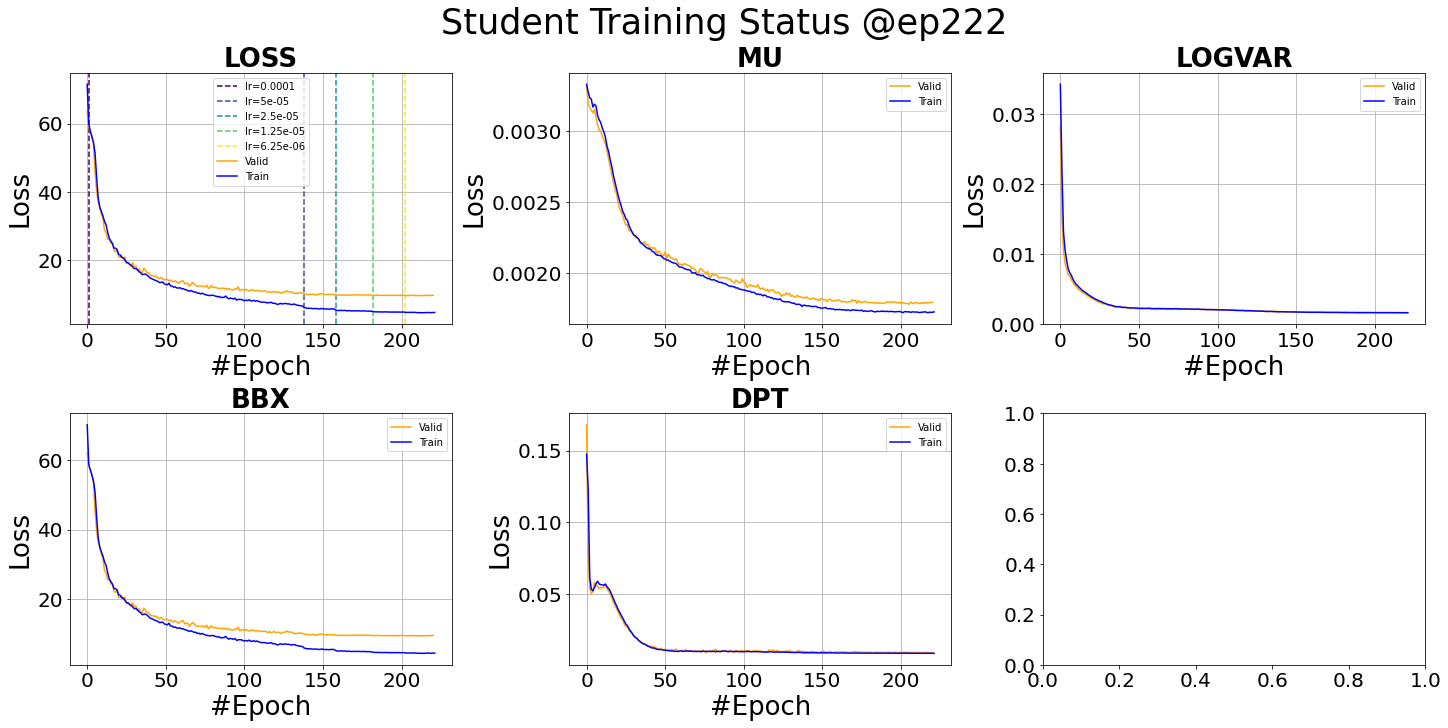

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student test: sample=50/52, loss=0.2515    
Test finished. Average loss={'LOSS': 0.2540452132771651, 'MU': 0.10985730470702038, 'LOGVAR': 0.09970098682031046, 'BBX': 0.05755326479223955, 'DPT': 0.008866590553577013}

Total training time: 36.6300892829895 sec


<Figure size 1440x720 with 0 Axes>

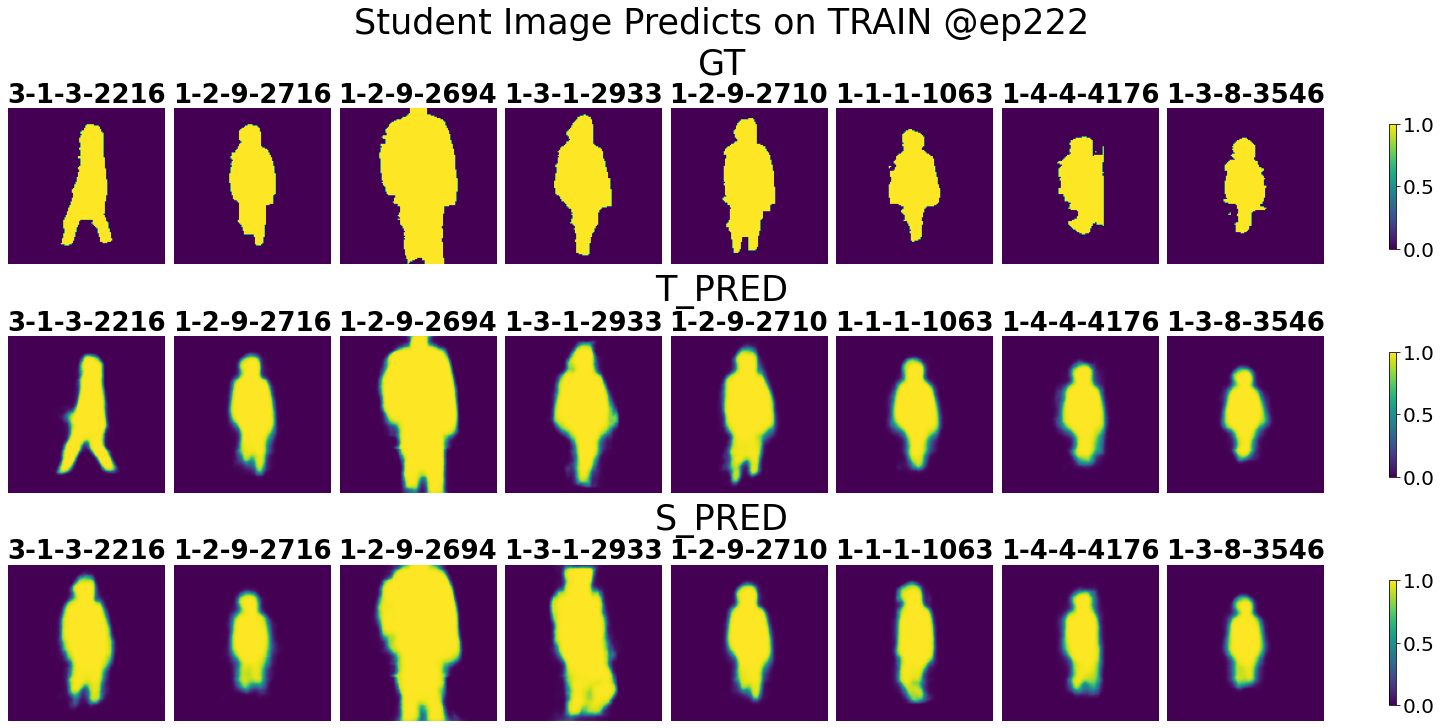

<Figure size 1440x720 with 0 Axes>

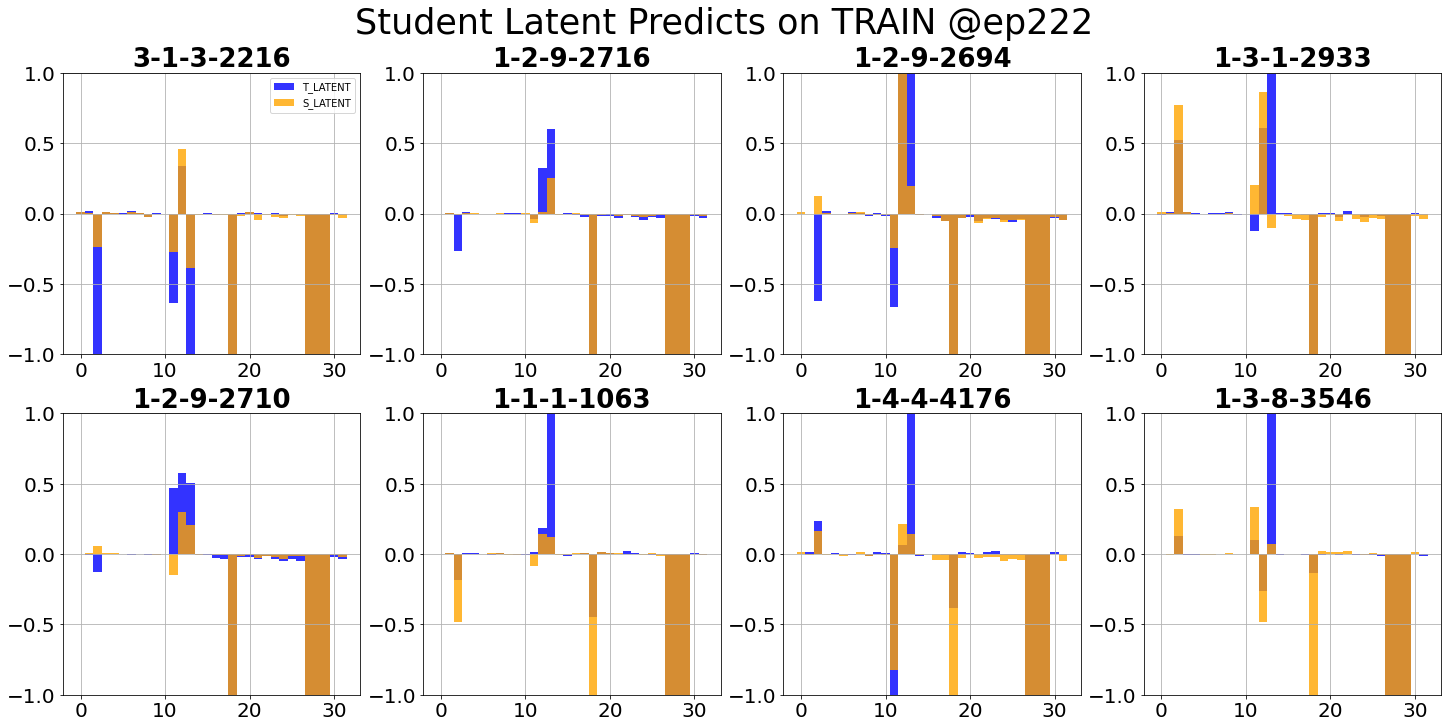

<Figure size 1440x720 with 0 Axes>

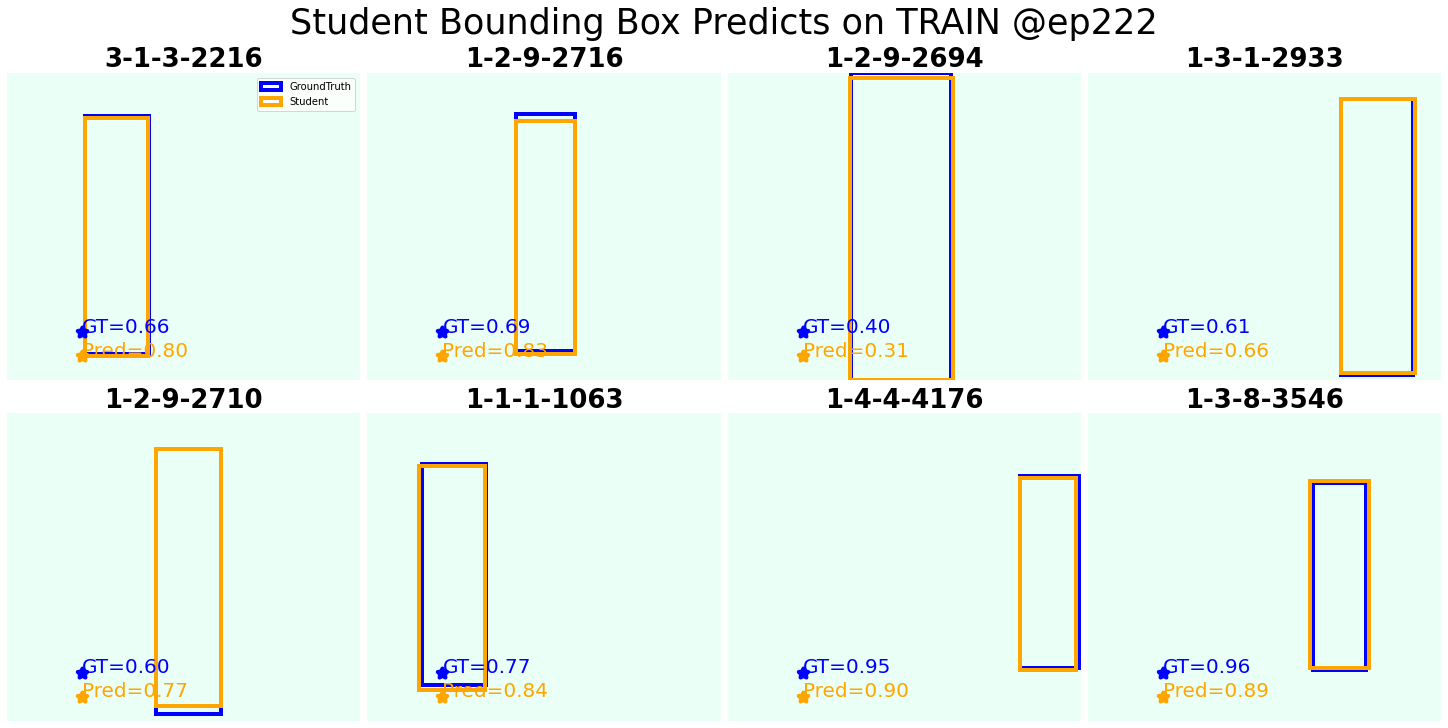

<Figure size 1440x720 with 0 Axes>

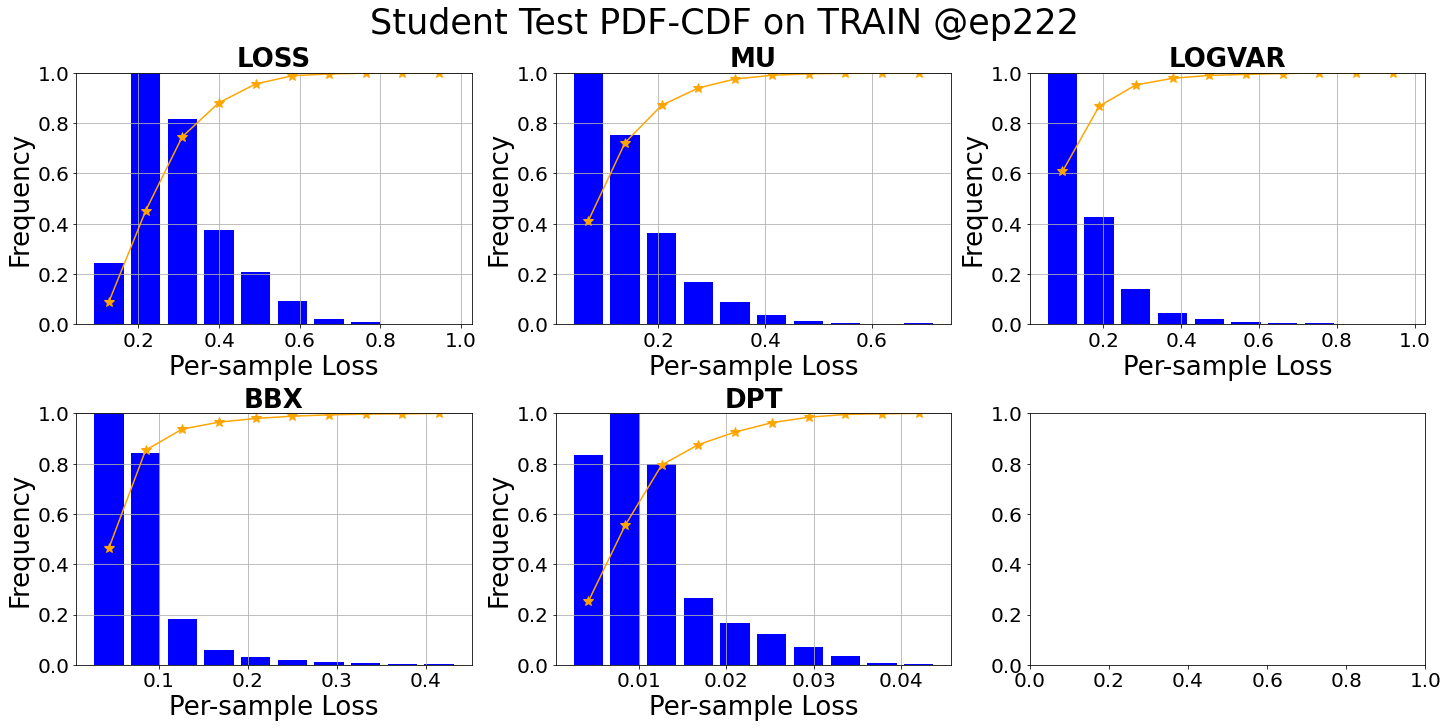

/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.items()
/home/bob/datastore/Models/DataSetting_v2.py:186: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  for key, value in self.data.it

Student test: sample=5295/5299, loss=0.4642    
Test finished. Average loss={'LOSS': 0.7624416681230461, 'MU': 0.11981640603054726, 'LOGVAR': 0.18537874462213788, 'BBX': 0.41953220386476386, 'DPT': 0.02099805884793148}

Total training time: 408.4794087409973 sec


<Figure size 1440x720 with 0 Axes>

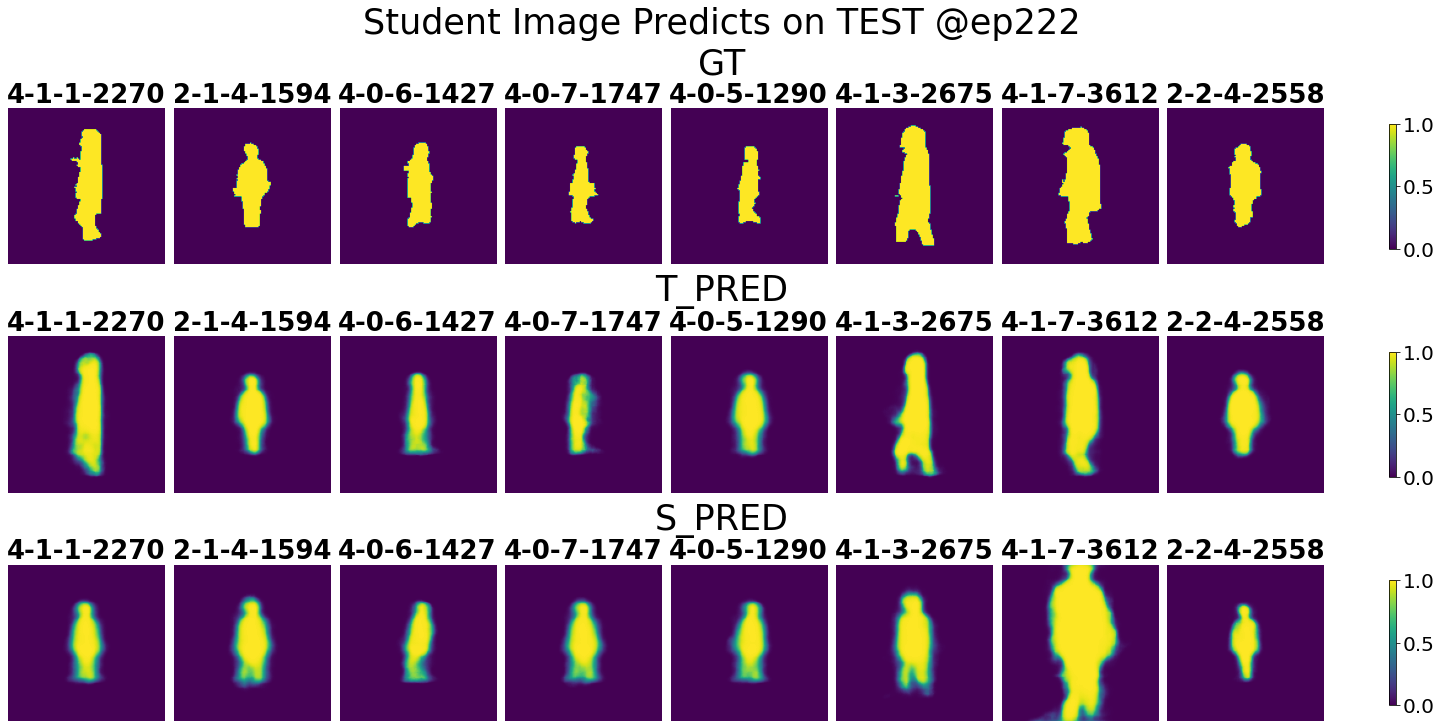

<Figure size 1440x720 with 0 Axes>

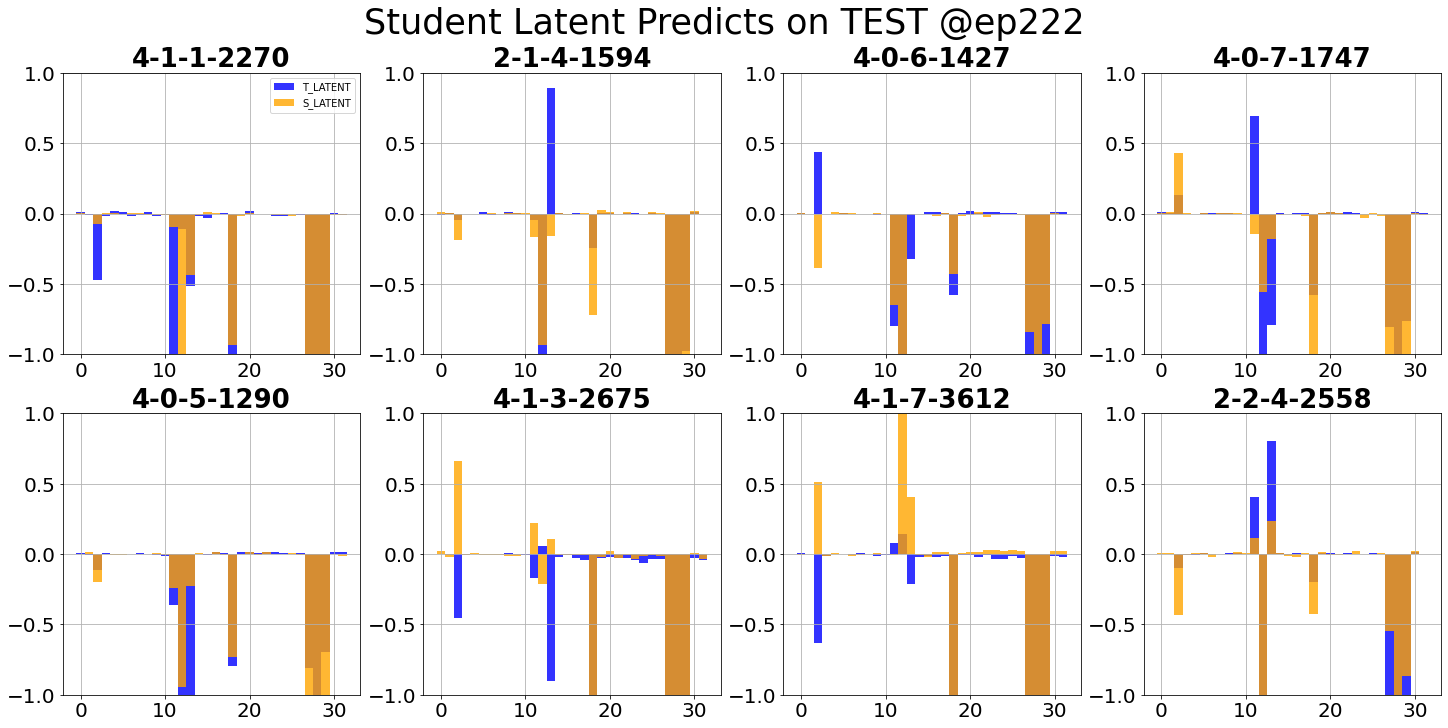

<Figure size 1440x720 with 0 Axes>

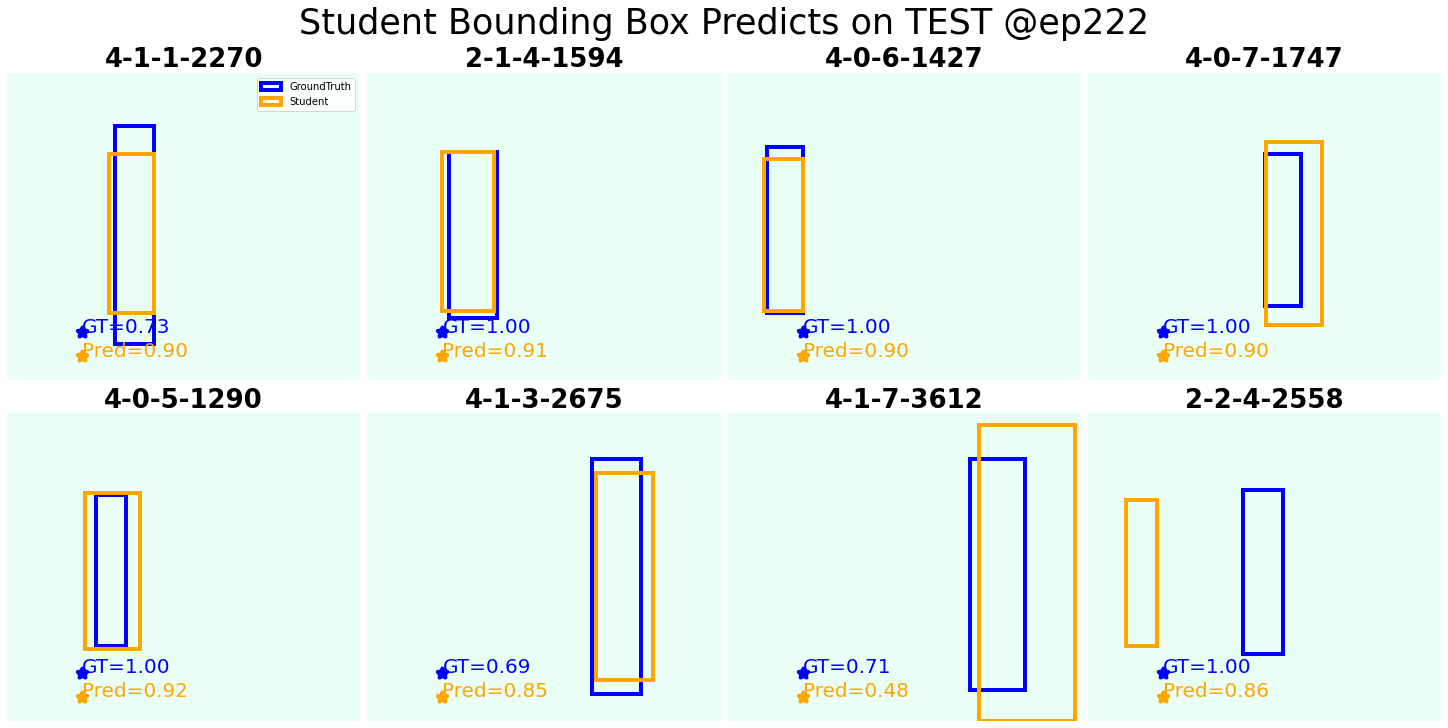

<Figure size 1440x720 with 0 Axes>

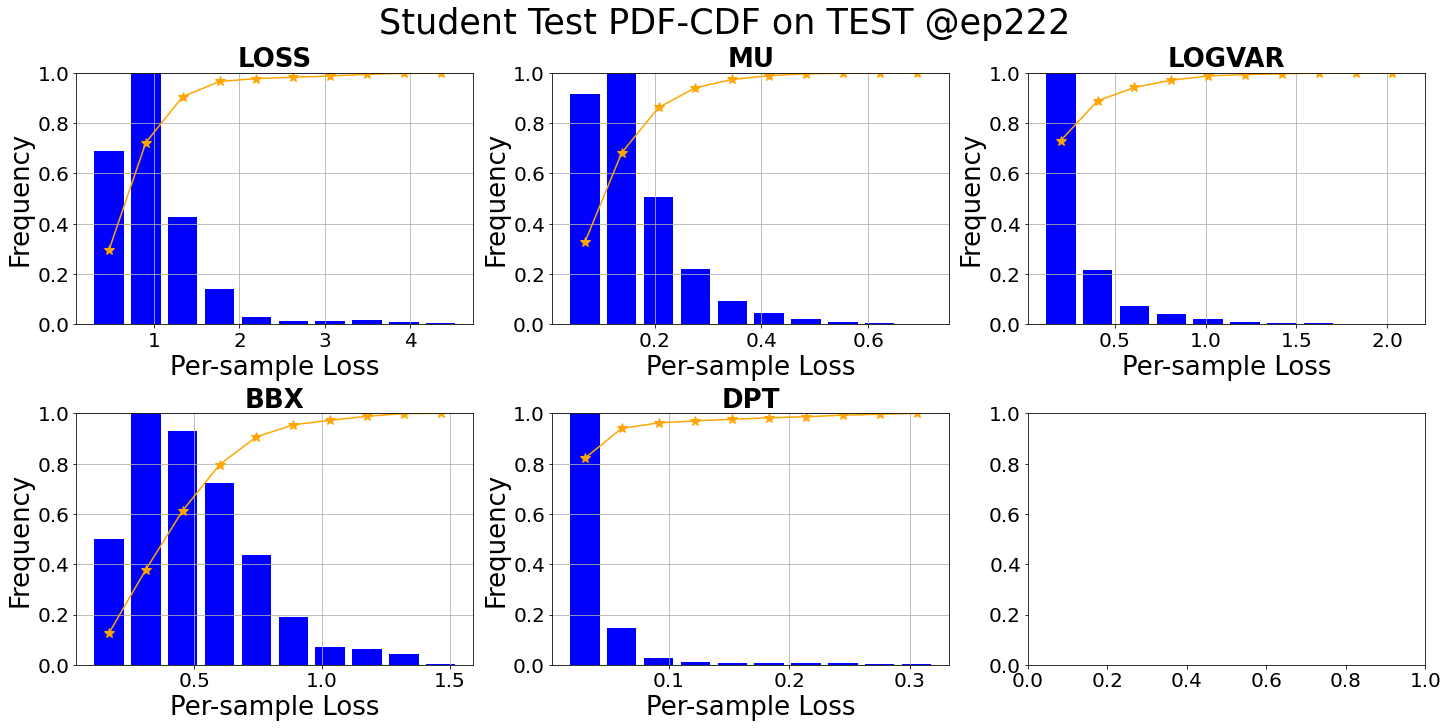

Saving preds: GT...
Saving preds: T_PRED...
Saving preds: S_PRED...
Saving preds: T_LATENT...
Saving preds: S_LATENT...
Saving preds: GT_BBX...
Saving preds: S_BBX...
Saving preds: GT_DPT...
Saving preds: S_DPT...
Saving preds: TAG...
All saved!

Student schedule Completed!


In [13]:
### Scheduler
%matplotlib inline
# S_trainer.loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]}
S_trained = S_trainer.schedule(lr_decay=True, train_module={'csien', 'bbxde'}, eval_module={'imgen', 'imgde'})